In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [3]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

2025-07-10 14:43:59,279 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_171940/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

In [5]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))
rndpos_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"], 
                                              emb_data["input_ids2dict_ids"], 
                                              emb_data["dict_ids2input_ids"], 
                                              max_seq_len=20, embed_dim=4096,
                                              wpe_scale=1/6).to("cuda")

/tmp/ipykernel_171940/3803893638.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))


In [6]:
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
# encoder = T5EncoderModel.from_pretrained(T5_path)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
pipeline.tokenizer = tokenizer
pipeline.text_encoder = rndpos_encoder
pipeline.to(device="cuda", dtype=weight_dtype);

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

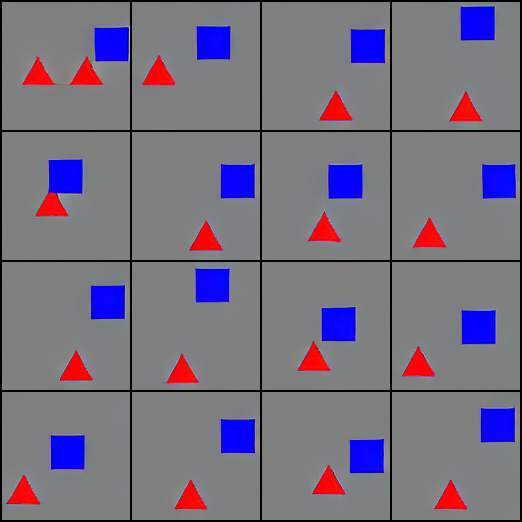

In [10]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
prompt = "red triangle below and to the left of blue square"    
output = pipeline(prompt, 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

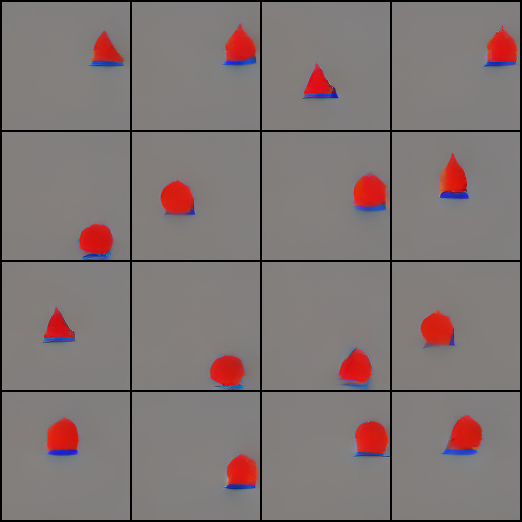

In [ ]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
prompt = "blue triangle"    
output = pipeline(prompt, 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

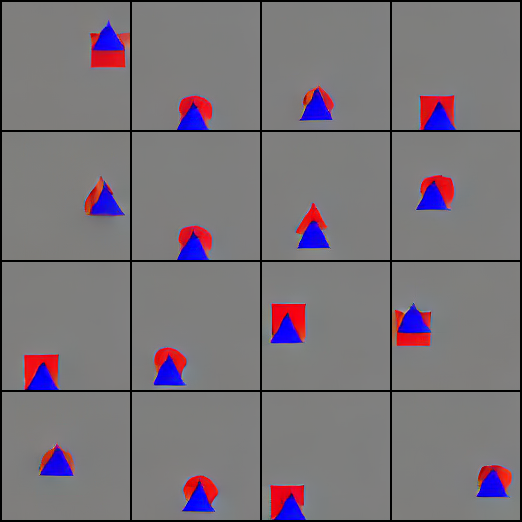

In [25]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
prompt = "the the the blue triangle"    
output = pipeline(prompt, 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

In [18]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

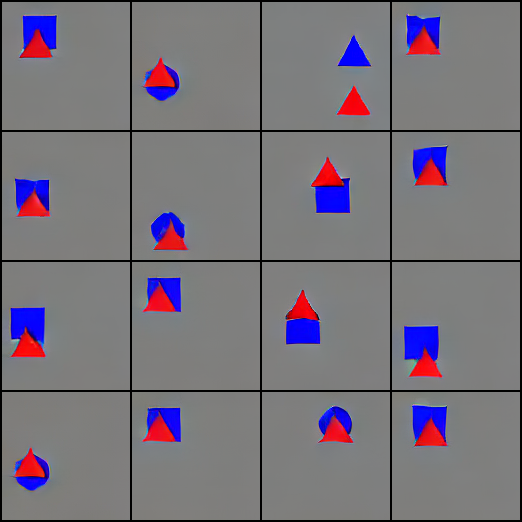

In [190]:
attnvis_store.clear_activation()
prompt = "the the the red triangle"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

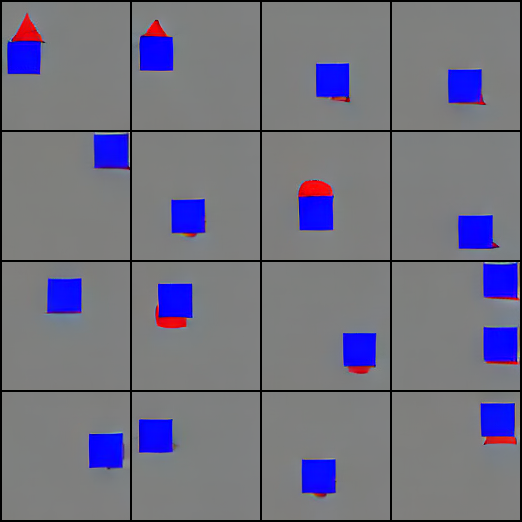

In [194]:
attnvis_store.clear_activation()
prompt = "the the the blue square"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

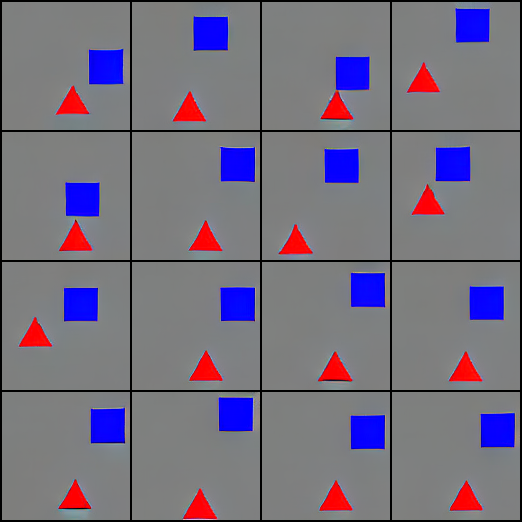

In [195]:
attnvis_store.clear_activation()
prompt = "red triangle below and to the left of blue square"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [196]:
grid = pil_images_to_grid(output[0].images)
grid.save(join(prompt_dir, "sample_images_grid.png"))

In [11]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 20])


## Search for attention maps that match a certain template

In [77]:
import cv2
import numpy as np
from tqdm.auto import trange
import seaborn as sns
import matplotlib.pyplot as plt
import torch as th
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps
from utils.attention_analysis_lib import *
from utils.cv2_eval_utils import find_classify_object_masks
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

In [111]:
def plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", step_id=None, share_clim=False):
    """Assume the shape is (num_layers, num_steps, num_images * 2, num_heads)
    This function will summarize over the number of steps, 
    Then average across splits of cond pass and uncond pass in the middle of image dimension. 
    """
    n_samples = template_similarity_scores.shape[2] // 2
    cond_slice = slice(n_samples, n_samples * 2)
    uncond_slice = slice(0, n_samples)
    if step_sum_type == "max":
        temporal_summary = template_similarity_scores.max(dim=1).values
    elif step_sum_type == "mean":
        temporal_summary = template_similarity_scores.mean(dim=1)
    elif step_sum_type == "index" and step_id is not None:
        temporal_summary = template_similarity_scores[:, step_id, :, :]
    else:
        raise ValueError(f"Invalid step_sum_type: {step_sum_type}")
    cond_layer_head_summary = temporal_summary[:, cond_slice, :].mean(dim=-2).numpy() # average over samples 
    uncond_layer_head_summary = temporal_summary[:, uncond_slice, :].mean(dim=-2).numpy() # average over samples 
    if share_clim:
        vmin = min(cond_layer_head_summary.min(), uncond_layer_head_summary.min())
        vmax = max(cond_layer_head_summary.max(), uncond_layer_head_summary.max())
    else:
        vmin = None
        vmax = None
    fig = plt.figure(figsize=(10, 4.5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cond_layer_head_summary, vmin=vmin, vmax=vmax)
    plt.title("Cond pass")
    plt.axis('image')
    plt.ylabel("Layer")
    plt.xlabel("Head")
    plt.subplot(1, 2, 2)
    sns.heatmap(uncond_layer_head_summary, vmin=vmin, vmax=vmax)
    plt.title("Uncond pass")
    plt.axis('image')
    plt.ylabel("Layer")
    plt.xlabel("Head")
    plt.suptitle(f"Attention template similarity Layer-Head Summary | {step_sum_type} over steps | {template_type} ")
    plt.show()
    return fig, cond_layer_head_summary, uncond_layer_head_summary

### Find text tokens with certain structure

In [32]:
token_splits = pipeline.tokenizer.tokenize(prompt)

In [33]:
pipeline.tokenizer.encode(prompt)

[1131, 19938, 666, 11, 12, 8, 646, 13, 1692, 2812, 1]

In [34]:
# Create multi-hot masks for each category
def create_multi_hot_token_mask(tokens, target_words, seq_len=None):
    mask = th.zeros(len(tokens) if seq_len is None else seq_len, dtype=th.bool)
    for i, token in enumerate(tokens):
        # Remove the special prefix if present
        clean_token = token.replace('▁', '') if token.startswith('▁') else token
        if clean_token in target_words:
            mask[i] = True
    return mask

# Create multi-hot masks for different types of words
token_splits = pipeline.tokenizer.tokenize(prompt)
print("Token splits:", token_splits)

# Define word categories
color_words = ['red', 'blue']
shape_words = ['triangle', 'square']
spatial_words = ['below', 'left', 'above', 'right']
preposition_words = ['and', 'to', 'the', 'of']

color_mask = create_multi_hot_token_mask(token_splits, color_words)
shape_mask = create_multi_hot_token_mask(token_splits, shape_words)
spatial_mask = create_multi_hot_token_mask(token_splits, spatial_words)
preposition_mask = create_multi_hot_token_mask(token_splits, preposition_words)

print("Color mask (red, blue):", color_mask)
print("Shape mask (triangle, square):", shape_mask)
print("Spatial mask (below, left):", spatial_mask)
print("Preposition mask (and, to, the, of):", preposition_mask)

# Show which tokens are selected by each mask
print("\nColor tokens:", [token for i, token in enumerate(token_splits) if color_mask[i]])
print("Shape tokens:", [token for i, token in enumerate(token_splits) if shape_mask[i]])
print("Spatial tokens:", [token for i, token in enumerate(token_splits) if spatial_mask[i]])
print("Preposition tokens:", [token for i, token in enumerate(token_splits) if preposition_mask[i]])

Token splits: ['▁red', '▁triangle', '▁below', '▁and', '▁to', '▁the', '▁left', '▁of', '▁blue', '▁square']
Color mask (red, blue): tensor([ True, False, False, False, False, False, False, False,  True, False])
Shape mask (triangle, square): tensor([False,  True, False, False, False, False, False, False, False,  True])
Spatial mask (below, left): tensor([False, False,  True, False, False, False,  True, False, False, False])
Preposition mask (and, to, the, of): tensor([False, False, False,  True,  True,  True, False,  True, False, False])

Color tokens: ['▁red', '▁blue']
Shape tokens: ['▁triangle', '▁square']
Spatial tokens: ['▁below', '▁left']
Preposition tokens: ['▁and', '▁to', '▁the', '▁of']


### Image tokens with similar structure

In [ ]:
positive_threshold = 180 
MAXIMUM = 255

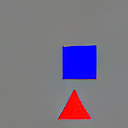

In [56]:
output[0].images[0]

In [54]:
df, object_masks = find_classify_object_masks(output[0].images[0])

In [55]:
df

Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (246, 13, 15)   (75, 103.0)   463.5     443.405007
1       6    Square    (8, 5, 249)      (79, 62)  1088.5    1024.000000

In [49]:
df, object_masks = find_classify_object_masks(output[0].images[0])
obj_masks_resized = [cv2.resize(obj_mask, (8, 8), interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
# object_masks is a list of binary masks (numpy arrays) for each detected object

In [66]:
img_square_msk, _ = get_square_pos_others_neg_mask(df, obj_masks_resized_float)
img_triangle_msk, _ = get_triangle_pos_others_neg_mask(df, obj_masks_resized_float)
img_circle_msk, _ = get_circle_pos_others_neg_mask(df, obj_masks_resized_float)

In [74]:
print(prompt)
token_splits = pipeline.tokenizer.tokenize(prompt)
text_square_mask = create_multi_hot_token_mask(token_splits, ["square"], seq_len=20)

df, object_masks = find_classify_object_masks(output[0].images[0])
obj_masks_resized = [cv2.resize(obj_mask, (8, 8), interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
img_square_msk, _ = get_square_pos_others_neg_mask(df, obj_masks_resized_float)
img_triangle_msk, _ = get_triangle_pos_others_neg_mask(df, obj_masks_resized_float)
img_circle_msk, _ = get_circle_pos_others_neg_mask(df, obj_masks_resized_float)

cross_attn_template = th.from_numpy(img_square_msk).float().flatten()[:, None] @ text_square_mask.float().flatten()[None, :] 

red triangle below and to the left of blue square


In [ ]:
def postprocess_template(attn_template_tsr):
    attn_template_uncond_cmb_tsr = attn_template_tsr.repeat(2,1,1) # (n_samples, n_tokens, n_tokens) -> (n_samples * 2, n_tokens, n_tokens)
    attn_template_uncond_cmb_tsr = attn_template_uncond_cmb_tsr.unsqueeze(1) # (n_samples * 2, n_tokens, n_tokens) -> (n_samples * 2, 1, n_tokens, n_tokens)
    return attn_template_uncond_cmb_tsr

In [150]:
def create_object_based_masks(image_list, get_mask_func, map_shape=(8, 8), positive_threshold=180,):
    """
    some mask functions:
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    """
    img_msks = []
    for img_idx in range(len(image_list)):
        image = image_list[img_idx]
        df, object_masks = find_classify_object_masks(image)
        obj_masks_resized = [cv2.resize(obj_mask, map_shape, interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
        obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
        obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
        img_square_msk, _ = get_mask_func(df, obj_masks_resized_float)
        # img_triangle_msk, _ = get_triangle_pos_others_neg_mask(df, obj_masks_resized_float)
        # img_circle_msk, _ = get_circle_pos_others_neg_mask(df, obj_masks_resized_float)
        img_msks.append(th.from_numpy(img_square_msk).float())
    img_msks = th.stack(img_msks)
    # img_msks.shape # (n_samples, H, W)
    cmb_img_msks = img_msks.repeat(2,1,1)
    cmb_img_msks = cmb_img_msks.unsqueeze(1)
    # cmb_img_msks.shape # (n_samples * 2, 1, H, W)
    cmb_img_msks_vec = cmb_img_msks.flatten(start_dim=-2)
    return cmb_img_msks_vec, img_msks

In [ ]:
img_msks = []
for img_idx in range(len(output[0].images)):
    image = output[0].images[img_idx]
    df, object_masks = find_classify_object_masks(image)
    obj_masks_resized = [cv2.resize(obj_mask, (8, 8), interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
    obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
    obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
    img_square_msk, _ = get_square_pos_others_neg_mask(df, obj_masks_resized_float)
    # img_triangle_msk, _ = get_triangle_pos_others_neg_mask(df, obj_masks_resized_float)
    # img_circle_msk, _ = get_circle_pos_others_neg_mask(df, obj_masks_resized_float)
    img_msks.append(th.from_numpy(img_square_msk).float())
img_msks = th.stack(img_msks)
# img_msks.shape # (n_samples, H, W)
cmb_img_msks = img_msks.repeat(2,1,1)
cmb_img_msks = cmb_img_msks.unsqueeze(1)
# cmb_img_msks.shape # (n_samples * 2, 1, H, W)
cmb_img_msks_vec = cmb_img_msks.flatten(start_dim=-2)
# cmb_img_msks_vec.shape # (n_samples * 2, H * W)

In [121]:
n_images = 16
uncond_slice = slice(0, n_images)
cond_slice = slice(n_images, 2 * n_images)

In [134]:
def print_top_k_scores(scores, k=10, title="Top scores"):
    """
    Print the top k scores and their layer/head indices.
    
    Args:
        scores: tensor of shape (n_layers, n_heads, ...)
        k: number of top scores to print
        title: title for the output
    """
    # Flatten the scores while keeping track of layer and head indices
    scores = th.from_numpy(scores)
    n_layers, n_heads = scores.shape[:2]
    flattened_scores = scores.flatten()
    # Get the top k scores and their indices
    top_k_values, top_k_indices = flattened_scores.topk(k, largest=True)
    print(f"\n{title}:")
    print("-" * 50)
    for i, (value, idx) in enumerate(zip(top_k_values, top_k_indices)):
        # Convert flat index back to layer, head, and remaining dimensions
        remaining_size = scores.numel() // (n_layers * n_heads)
        layer_head_idx = idx // remaining_size
        layer_idx, head_idx = divmod(layer_head_idx.item(), n_heads)
        print(f"Top{i+1}: L{layer_idx}H{head_idx}, Score: {value:.2f}")

In [178]:
text_square_mask = create_multi_hot_token_mask(token_splits, ["square"], seq_len=20)

In [179]:
square_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_square_pos_others_neg_mask)

In [181]:
square_cmb_img_msks_vec[0,0].view(8,8)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [182]:
text_square_mask

tensor([False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False])

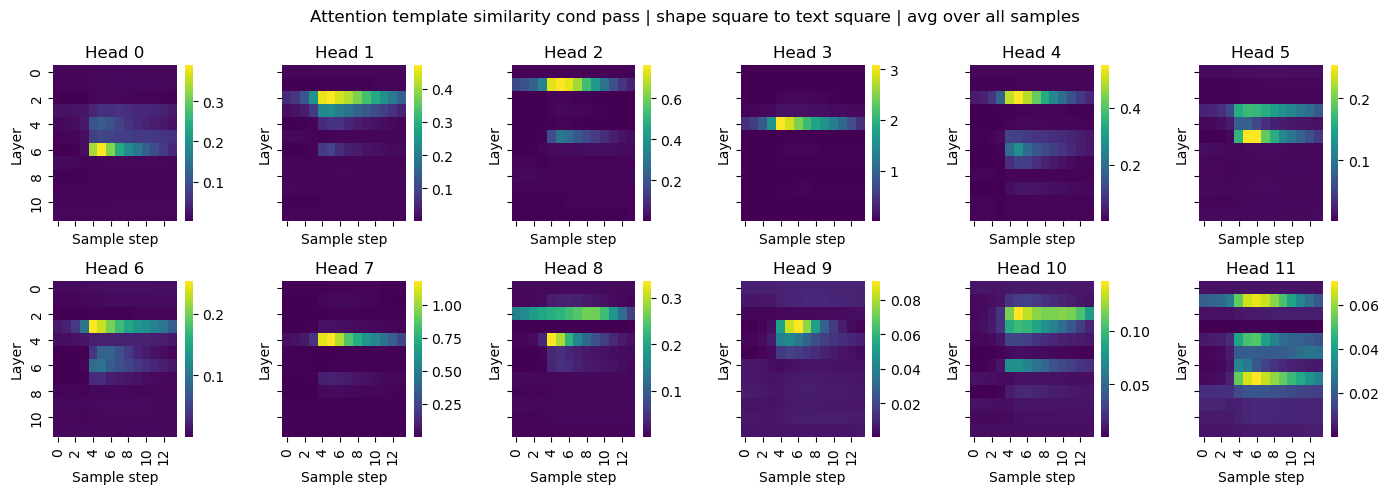

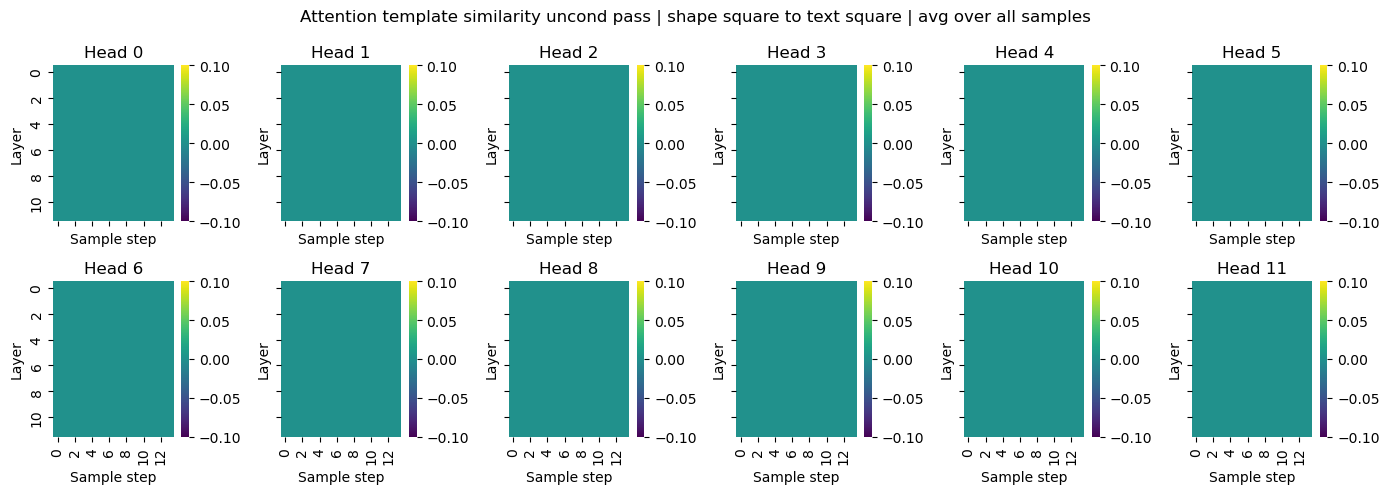

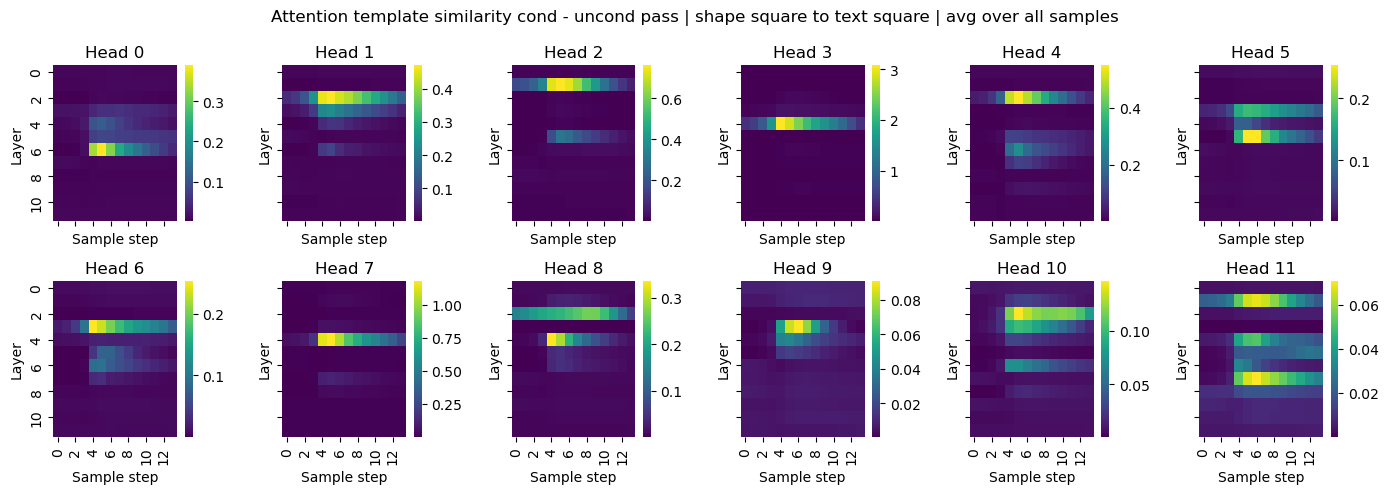

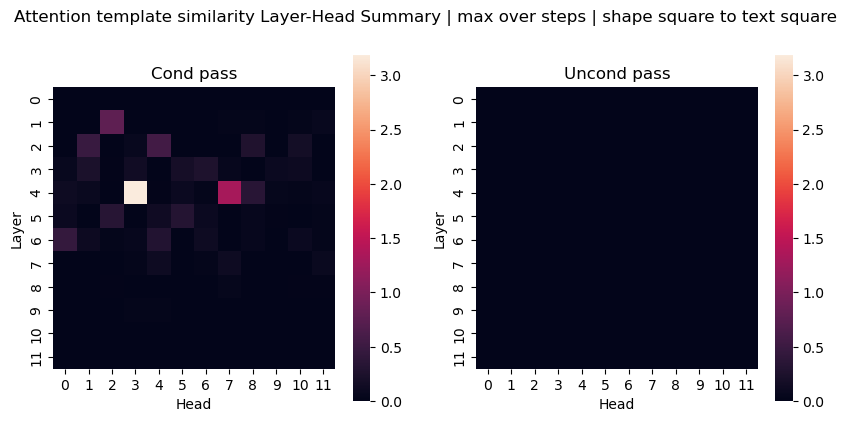


Top Heads shape square to text square:
--------------------------------------------------
Top1: L4H3, Score: 3.19
Top2: L4H7, Score: 1.32
Top3: L1H2, Score: 0.78
Top4: L2H4, Score: 0.55
Top5: L2H1, Score: 0.48
Top6: L6H0, Score: 0.44
Top7: L4H8, Score: 0.34
Top8: L5H2, Score: 0.33


In [138]:
template_type = "shape square to text square"
text_square_mask = create_multi_hot_token_mask(token_splits, ["square"], seq_len=20)
cross_attn_template = cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
# attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
# attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

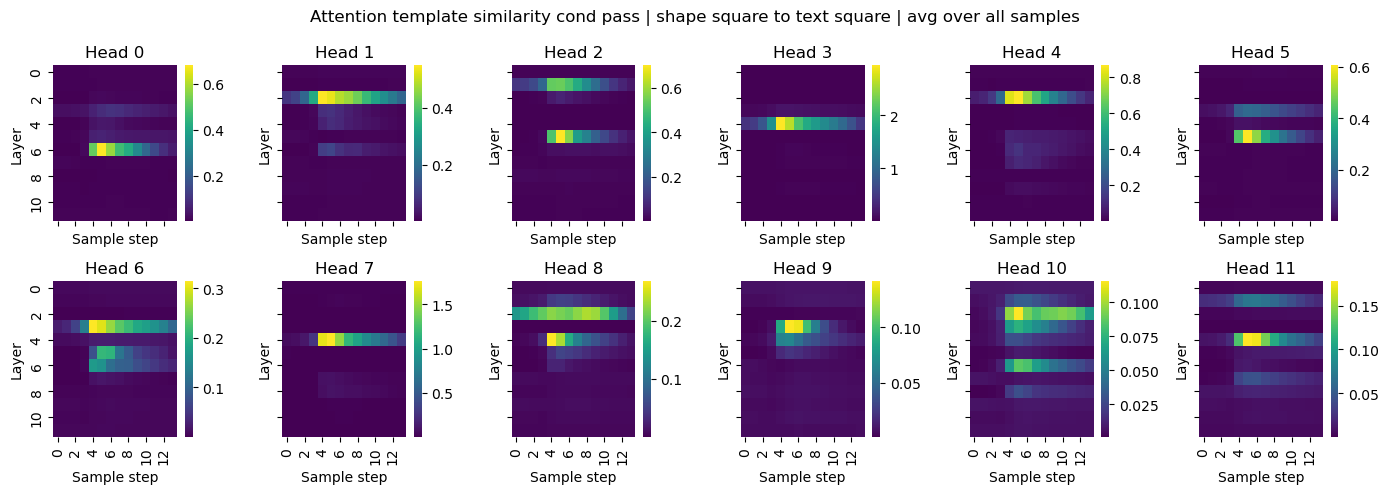

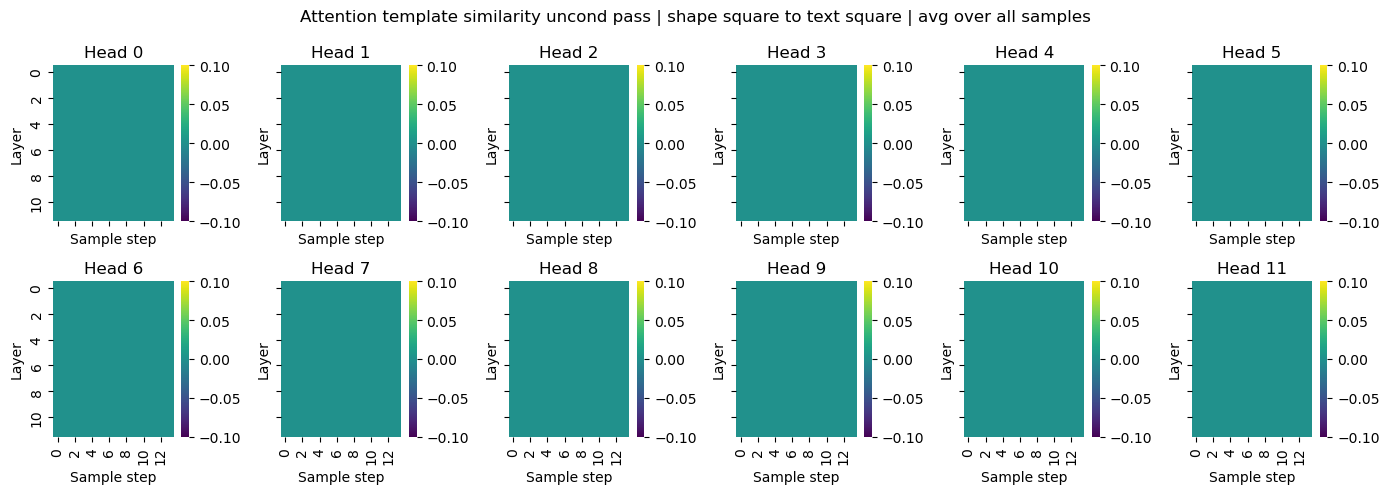

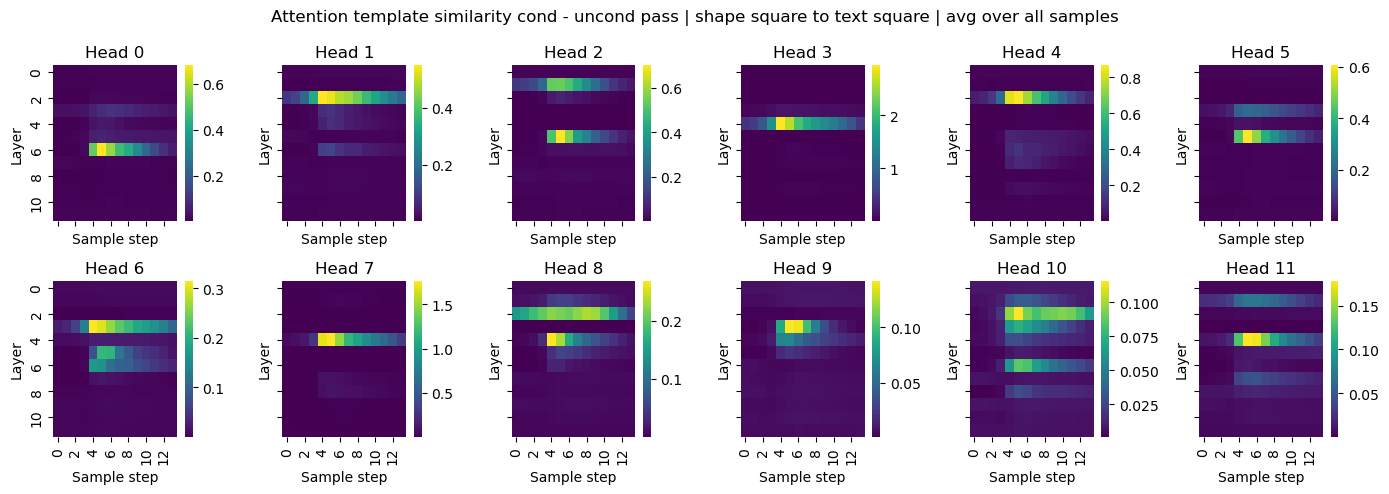

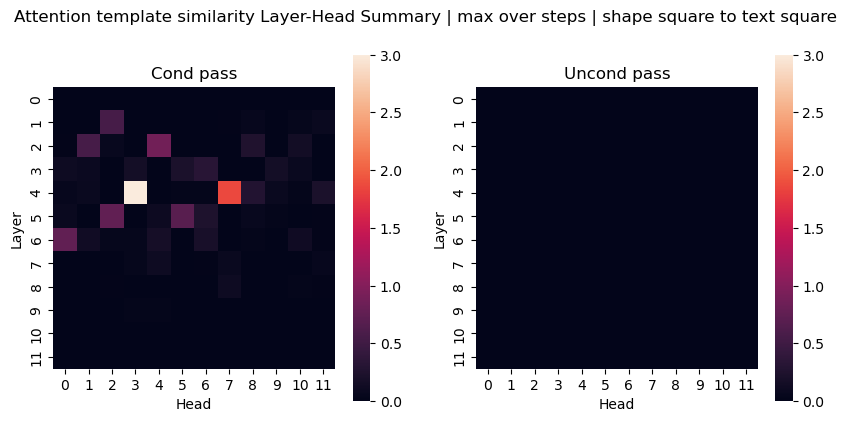

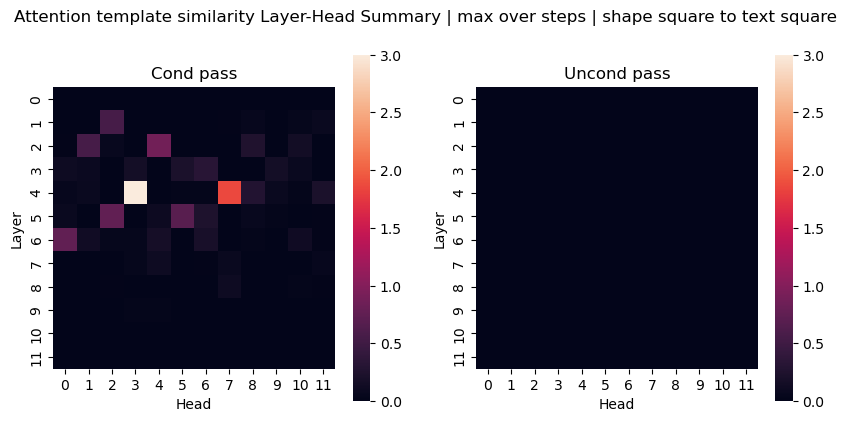

In [ ]:
if False:
    template_type = "shape square to text square"
    cross_attn_template = th.from_numpy(img_square_msk).float().flatten()[:, None] @ text_square_mask.float().flatten()[None, :] 
    # attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
    # attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
    template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                            title_str=f"Attention template similarity cond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                            title_str=f"Attention template similarity uncond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                            title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True)

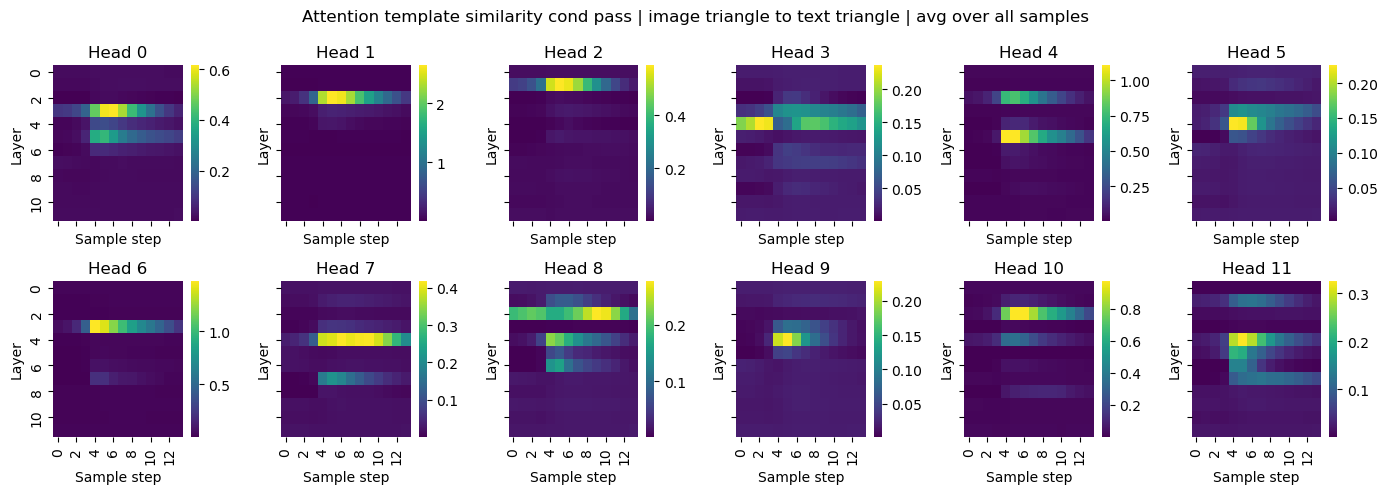

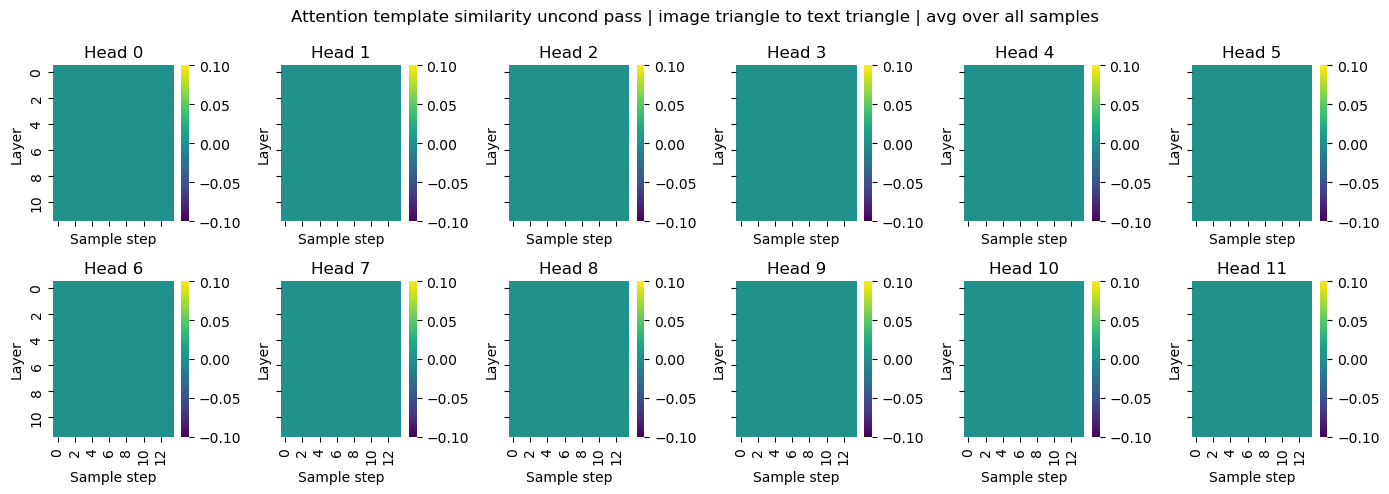

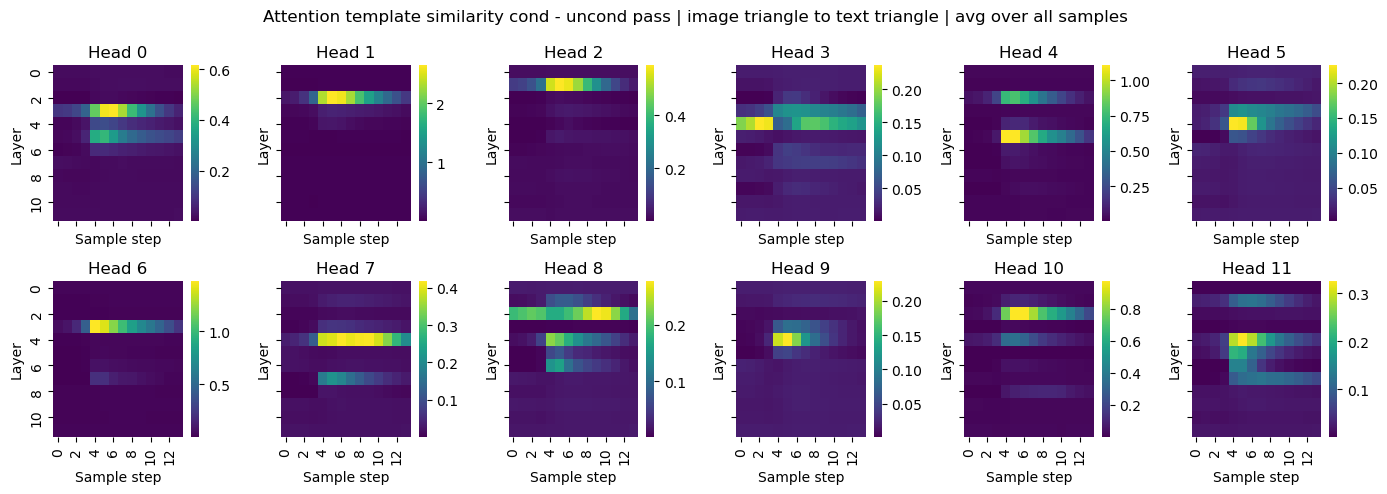

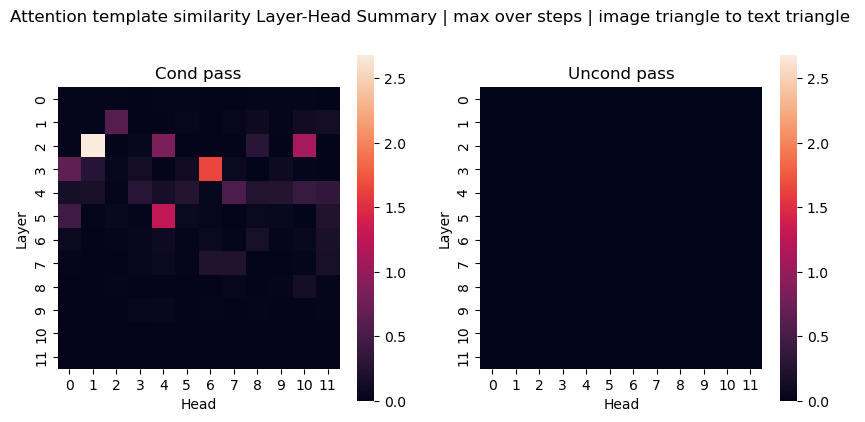


Top Heads image triangle to text triangle:
--------------------------------------------------
Top1: L2H1, Score: 2.68
Top2: L3H6, Score: 1.64
Top3: L5H4, Score: 1.27
Top4: L2H10, Score: 1.11
Top5: L2H4, Score: 0.83
Top6: L3H0, Score: 0.66
Top7: L1H2, Score: 0.61
Top8: L4H7, Score: 0.53


In [ ]:
if False:
    template_type = "image triangle to text triangle"
    text_triangle_mask = create_multi_hot_token_mask(token_splits, ["triangle"], seq_len=20)
    cross_attn_template = cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
    # attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
    # attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
    template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                            title_str=f"Attention template similarity cond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                            title_str=f"Attention template similarity uncond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                            title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
    print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

### Comprehensive survey 

In [95]:
prompt

'red triangle below and to the left of blue square'

In [151]:
square_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_square_pos_others_neg_mask)
triangle_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_triangle_pos_others_neg_mask)
# circle_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_circle_pos_others_neg_mask)

In [152]:
square_cmb_img_msks_vec.shape

torch.Size([32, 1, 64])

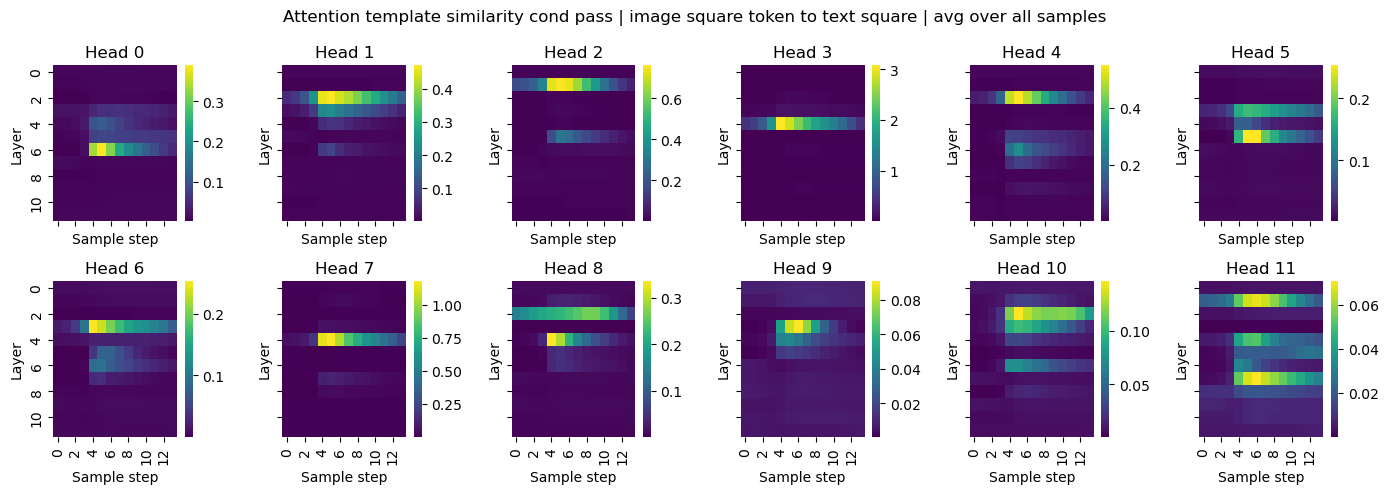

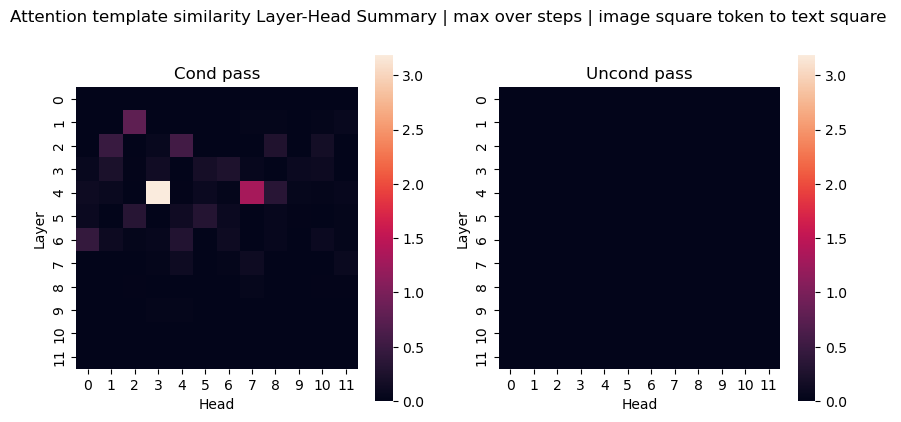


Top Heads image square token to text square:
--------------------------------------------------
Top1: L4H3, Score: 3.19
Top2: L4H7, Score: 1.32
Top3: L1H2, Score: 0.78
Top4: L2H4, Score: 0.55
Top5: L2H1, Score: 0.48
Top6: L6H0, Score: 0.44
Top7: L4H8, Score: 0.34
Top8: L5H2, Score: 0.33


In [ ]:
template_type = "image square token to text square"
text_square_mask = create_multi_hot_token_mask(token_splits, ["square"], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

In [183]:
prompt

'red triangle below and to the left of blue square'

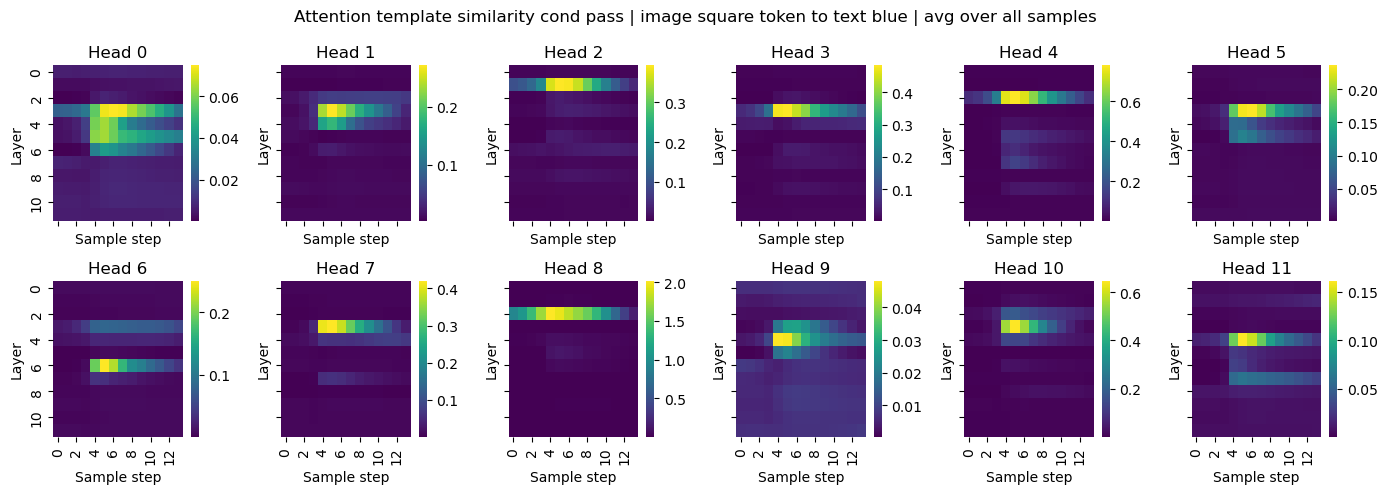

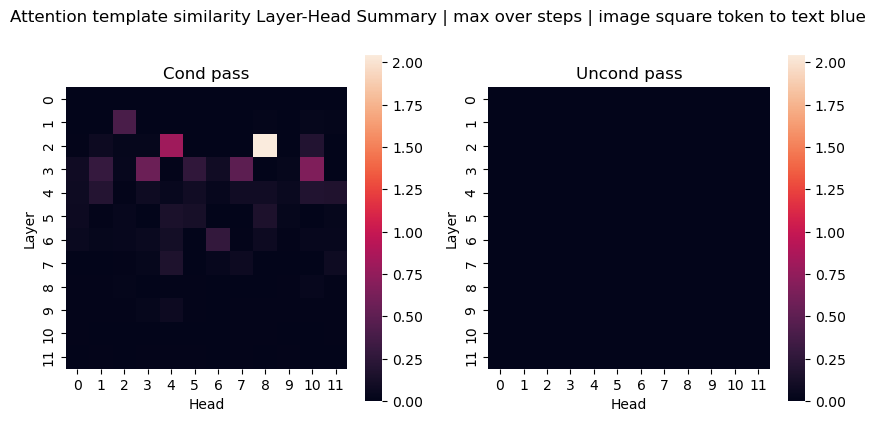


Top Heads image square token to text blue:
--------------------------------------------------
Top1: L2H8, Score: 2.05
Top2: L2H4, Score: 0.81
Top3: L3H10, Score: 0.66
Top4: L3H3, Score: 0.56
Top5: L3H7, Score: 0.50
Top6: L1H2, Score: 0.40
Top7: L3H1, Score: 0.29
Top8: L6H6, Score: 0.28


In [ ]:
template_type = "image square token to text blue"
text_square_mask = create_multi_hot_token_mask(token_splits, ["blue"], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

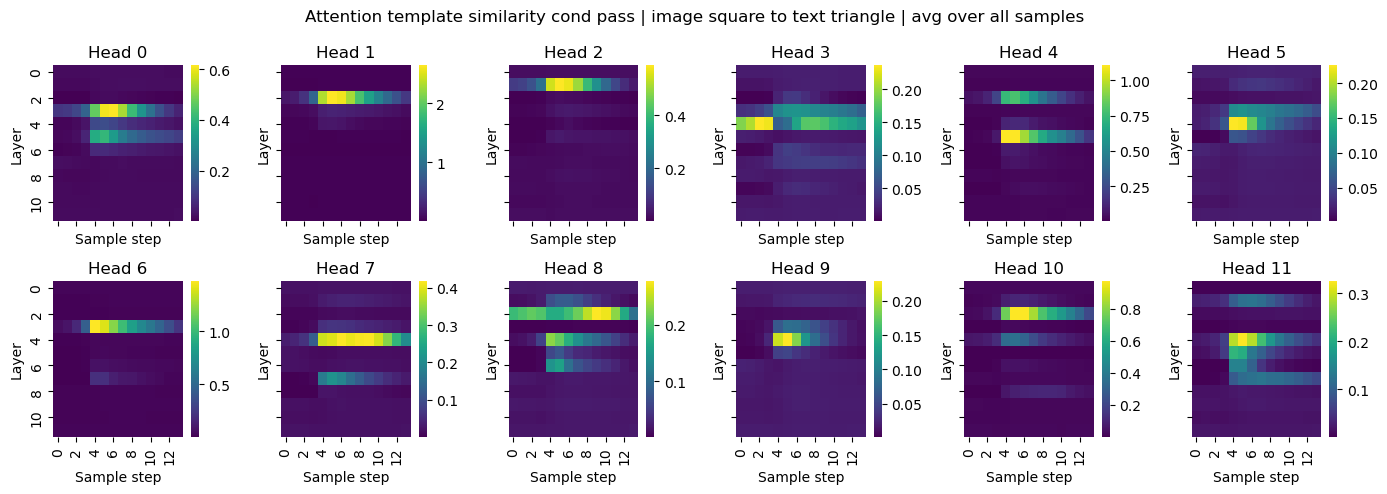

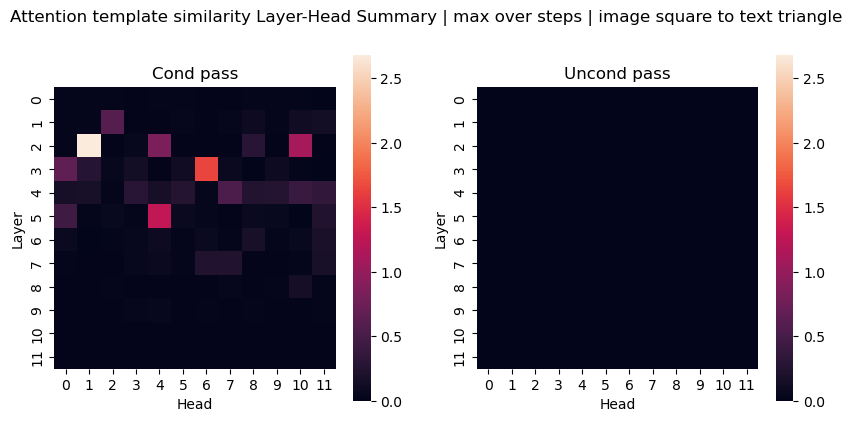


Top Heads image square to text triangle:
--------------------------------------------------
Top1: L2H1, Score: 2.68
Top2: L3H6, Score: 1.64
Top3: L5H4, Score: 1.27
Top4: L2H10, Score: 1.11
Top5: L2H4, Score: 0.83
Top6: L3H0, Score: 0.66
Top7: L1H2, Score: 0.61
Top8: L4H7, Score: 0.53


In [ ]:
template_type = "image square to text triangle"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["triangle"], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

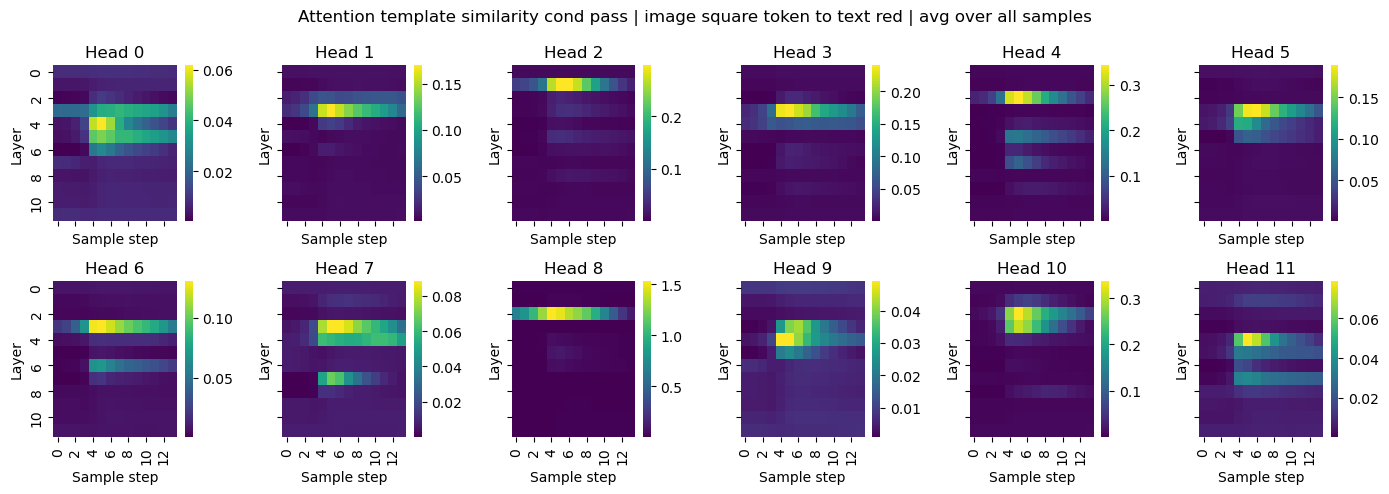

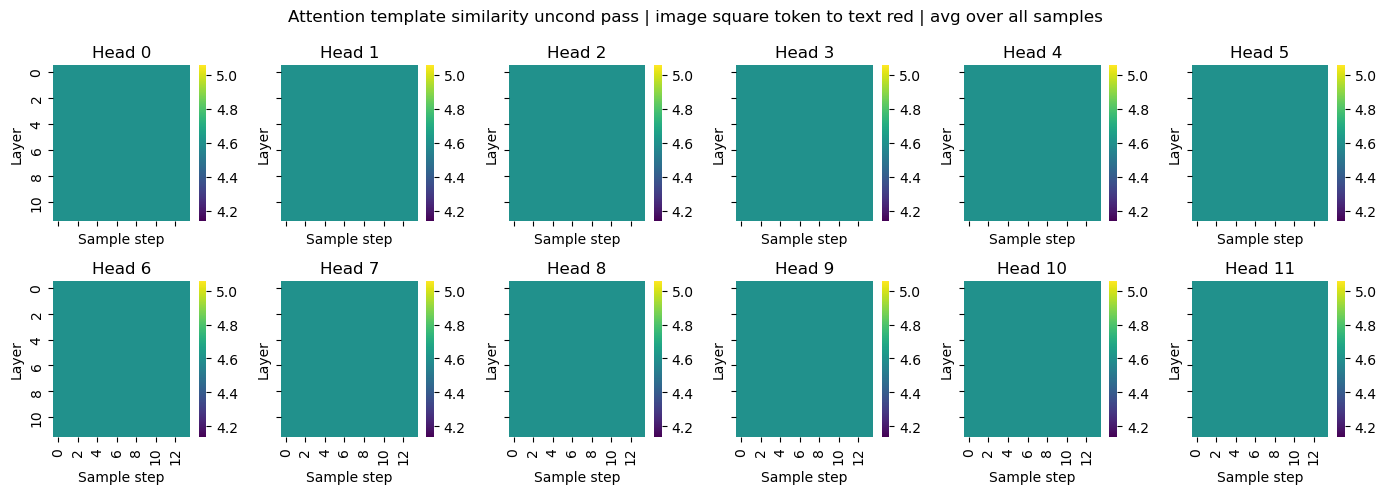

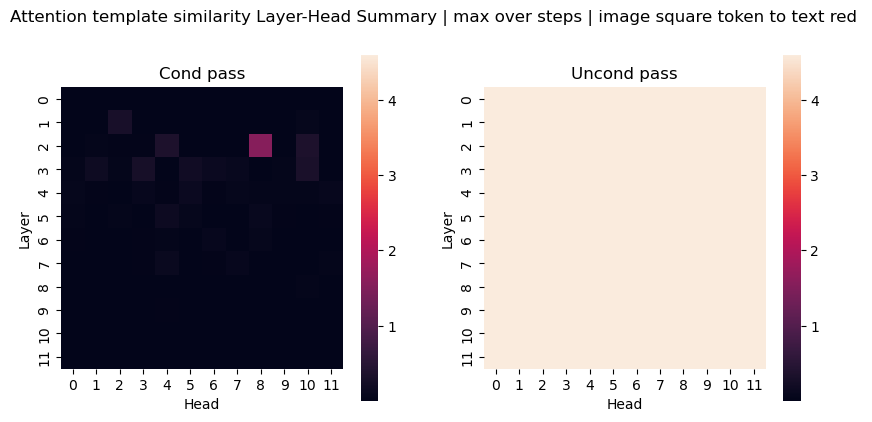

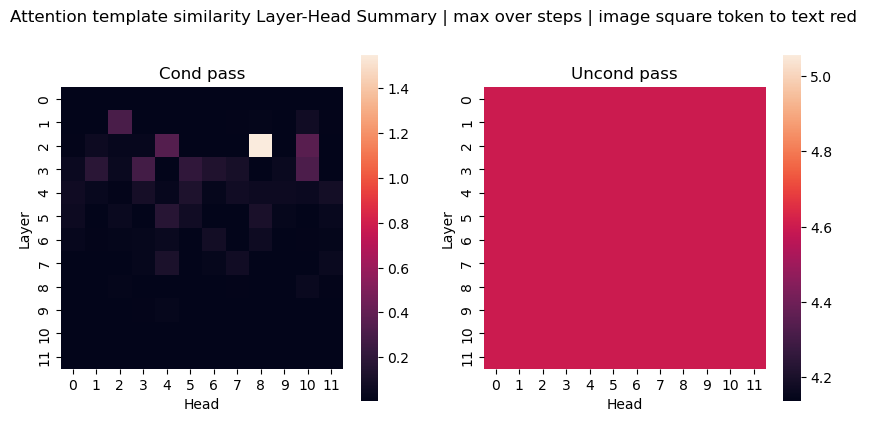


Top Heads image square token to text red:
--------------------------------------------------
Top1: L2H8, Score: 1.55
Top2: L2H10, Score: 0.36
Top3: L2H4, Score: 0.35
Top4: L3H10, Score: 0.32
Top5: L1H2, Score: 0.30
Top6: L3H3, Score: 0.28
Top7: L3H5, Score: 0.20
Top8: L3H1, Score: 0.18


In [ ]:
template_type = "image square token to text red"
text_square_mask = create_multi_hot_token_mask(token_splits, ["red"], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=False);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

In [100]:
prompt

'red triangle below and to the left of blue square'

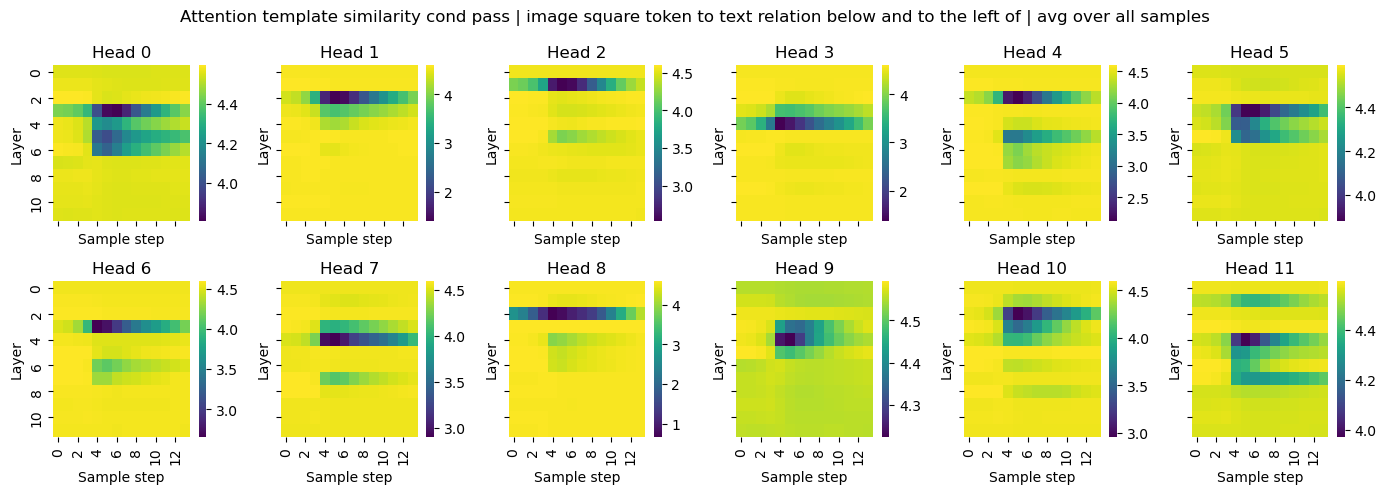

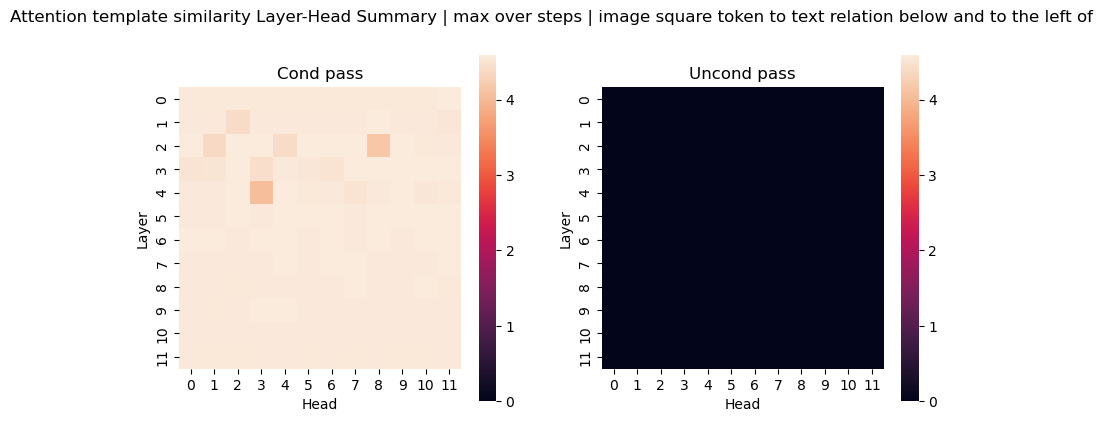


Top Heads image square token to text relation below and to the left of:
--------------------------------------------------
Top1: L8H7, Score: 4.60
Top2: L4H2, Score: 4.60
Top3: L7H4, Score: 4.60
Top4: L2H3, Score: 4.60
Top5: L8H10, Score: 4.60
Top6: L6H11, Score: 4.60
Top7: L7H7, Score: 4.59
Top8: L5H6, Score: 4.59


In [ ]:
template_type = "image square token to text relation below and to the left of"
text_square_mask = create_multi_hot_token_mask(token_splits, ["below", "and", "to", "the", "left", "of"], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @  text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

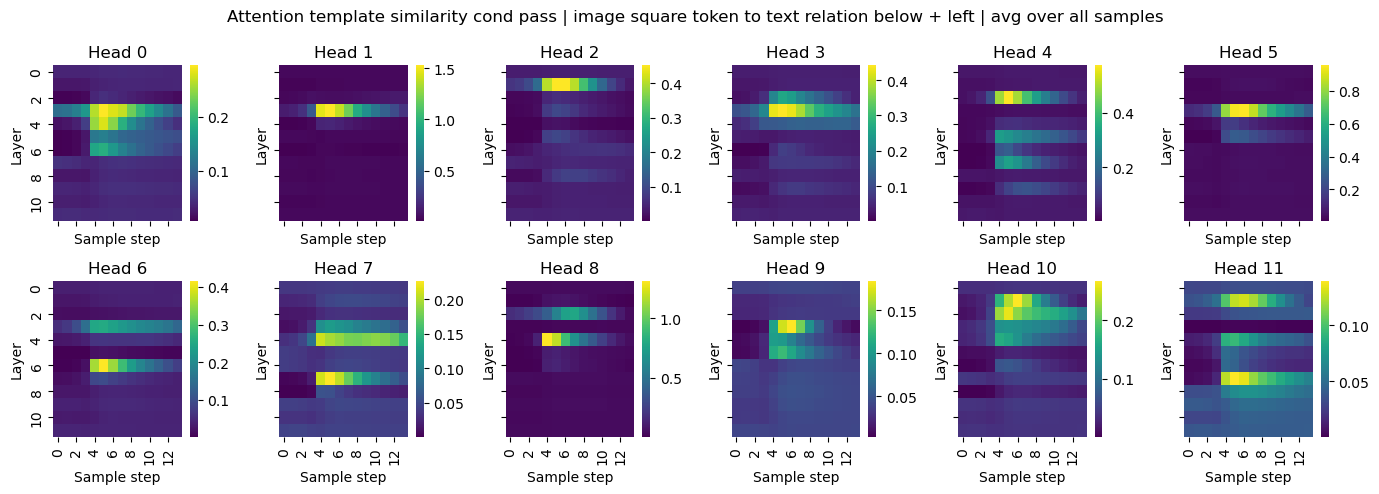

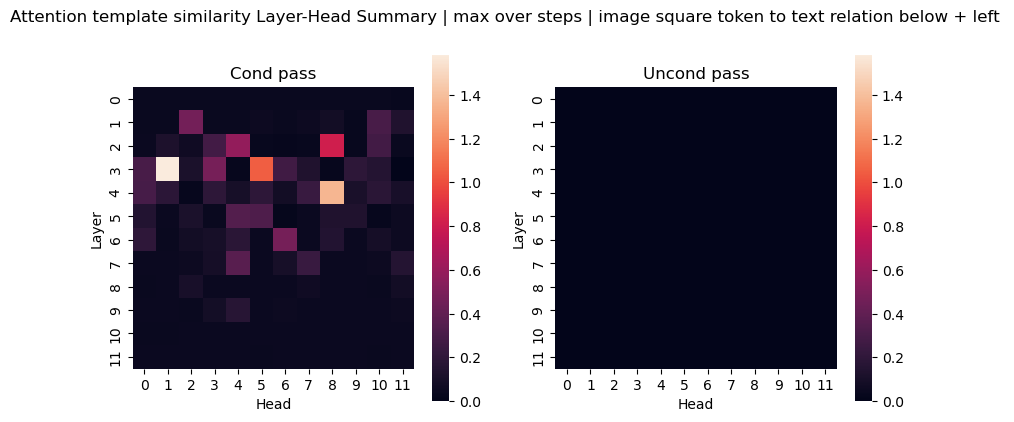


Top Heads image square token to text relation below + left:
--------------------------------------------------
Top1: L3H1, Score: 1.59
Top2: L4H8, Score: 1.36
Top3: L3H5, Score: 1.05
Top4: L2H8, Score: 0.81
Top5: L2H4, Score: 0.58
Top6: L3H3, Score: 0.48
Top7: L6H6, Score: 0.47
Top8: L1H2, Score: 0.47


In [ ]:
template_type = "image square token to text relation below + left"
text_square_mask = create_multi_hot_token_mask(token_splits, ["below", "left",], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

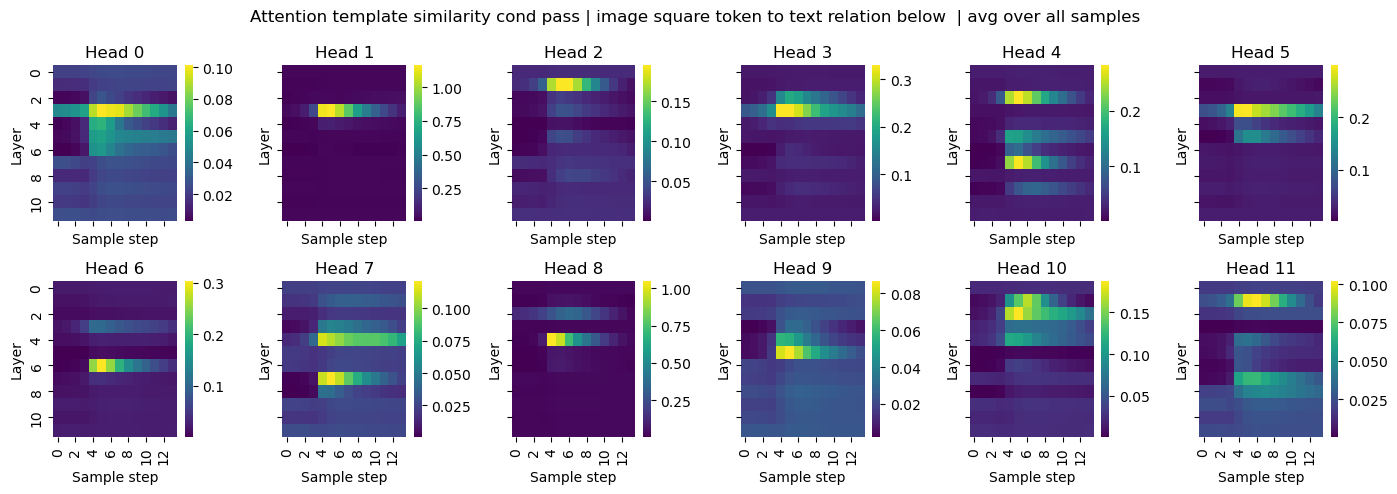

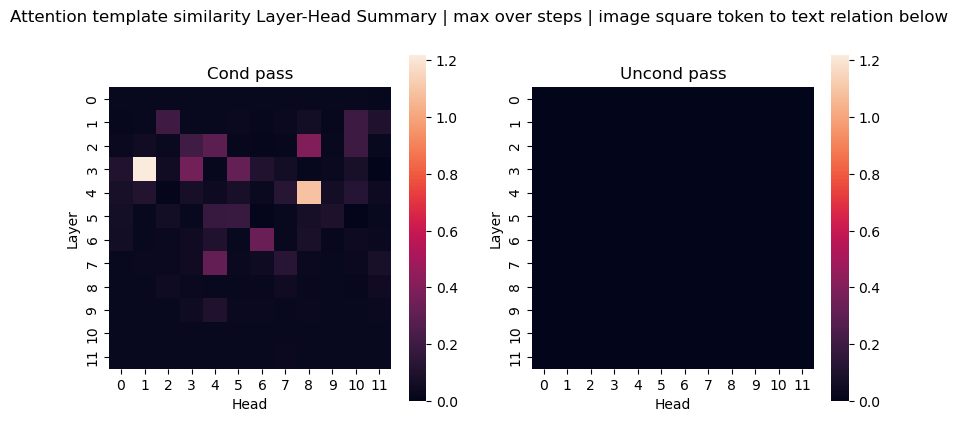


Top Heads image square token to text relation below :
--------------------------------------------------
Top1: L3H1, Score: 1.22
Top2: L4H8, Score: 1.09
Top3: L2H8, Score: 0.40
Top4: L3H3, Score: 0.36
Top5: L6H6, Score: 0.33
Top6: L3H5, Score: 0.31
Top7: L7H4, Score: 0.31
Top8: L2H4, Score: 0.29


In [ ]:
template_type = "image square token to text relation below "
text_square_mask = create_multi_hot_token_mask(token_splits, ["below", ], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

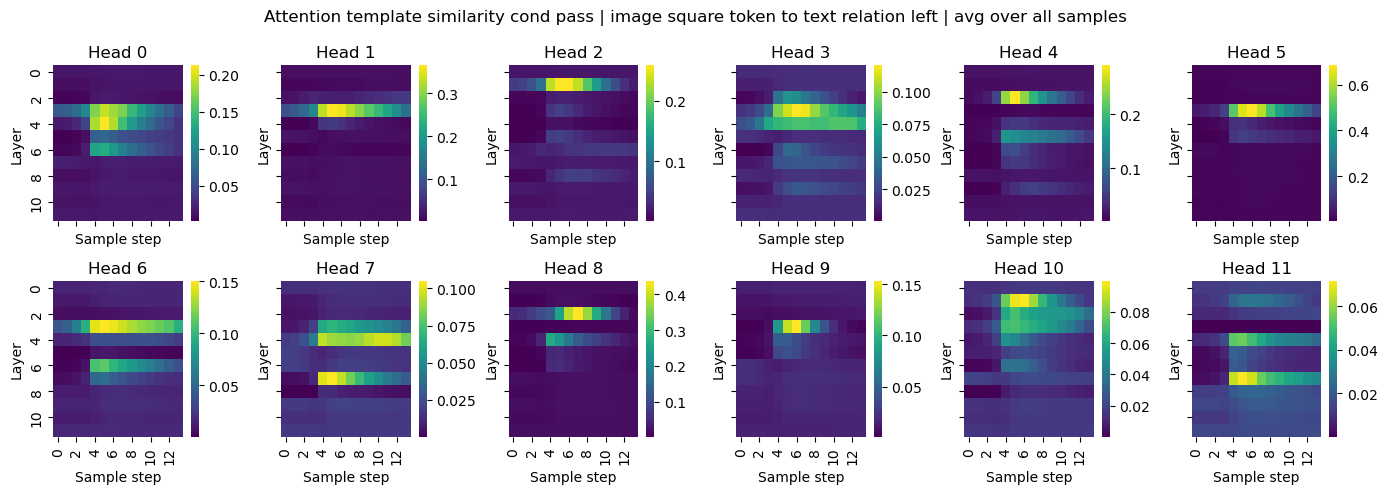

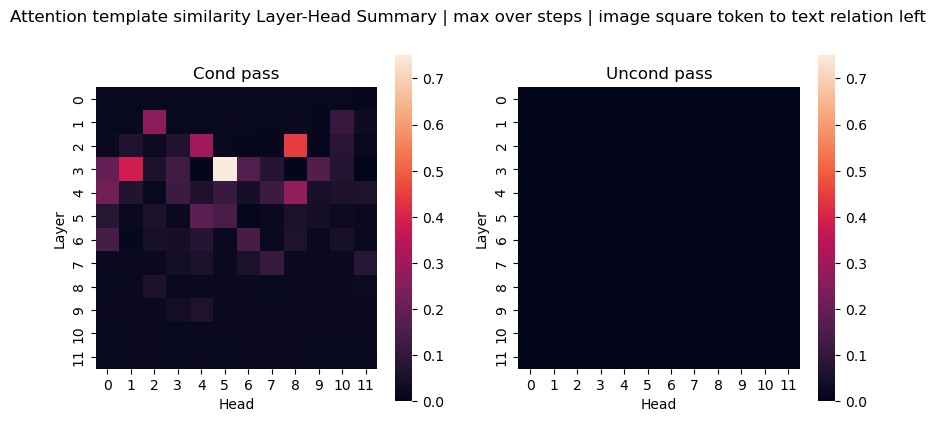


Top Heads image square token to text relation left:
--------------------------------------------------
Top1: L3H5, Score: 0.75
Top2: L2H8, Score: 0.44
Top3: L3H1, Score: 0.39
Top4: L2H4, Score: 0.30
Top5: L4H8, Score: 0.28
Top6: L1H2, Score: 0.27
Top7: L4H0, Score: 0.22
Top8: L3H0, Score: 0.20


In [ ]:
template_type = "image square token to text relation left"
text_square_mask = create_multi_hot_token_mask(token_splits, ["left",], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

In [108]:
prompt

'red triangle below and to the left of blue square'

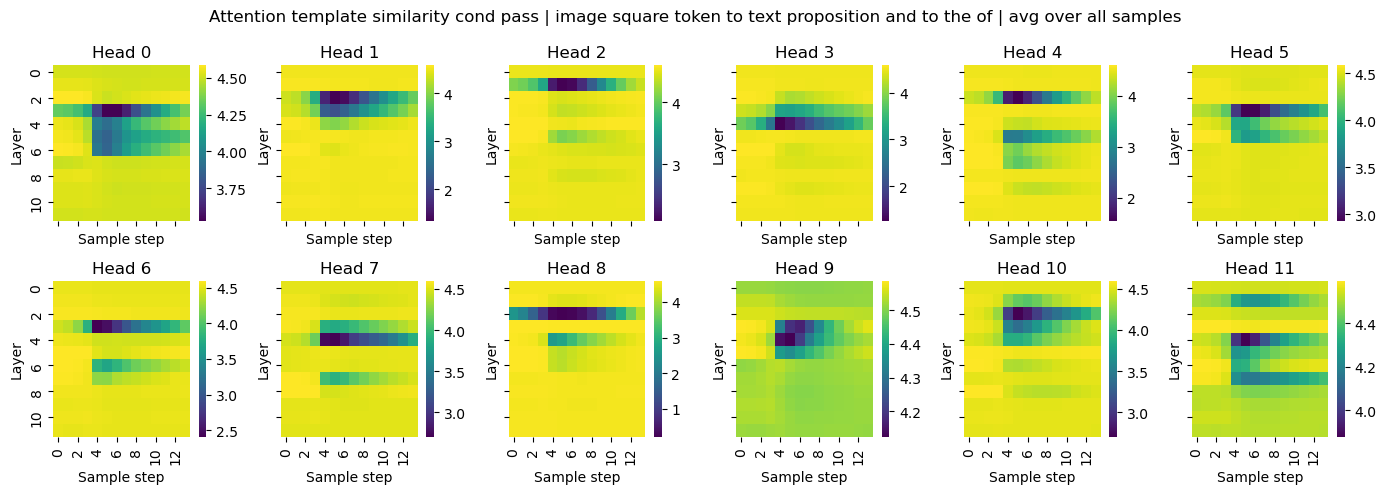

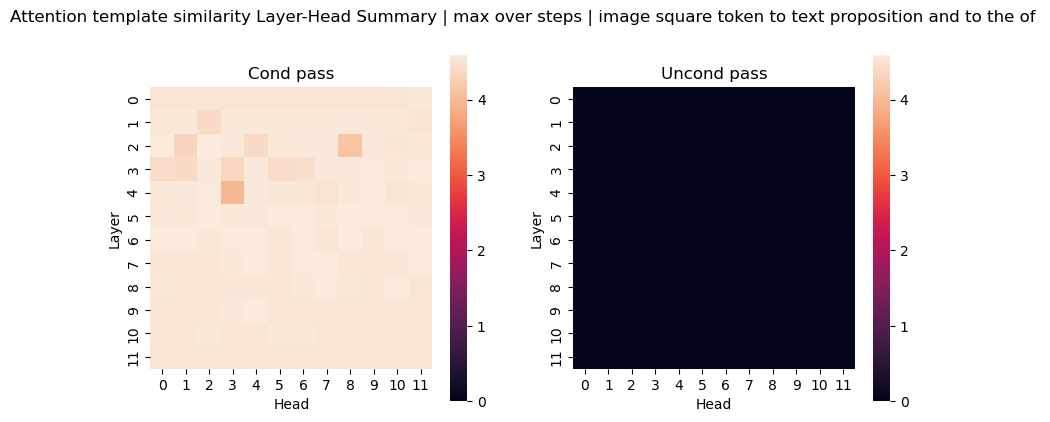

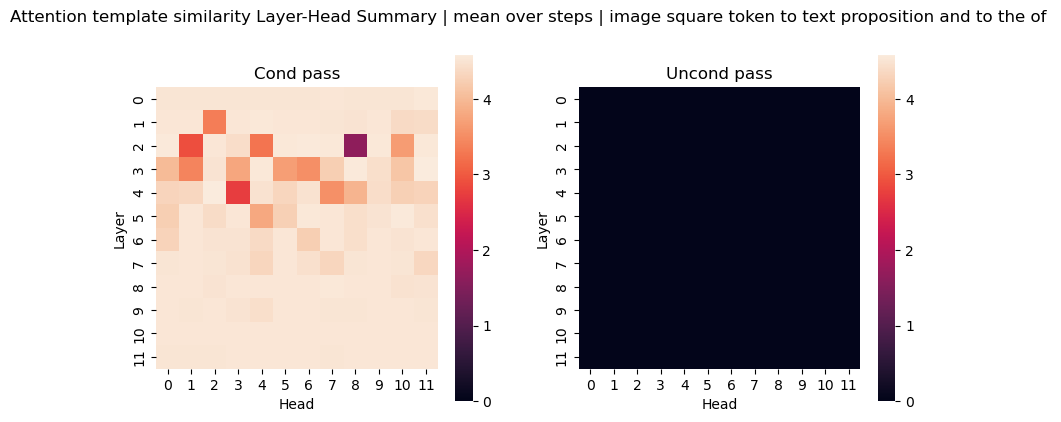


Top Heads image square token to text proposition and to the of:
--------------------------------------------------
Top1: L3H11, Score: 4.59
Top2: L4H2, Score: 4.57
Top3: L5H10, Score: 4.57
Top4: L3H8, Score: 4.56
Top5: L2H6, Score: 4.56
Top6: L2H0, Score: 4.55
Top7: L2H7, Score: 4.55
Top8: L2H9, Score: 4.55


In [ ]:
template_type = "image square token to text proposition and to the of"
text_square_mask = create_multi_hot_token_mask(token_splits, ["and", "to", "the", "of"], seq_len=20)
cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @  text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
fig, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="mean", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

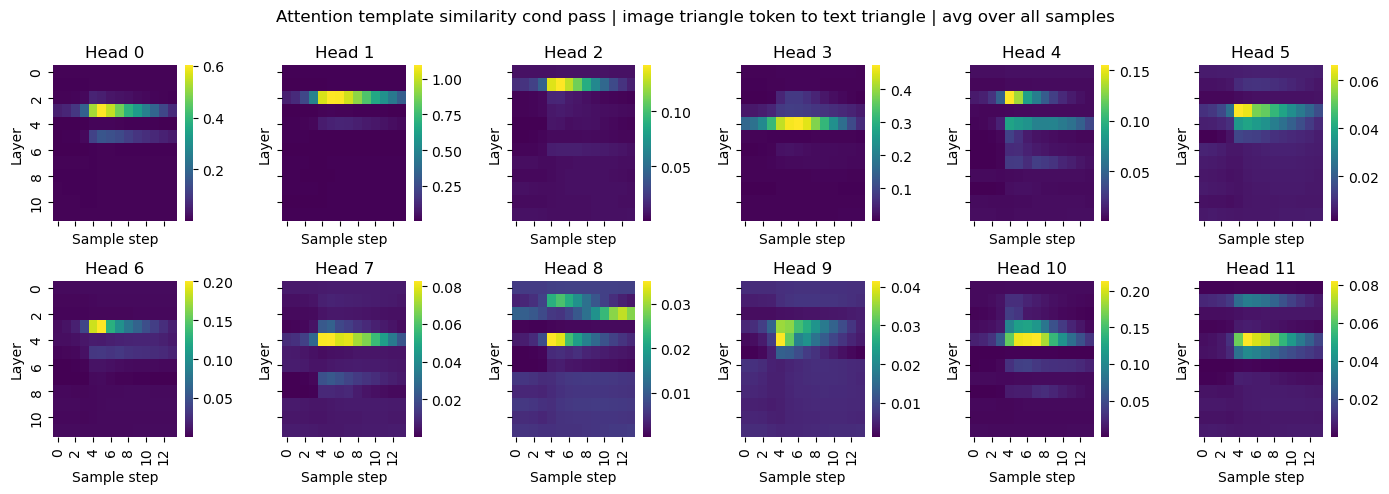

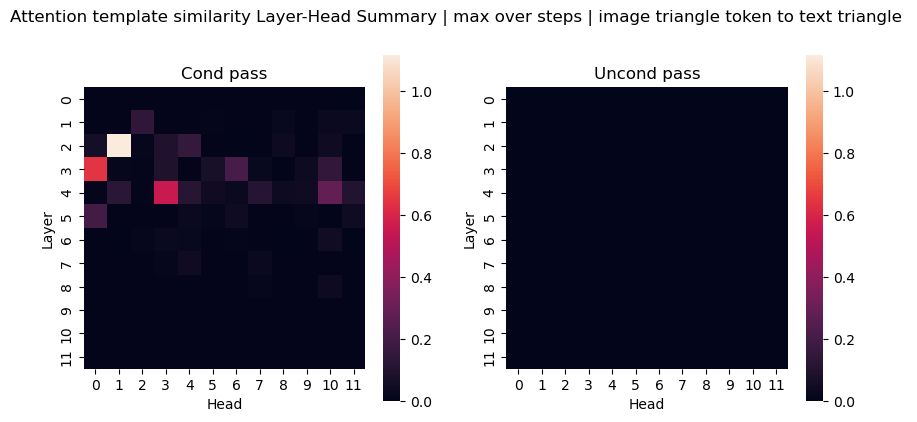


Top Heads image triangle token to text triangle:
--------------------------------------------------
Top1: L2H1, Score: 1.12
Top2: L3H0, Score: 0.64
Top3: L4H3, Score: 0.55
Top4: L4H10, Score: 0.28
Top5: L3H6, Score: 0.21
Top6: L5H0, Score: 0.20
Top7: L2H4, Score: 0.16
Top8: L3H10, Score: 0.14


In [153]:
template_type = "image triangle token to text triangle"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["triangle"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

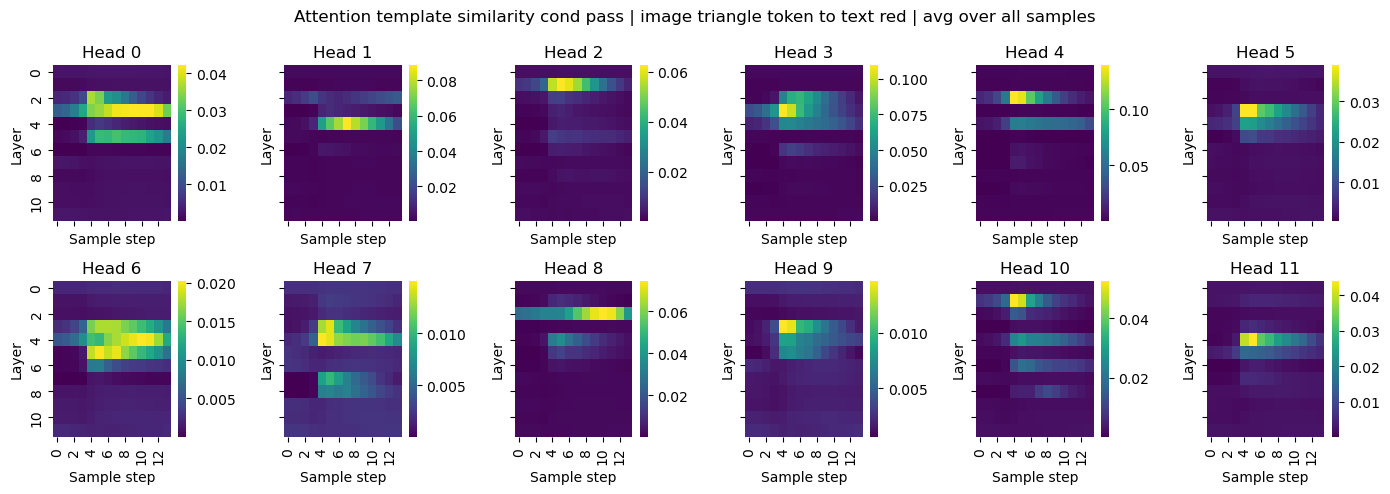

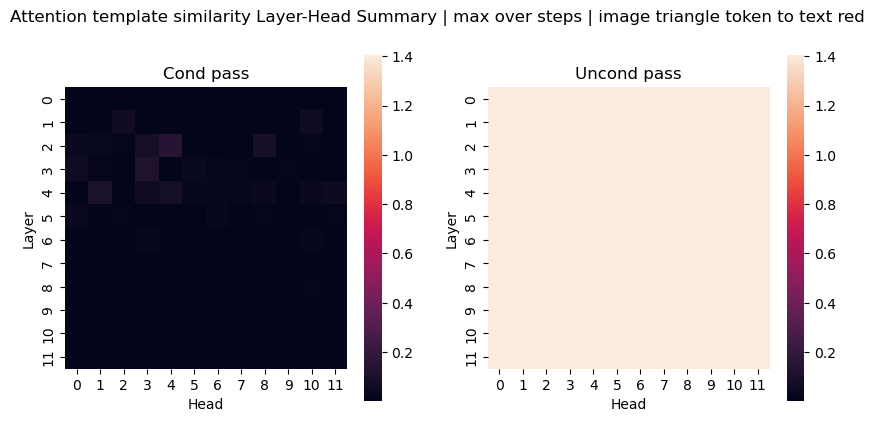

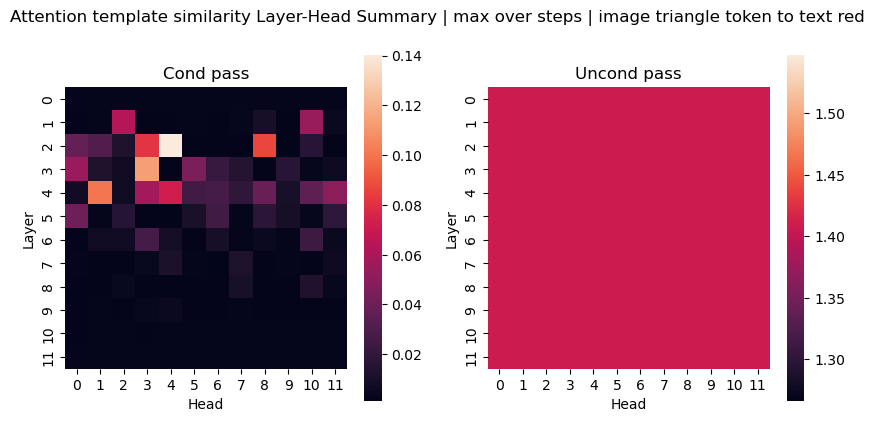


Top Heads image triangle token to text red:
--------------------------------------------------
Top1: L2H4, Score: 0.14
Top2: L3H3, Score: 0.11
Top3: L4H1, Score: 0.10
Top4: L2H8, Score: 0.09
Top5: L2H3, Score: 0.08
Top6: L4H4, Score: 0.07
Top7: L1H2, Score: 0.06
Top8: L4H3, Score: 0.06


In [155]:
template_type = "image triangle token to text red"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["red"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=False);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

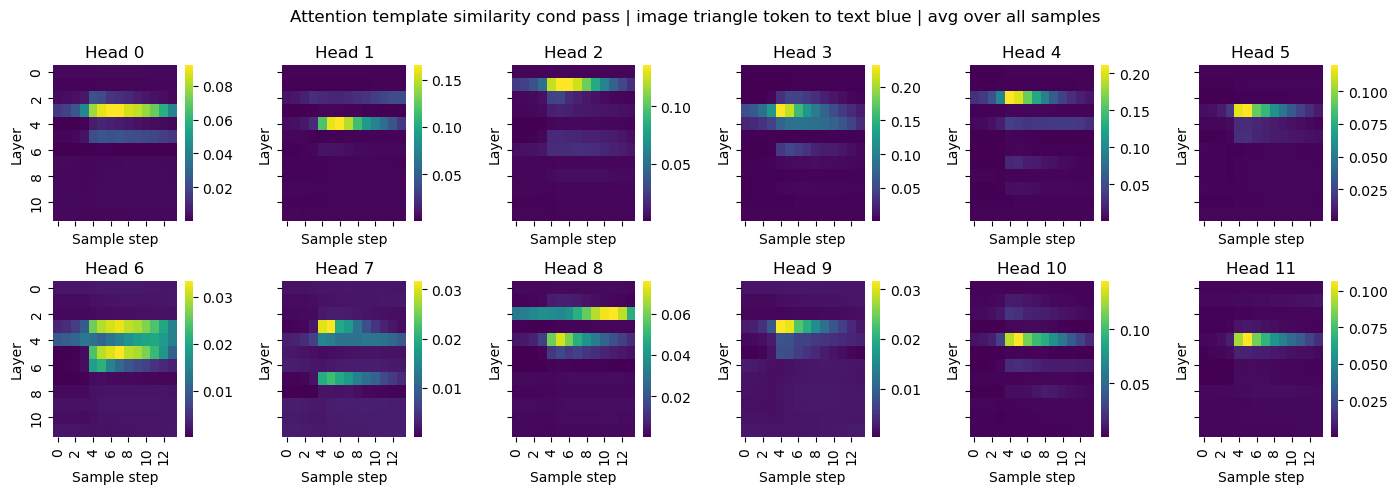

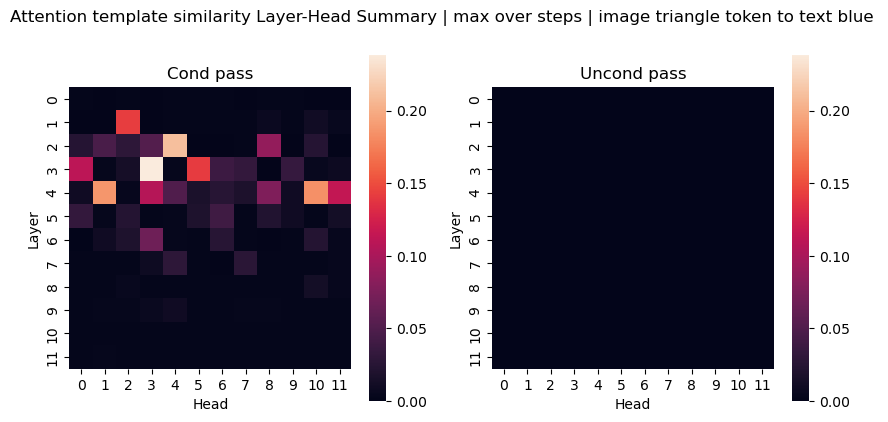


Top Heads image triangle token to text blue:
--------------------------------------------------
Top1: L3H3, Score: 0.24
Top2: L2H4, Score: 0.21
Top3: L4H1, Score: 0.19
Top4: L4H10, Score: 0.18
Top5: L1H2, Score: 0.14
Top6: L3H5, Score: 0.14
Top7: L4H11, Score: 0.11
Top8: L3H0, Score: 0.11


In [156]:
template_type = "image triangle token to text blue"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["blue"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

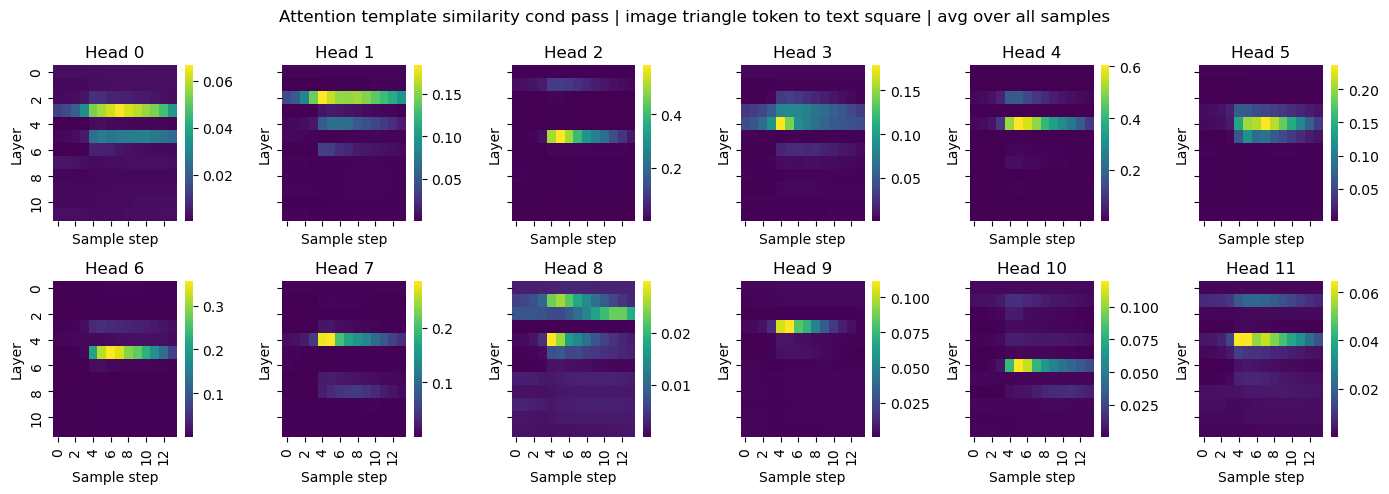

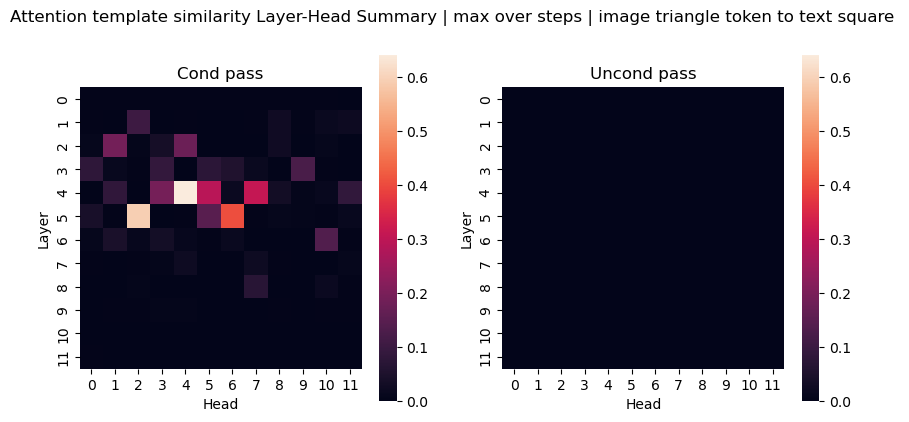


Top Heads image triangle token to text square:
--------------------------------------------------
Top1: L4H4, Score: 0.64
Top2: L5H2, Score: 0.59
Top3: L5H6, Score: 0.41
Top4: L4H7, Score: 0.31
Top5: L4H5, Score: 0.29
Top6: L4H3, Score: 0.19
Top7: L2H1, Score: 0.19
Top8: L2H4, Score: 0.18


In [157]:
template_type = "image triangle token to text square"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["square"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

In [158]:
prompt

'red triangle below and to the left of blue square'

In [184]:
prompt

'red triangle below and to the left of blue square'

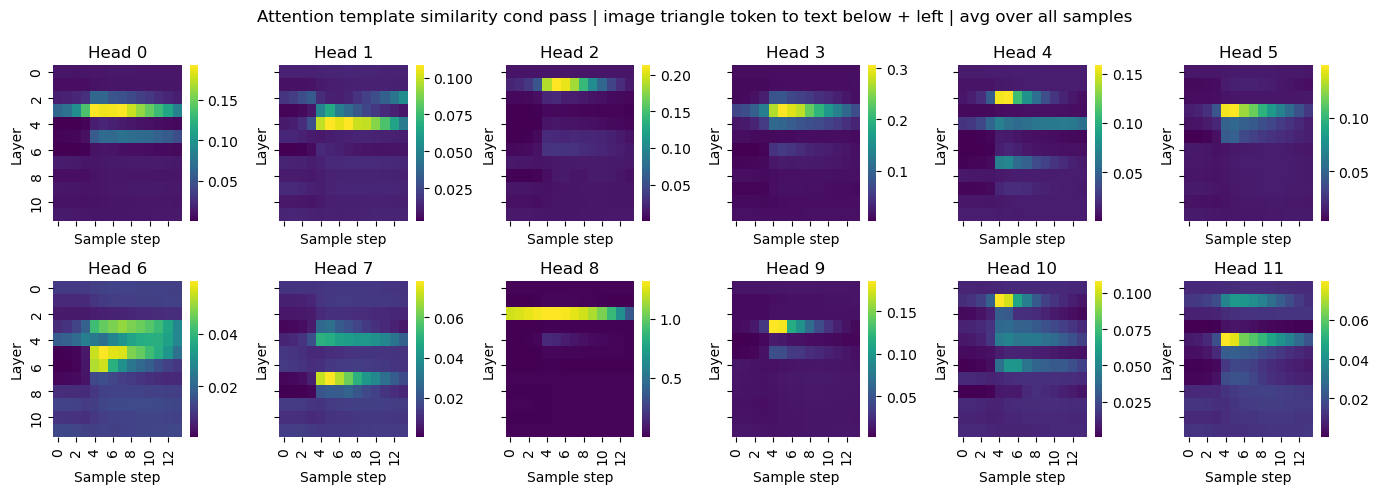

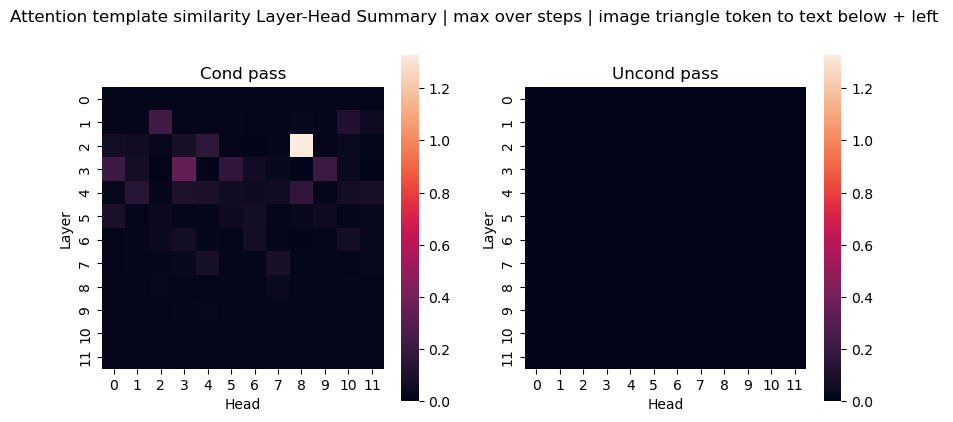


Top Heads image triangle token to text below + left:
--------------------------------------------------
Top1: L2H8, Score: 1.33
Top2: L3H3, Score: 0.34
Top3: L1H2, Score: 0.22
Top4: L3H0, Score: 0.21
Top5: L3H9, Score: 0.20
Top6: L4H8, Score: 0.17
Top7: L3H5, Score: 0.17
Top8: L2H4, Score: 0.16


In [159]:
template_type = "image triangle token to text below + left"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["below", "left"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

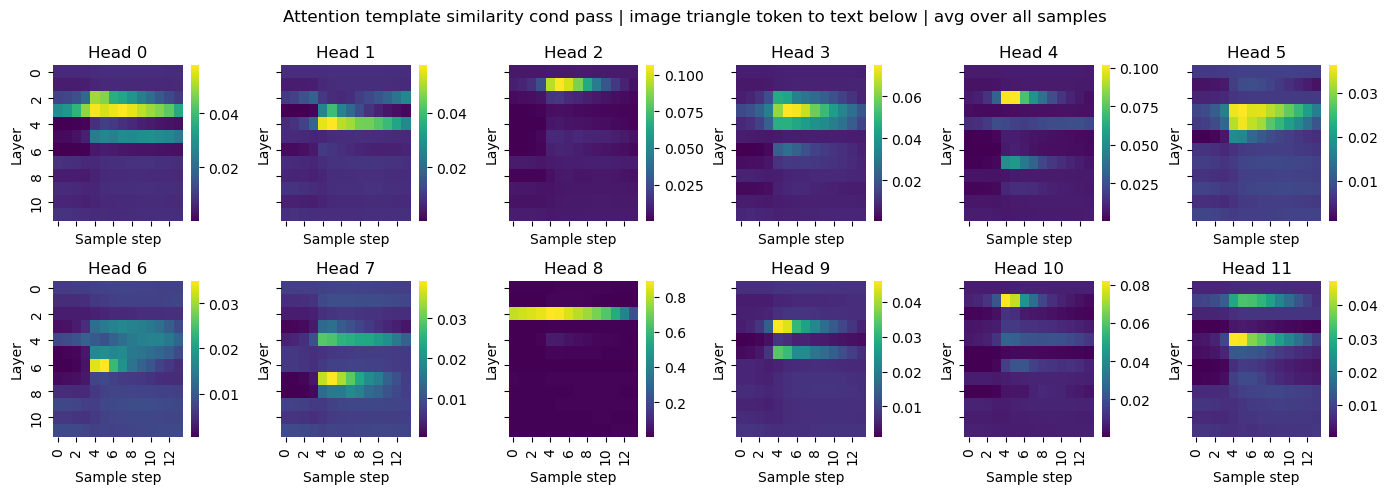

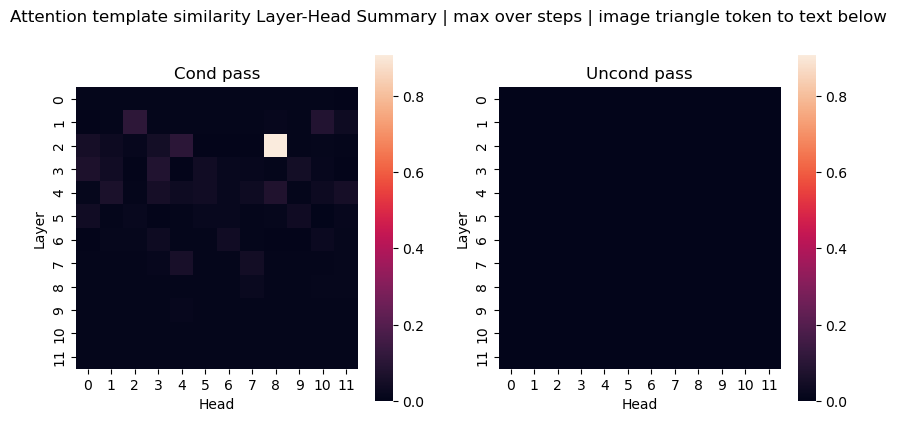


Top Heads image triangle token to text below:
--------------------------------------------------
Top1: L2H8, Score: 0.91
Top2: L1H2, Score: 0.11
Top3: L2H4, Score: 0.10
Top4: L1H10, Score: 0.08
Top5: L3H3, Score: 0.08
Top6: L4H8, Score: 0.07
Top7: L3H0, Score: 0.07
Top8: L4H1, Score: 0.07


In [161]:
template_type = "image triangle token to text below"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["below"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

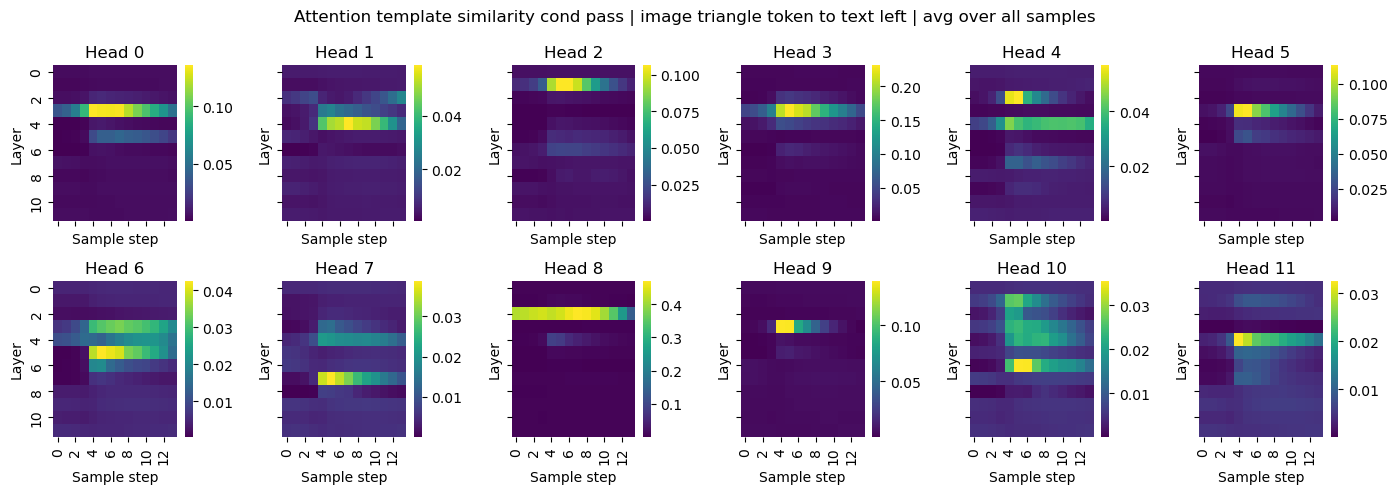

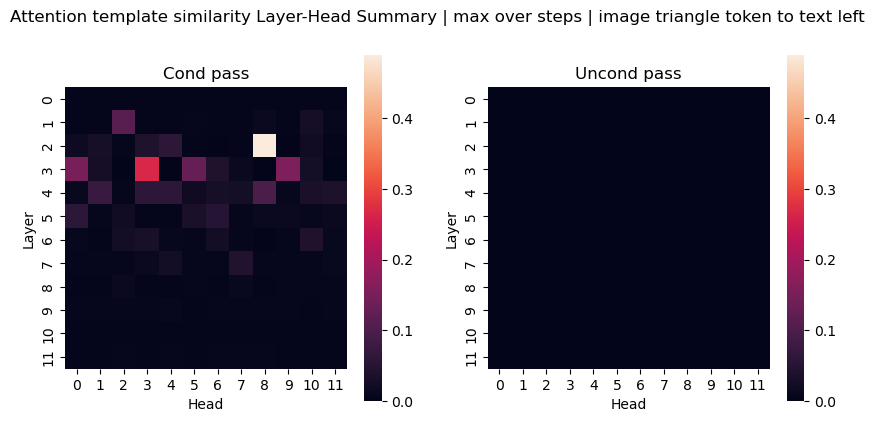


Top Heads image triangle token to text left:
--------------------------------------------------
Top1: L2H8, Score: 0.49
Top2: L3H3, Score: 0.27
Top3: L3H9, Score: 0.16
Top4: L3H0, Score: 0.15
Top5: L3H5, Score: 0.13
Top6: L1H2, Score: 0.11
Top7: L4H8, Score: 0.10
Top8: L4H1, Score: 0.07


In [160]:
template_type = "image triangle token to text left"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["left"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

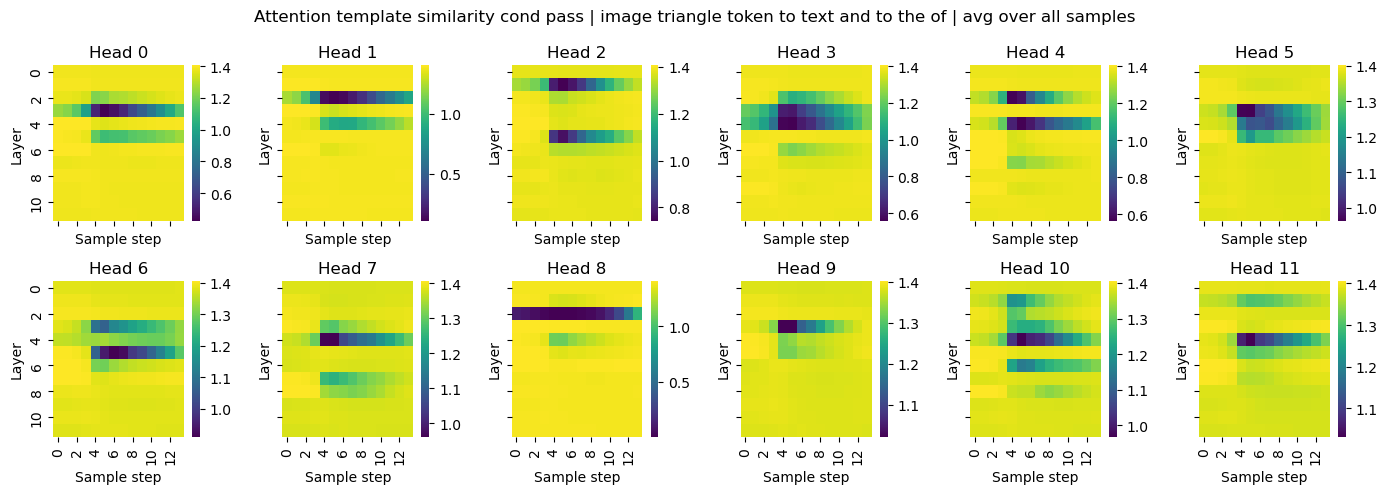

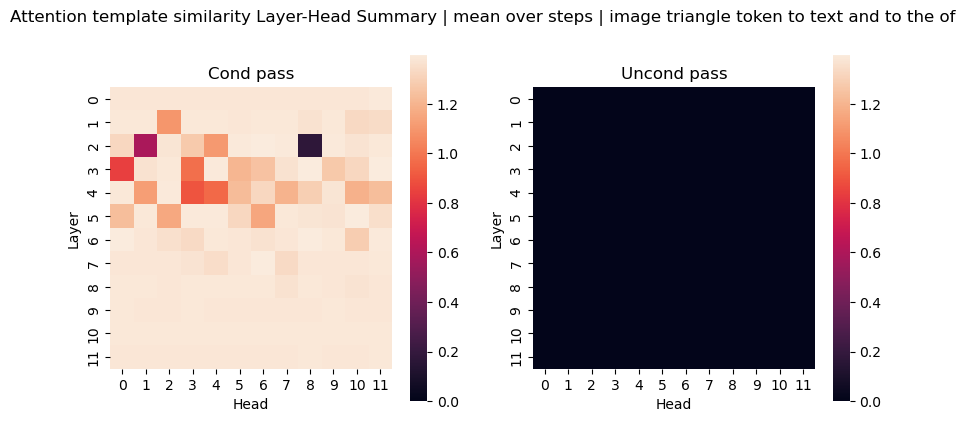


Top Heads image triangle token to text and to the of:
--------------------------------------------------
Top1: L6H8, Score: 1.40
Top2: L3H8, Score: 1.40
Top3: L3H11, Score: 1.40
Top4: L7H6, Score: 1.39
Top5: L6H0, Score: 1.39
Top6: L2H6, Score: 1.39
Top7: L5H10, Score: 1.39
Top8: L6H11, Score: 1.39


In [163]:
template_type = "image triangle token to text and to the of"
text_triangle_mask = create_multi_hot_token_mask(token_splits, ["and", "to", "the", "of"], seq_len=20)
cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_triangle_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="mean", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

### Attention from background

In [164]:
def get_background_pos_obj_neg_mask(obj_df, object_masks):
    """
    All objects are positive, others are negative including background.
    Returns positive mask and negative mask.
    """
    
    if len(obj_df) != 2:
        # TODO: Not sure how to handle case when there are not exactly 2 objects
        return np.array([]), np.array([])
    
    mask_dtype = object_masks[0].dtype
    object_token_mask = np.zeros_like(object_masks[0], dtype=mask_dtype)
    for i in range(len(obj_df)):
        if mask_dtype == bool:
            object_token_mask = object_token_mask | object_masks[i]
        else:
            object_token_mask = object_token_mask + object_masks[i]
            
    negative_mask = object_token_mask
    if mask_dtype == bool:
        positive_mask = ~object_token_mask
    else:
        positive_mask = np.clip(1 - object_token_mask, 0, 1)
    return positive_mask, negative_mask

In [165]:
background_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_background_pos_obj_neg_mask)

In [167]:
background_cmb_img_msks_vec.shape

torch.Size([32, 1, 64])

In [168]:
background_cmb_img_msks_vec[0,0].reshape(8,8)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 0.7961, 1.0000, 1.0000, 1.0000]])

In [ ]:
pipeline.transformer.transformer_blocks[0]

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x BasicTransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0):

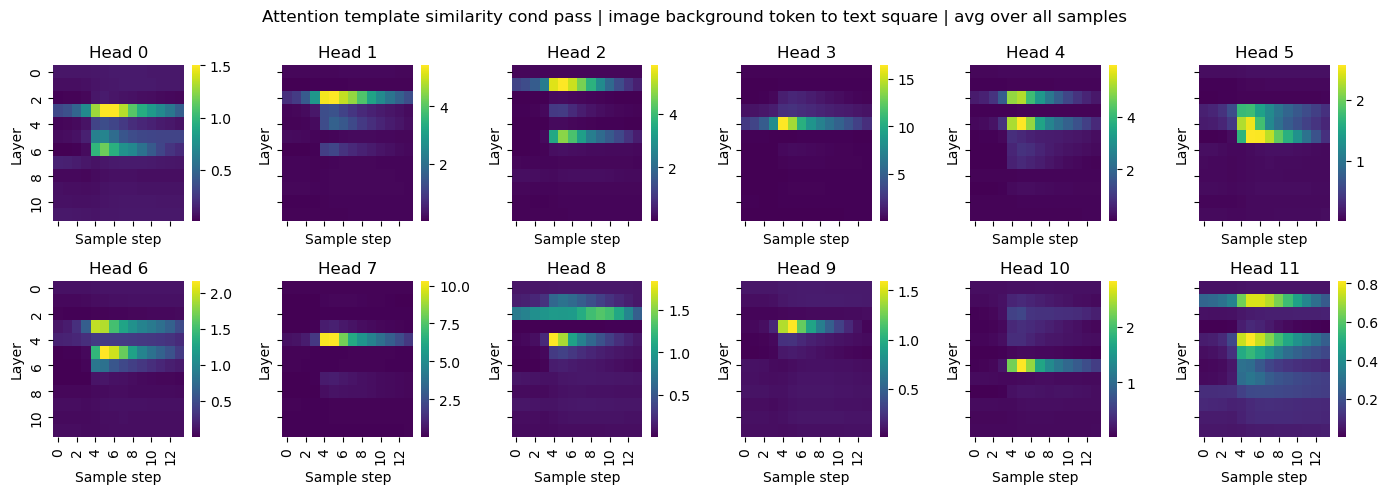

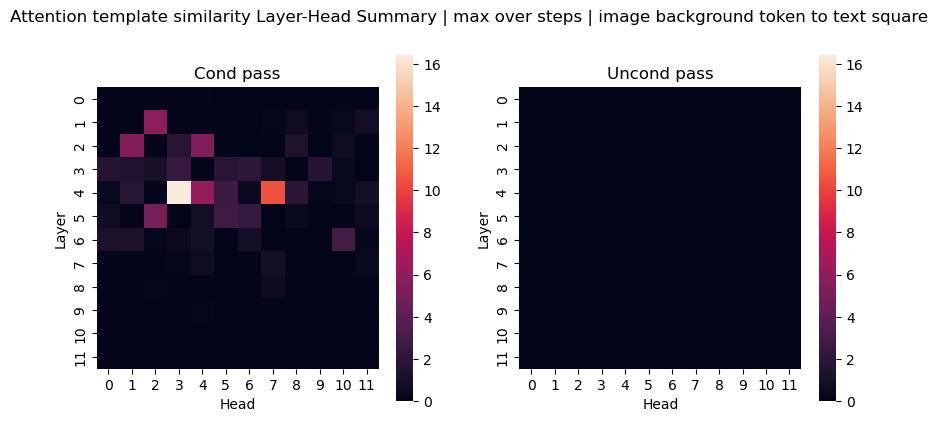


Top Heads image background token to text square:
--------------------------------------------------
Top1: L4H3, Score: 16.43
Top2: L4H7, Score: 10.52
Top3: L4H4, Score: 6.06
Top4: L1H2, Score: 5.79
Top5: L2H1, Score: 5.49
Top6: L2H4, Score: 5.32
Top7: L5H2, Score: 4.90
Top8: L6H10, Score: 2.94


In [169]:
template_type = "image background token to text square"
text_square_mask = create_multi_hot_token_mask(token_splits, ["square"], seq_len=20)
cross_attn_template = background_cmb_img_msks_vec[:, :, :, None] @ text_square_mask.float().flatten()[None, :] 
template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");

### Mass produce

In [173]:
prompt_dir = join(figdir, prompt.replace(" ", "_"))
os.makedirs(prompt_dir, exist_ok=True)
from contextlib import redirect_stdout

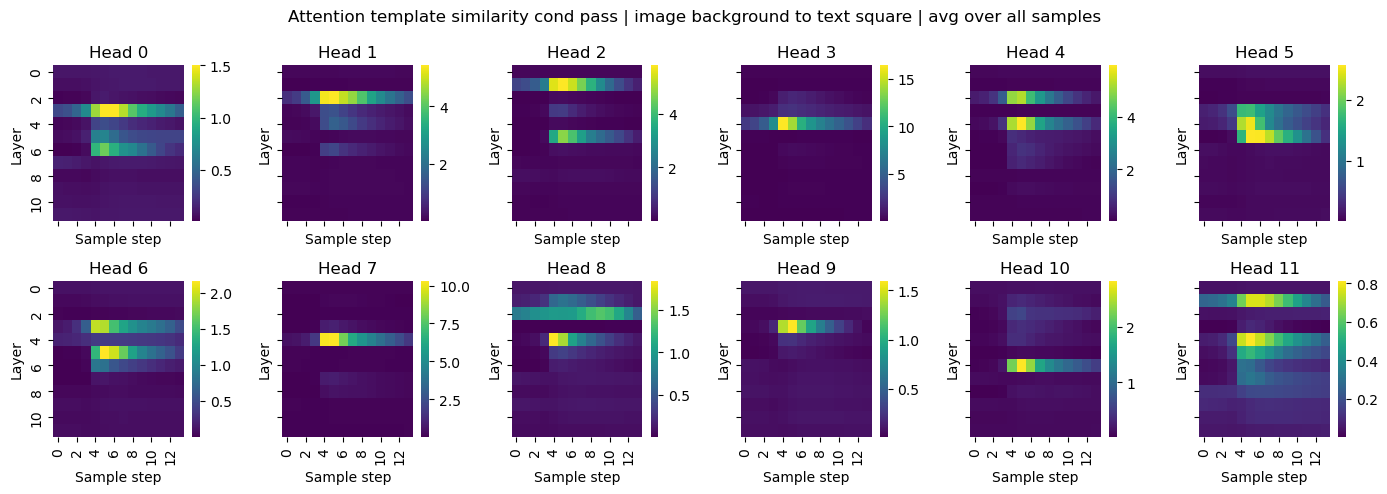

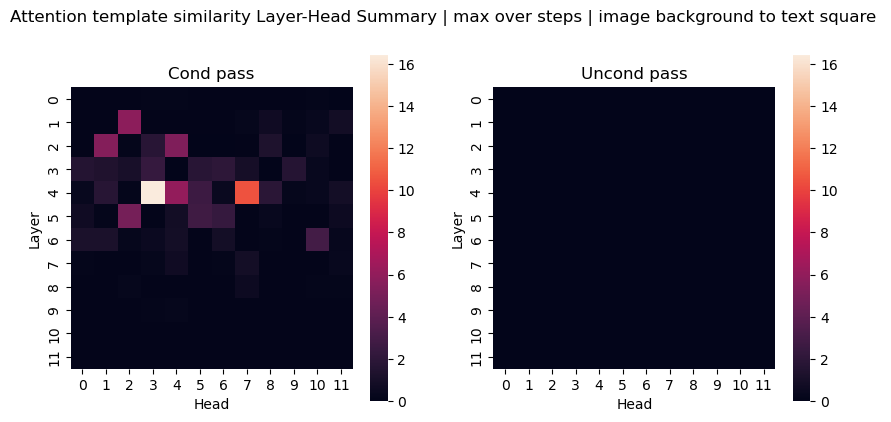


Top Heads image background to text square:
--------------------------------------------------
Top1: L4H3, Score: 16.43
Top2: L4H7, Score: 10.52
Top3: L4H4, Score: 6.06
Top4: L1H2, Score: 5.79
Top5: L2H1, Score: 5.49
Top6: L2H4, Score: 5.32
Top7: L5H2, Score: 4.90
Top8: L6H10, Score: 2.94
Saved image background to text square to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


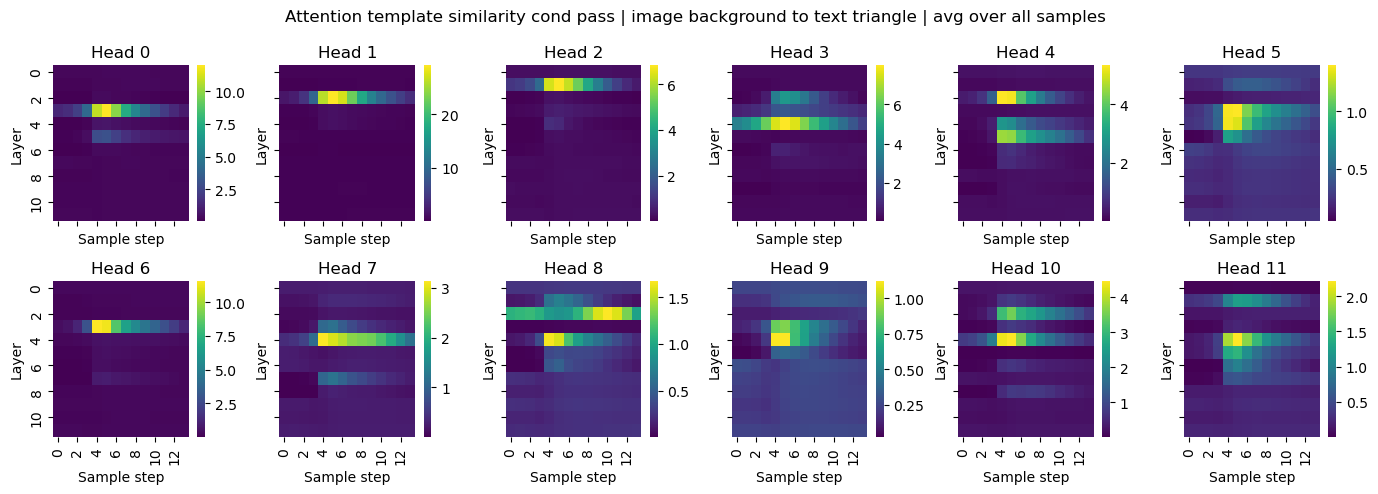

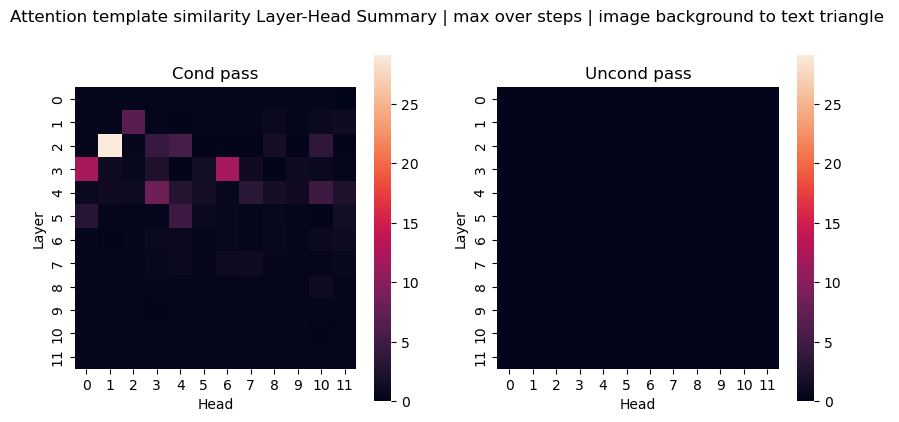


Top Heads image background to text triangle:
--------------------------------------------------
Top1: L2H1, Score: 29.13
Top2: L3H0, Score: 12.06
Top3: L3H6, Score: 11.75
Top4: L4H3, Score: 8.12
Top5: L1H2, Score: 6.82
Top6: L2H4, Score: 5.45
Top7: L5H4, Score: 4.67
Top8: L4H10, Score: 4.59
Saved image background to text triangle to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


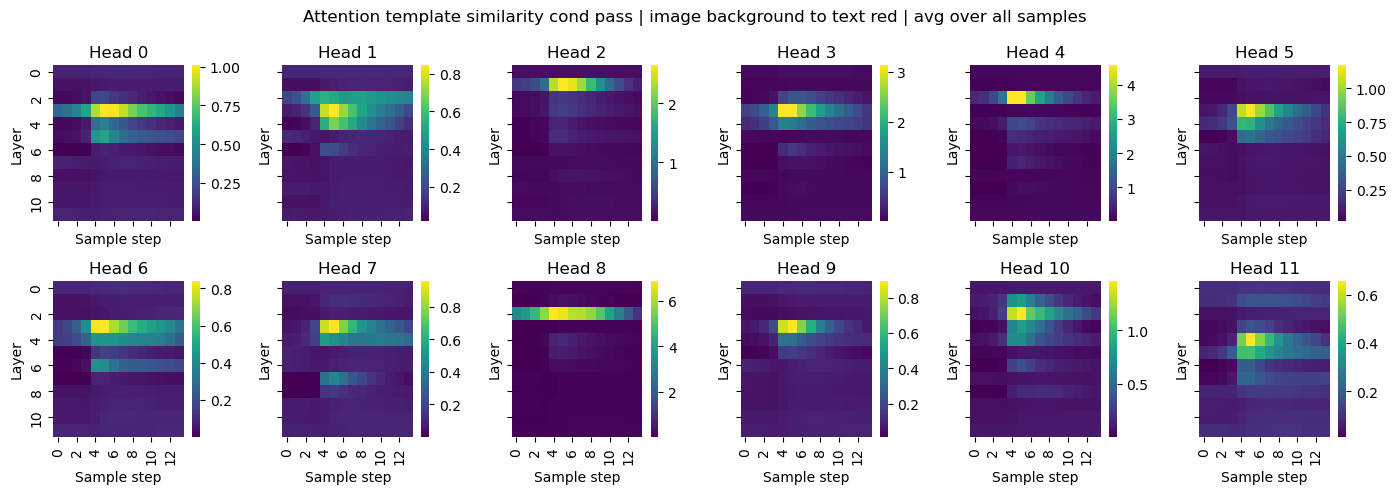

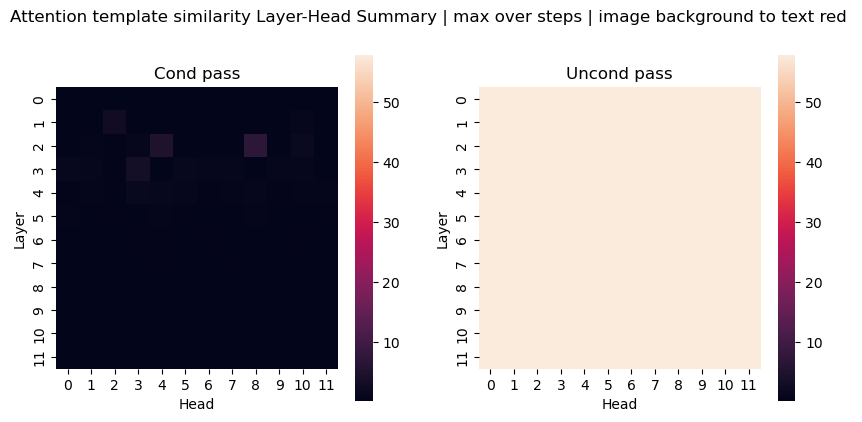


Top Heads image background to text red:
--------------------------------------------------
Top1: L2H8, Score: 6.91
Top2: L2H4, Score: 4.67
Top3: L3H3, Score: 3.19
Top4: L1H2, Score: 2.64
Top5: L2H10, Score: 1.47
Top6: L4H3, Score: 1.37
Top7: L3H5, Score: 1.18
Top8: L4H4, Score: 1.06
Saved image background to text red to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


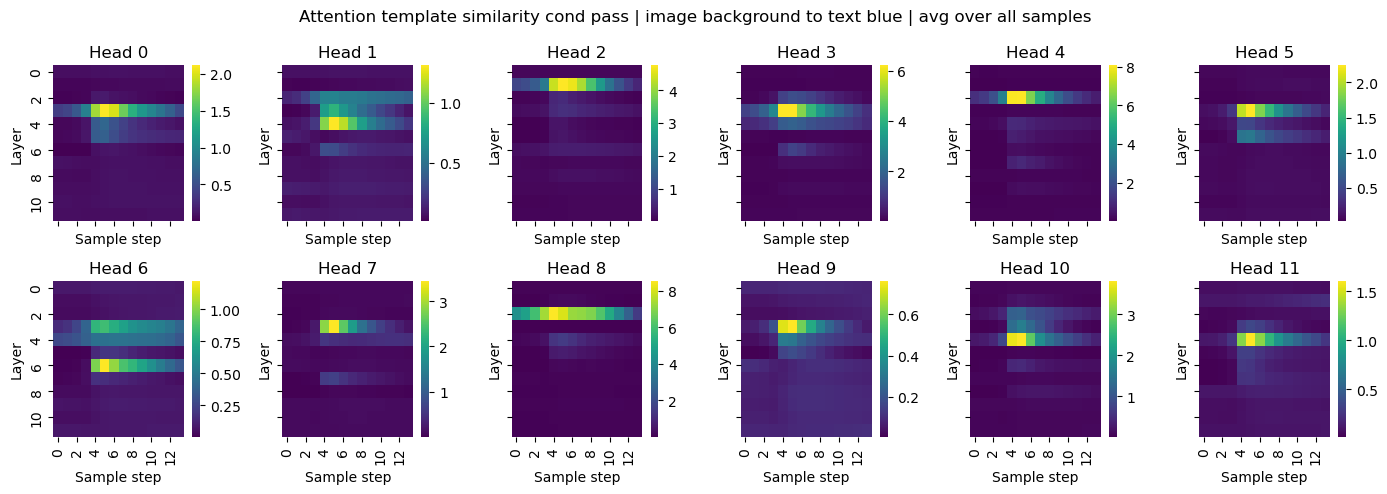

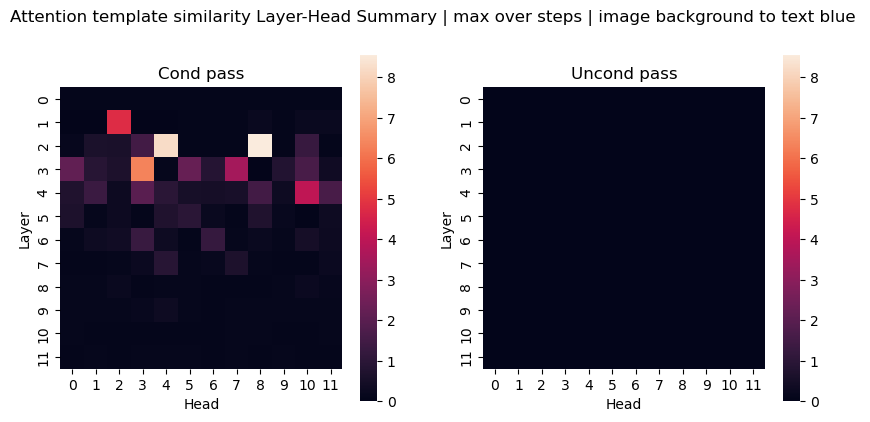


Top Heads image background to text blue:
--------------------------------------------------
Top1: L2H8, Score: 8.56
Top2: L2H4, Score: 8.20
Top3: L3H3, Score: 6.32
Top4: L1H2, Score: 4.75
Top5: L4H10, Score: 4.02
Top6: L3H7, Score: 3.51
Top7: L3H5, Score: 2.25
Top8: L3H0, Score: 2.17
Saved image background to text blue to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


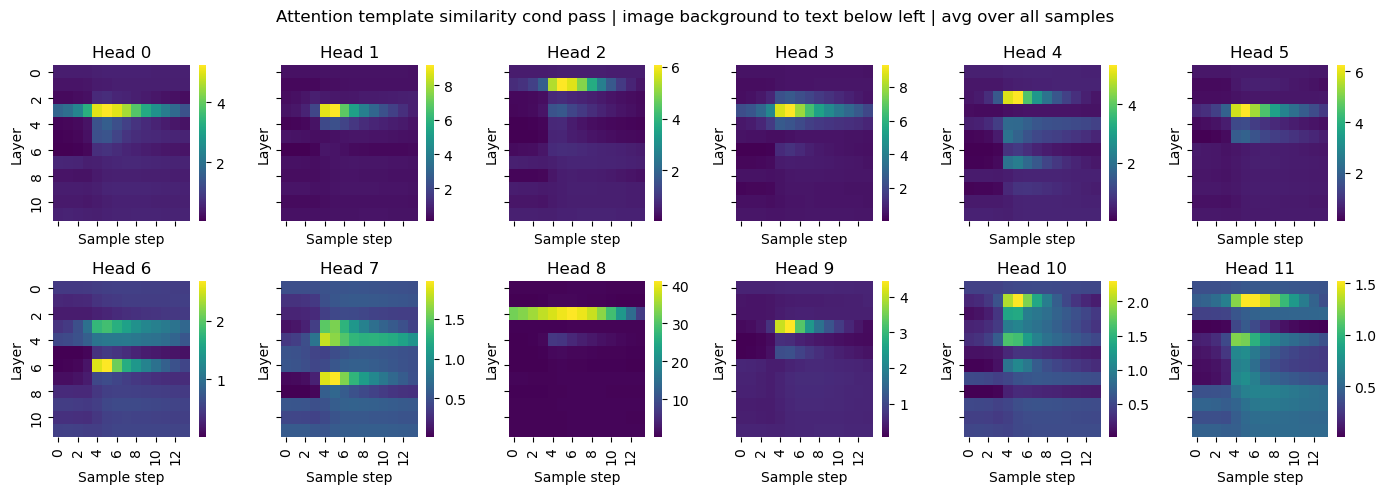

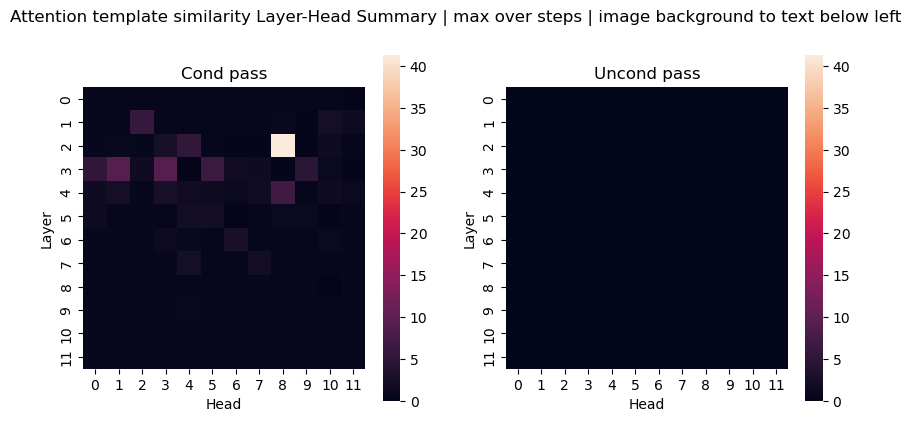


Top Heads image background to text below left:
--------------------------------------------------
Top1: L2H8, Score: 41.34
Top2: L3H1, Score: 9.28
Top3: L3H3, Score: 9.28
Top4: L4H8, Score: 6.87
Top5: L3H5, Score: 6.30
Top6: L1H2, Score: 6.06
Top7: L2H4, Score: 5.43
Top8: L3H0, Score: 5.29
Saved image background to text below left to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


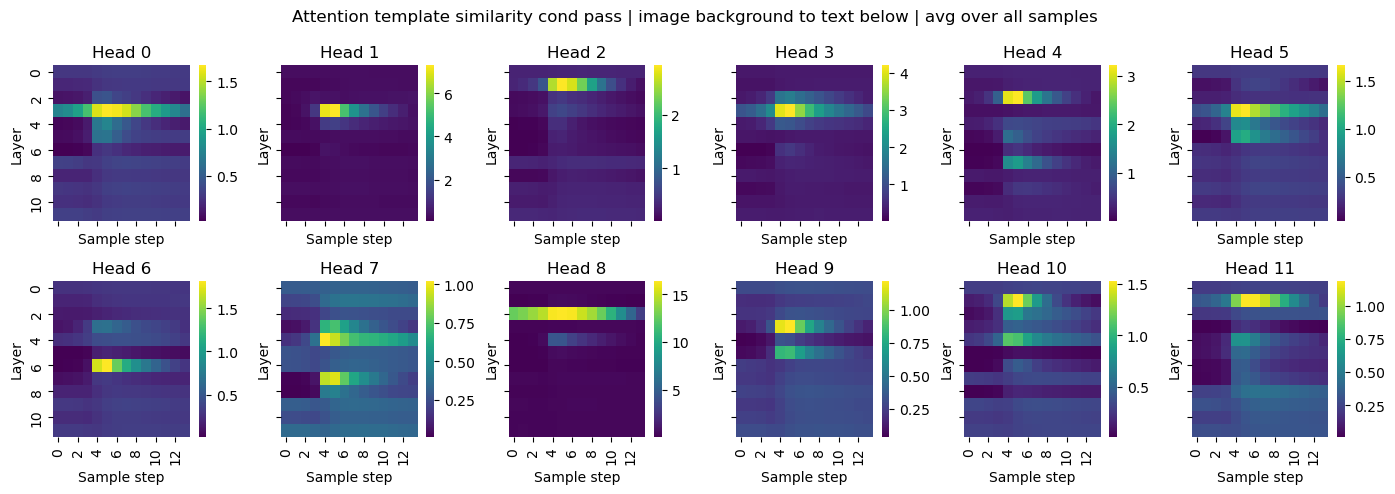

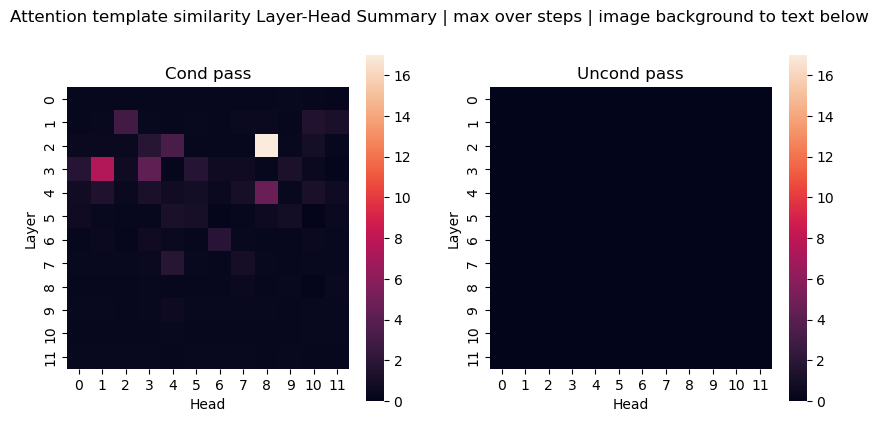


Top Heads image background to text below:
--------------------------------------------------
Top1: L2H8, Score: 17.00
Top2: L3H1, Score: 7.47
Top3: L4H8, Score: 4.62
Top4: L3H3, Score: 4.22
Top5: L2H4, Score: 3.27
Top6: L1H2, Score: 2.93
Top7: L6H6, Score: 1.85
Top8: L2H3, Score: 1.77
Saved image background to text below to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


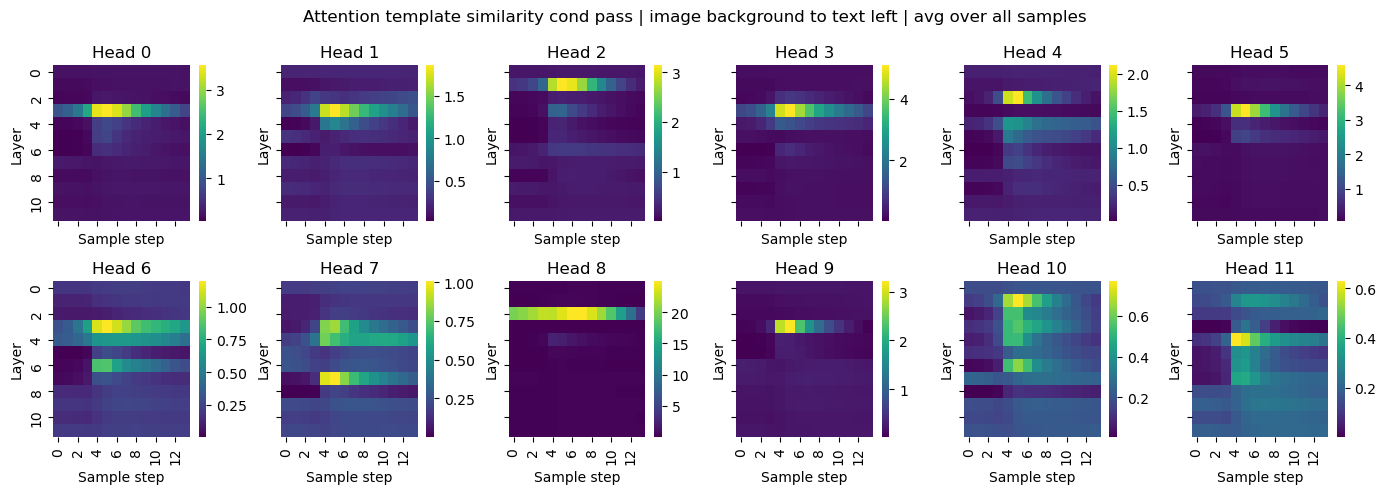

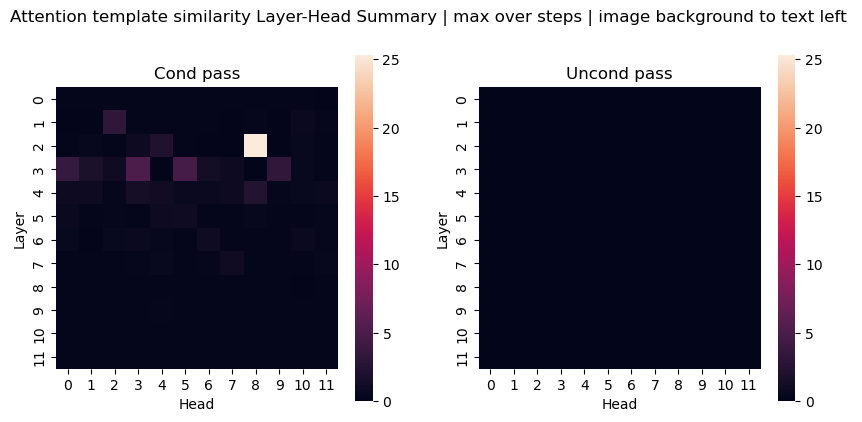


Top Heads image background to text left:
--------------------------------------------------
Top1: L2H8, Score: 25.36
Top2: L3H3, Score: 5.08
Top3: L3H5, Score: 4.64
Top4: L3H0, Score: 3.62
Top5: L3H9, Score: 3.31
Top6: L1H2, Score: 3.13
Top7: L4H8, Score: 2.34
Top8: L2H4, Score: 2.15
Saved image background to text left to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


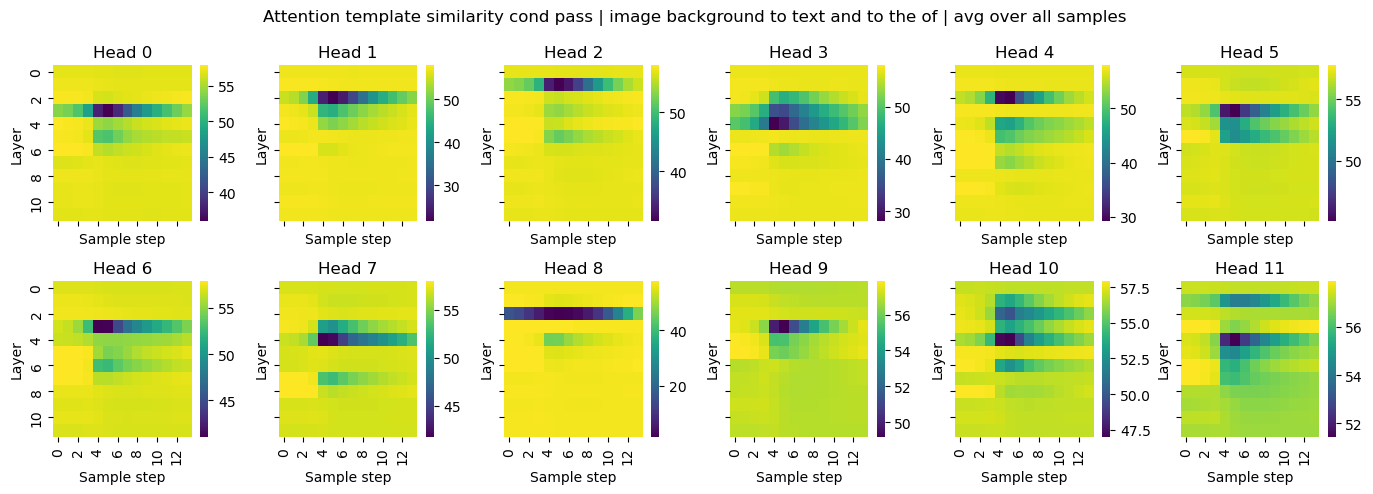

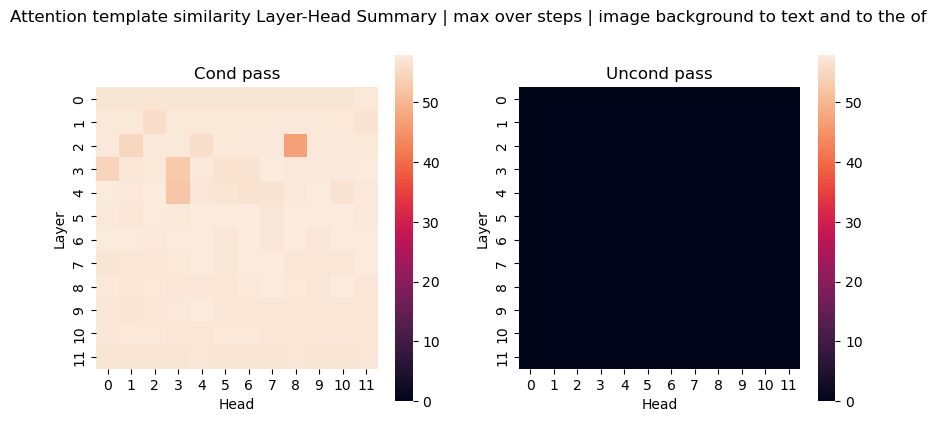


Top Heads image background to text and to the of:
--------------------------------------------------
Top1: L8H7, Score: 57.98
Top2: L6H4, Score: 57.96
Top3: L8H10, Score: 57.95
Top4: L7H4, Score: 57.94
Top5: L5H2, Score: 57.93
Top6: L6H8, Score: 57.93
Top7: L5H6, Score: 57.93
Top8: L4H2, Score: 57.92
Saved image background to text and to the of to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


In [175]:
imgtoken_type = "background"
background_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_background_pos_obj_neg_mask)
for text_targets in [["square"], 
                     ["triangle"], 
                     ["red"], 
                     ["blue"],
                     ["below", "left",],
                     ["below", ],
                     ["left", ],
                     ["and", "to", "the", "of"],
                     ]:
    template_type = f"image {imgtoken_type} to text {' '.join(text_targets)}"
    text_mask = create_multi_hot_token_mask(token_splits, text_targets, seq_len=20)
    cross_attn_template = background_cmb_img_msks_vec[:, :, :, None] @ text_mask.float().flatten()[None, :] 
    template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                            title_str=f"Attention template similarity cond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    saveallforms(prompt_dir, f"cross_attn_layer_head_step_cond_heatmap_{template_type.replace(' ', '_')}", figh=fig)
    figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
    saveallforms(prompt_dir, f"cross_attn_layer_head_maxstep_summary_{template_type.replace(' ', '_')}", figh=figh)
    print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");
    with open(join(prompt_dir, f"top_cross_attn_heads_{template_type.replace(' ', '_')}.txt"), "w") as f:
        with redirect_stdout(f):
            print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");
    print(f"Saved {template_type} to {prompt_dir}")
    plt.close("all")

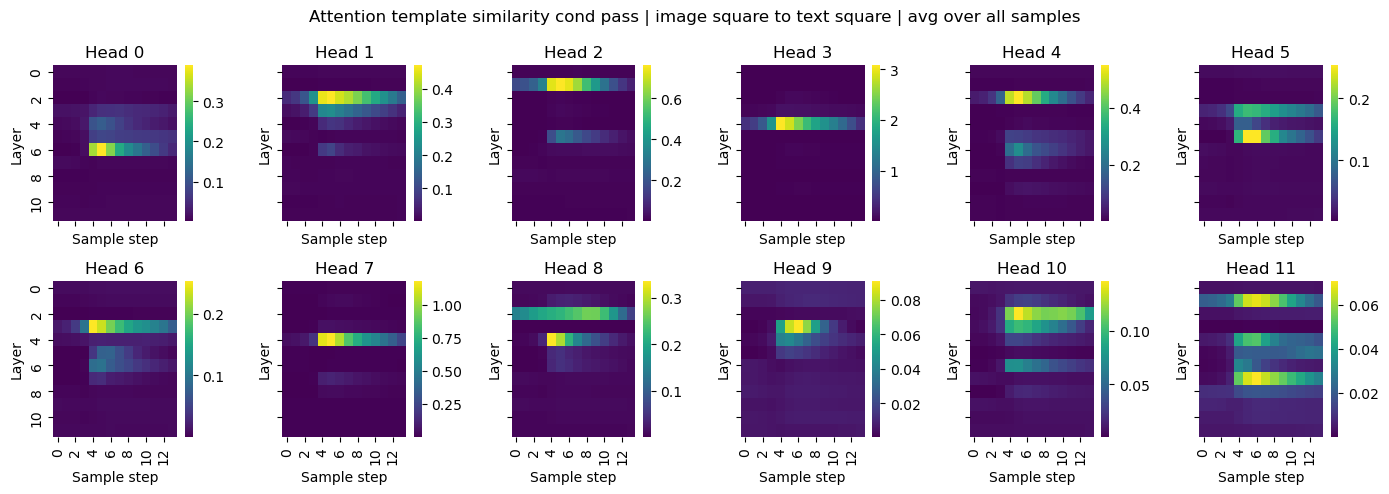

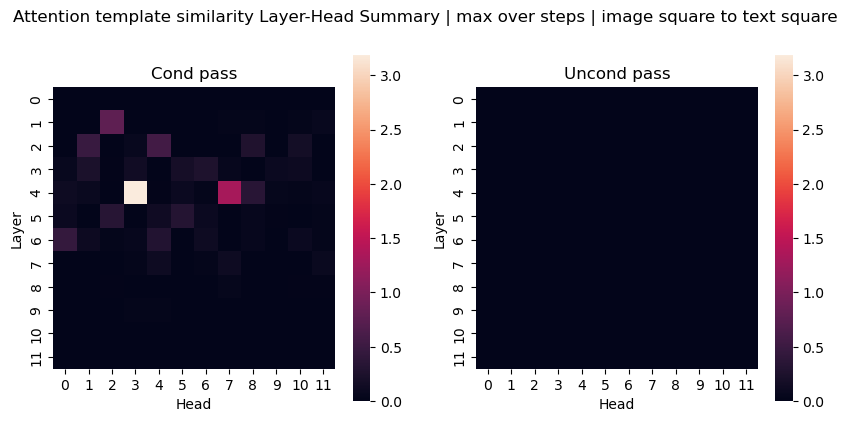


Top Heads image square to text square:
--------------------------------------------------
Top1: L4H3, Score: 3.19
Top2: L4H7, Score: 1.32
Top3: L1H2, Score: 0.78
Top4: L2H4, Score: 0.55
Top5: L2H1, Score: 0.48
Top6: L6H0, Score: 0.44
Top7: L4H8, Score: 0.34
Top8: L5H2, Score: 0.33
Saved image square to text square to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


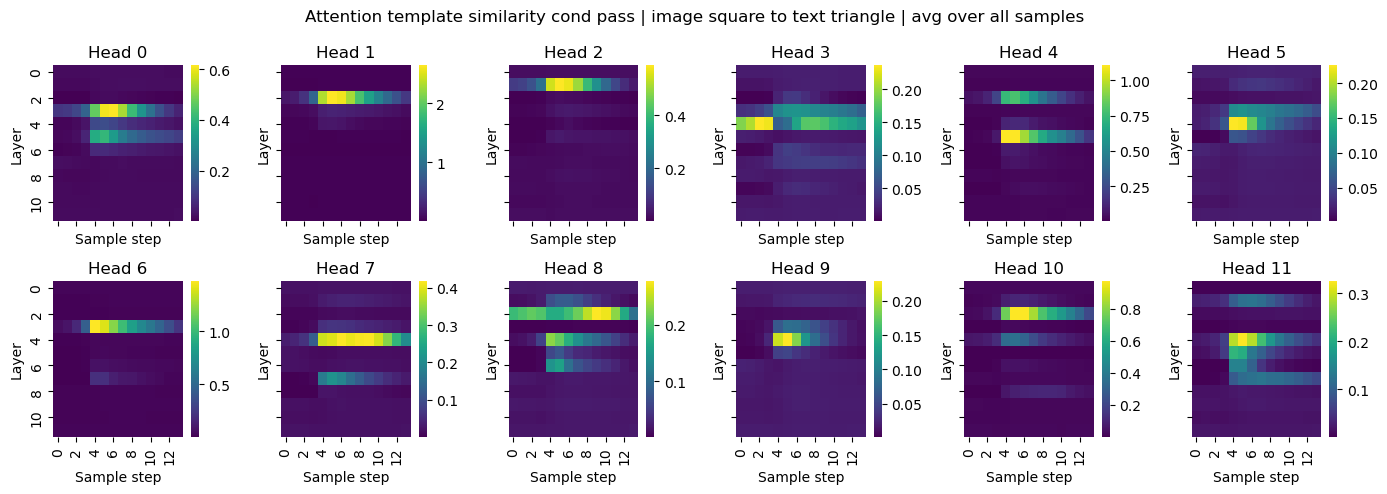

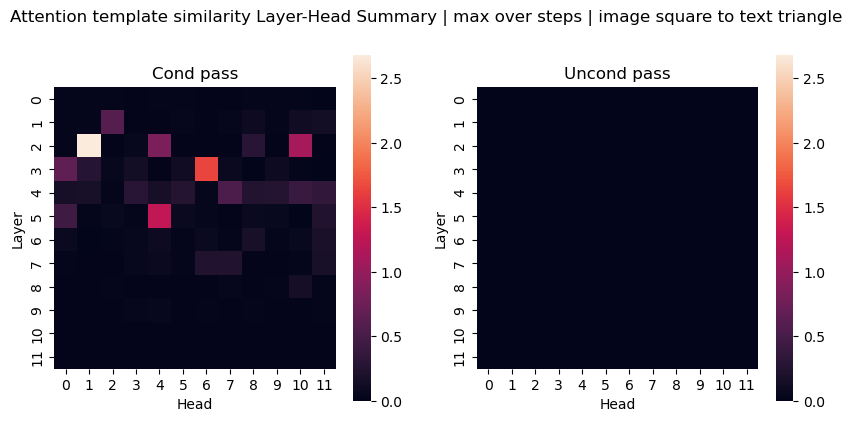


Top Heads image square to text triangle:
--------------------------------------------------
Top1: L2H1, Score: 2.68
Top2: L3H6, Score: 1.64
Top3: L5H4, Score: 1.27
Top4: L2H10, Score: 1.11
Top5: L2H4, Score: 0.83
Top6: L3H0, Score: 0.66
Top7: L1H2, Score: 0.61
Top8: L4H7, Score: 0.53
Saved image square to text triangle to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


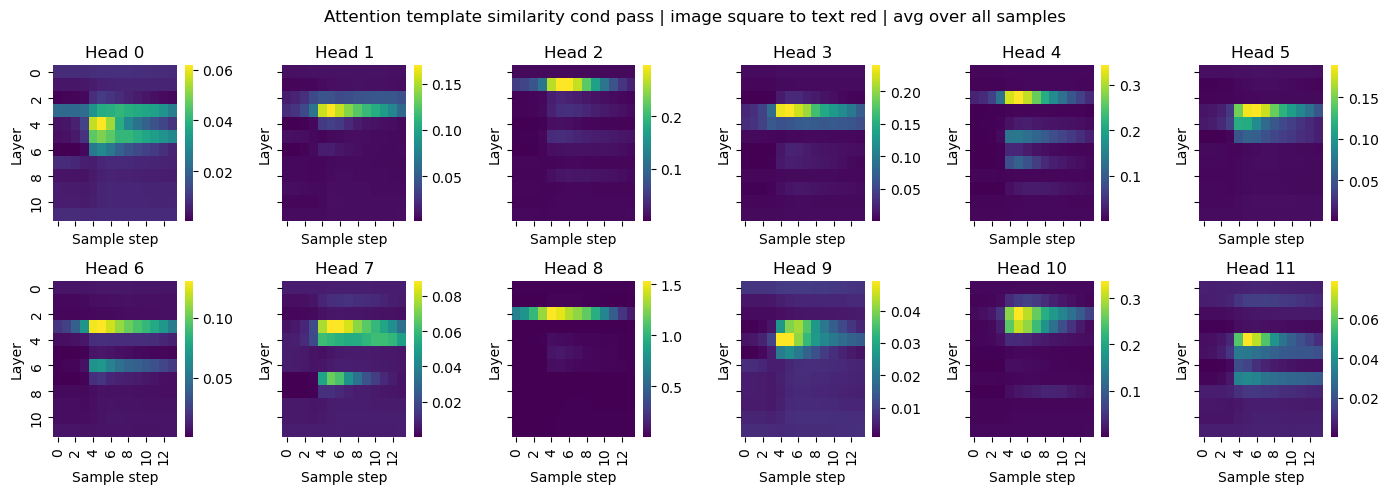

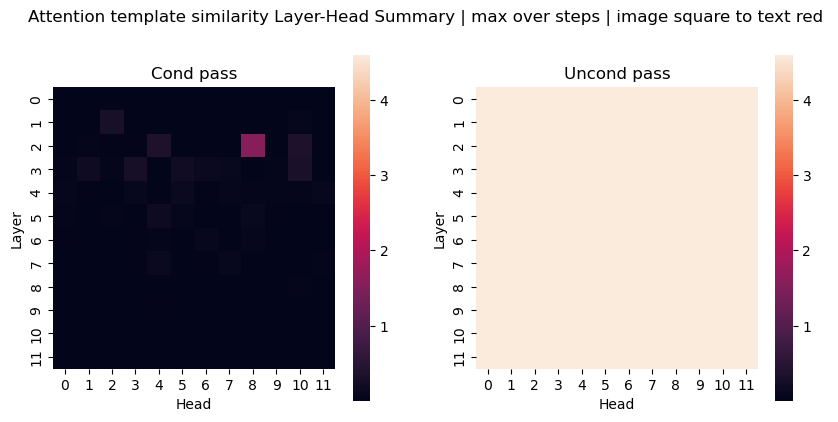


Top Heads image square to text red:
--------------------------------------------------
Top1: L2H8, Score: 1.55
Top2: L2H10, Score: 0.36
Top3: L2H4, Score: 0.35
Top4: L3H10, Score: 0.32
Top5: L1H2, Score: 0.30
Top6: L3H3, Score: 0.28
Top7: L3H5, Score: 0.20
Top8: L3H1, Score: 0.18
Saved image square to text red to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


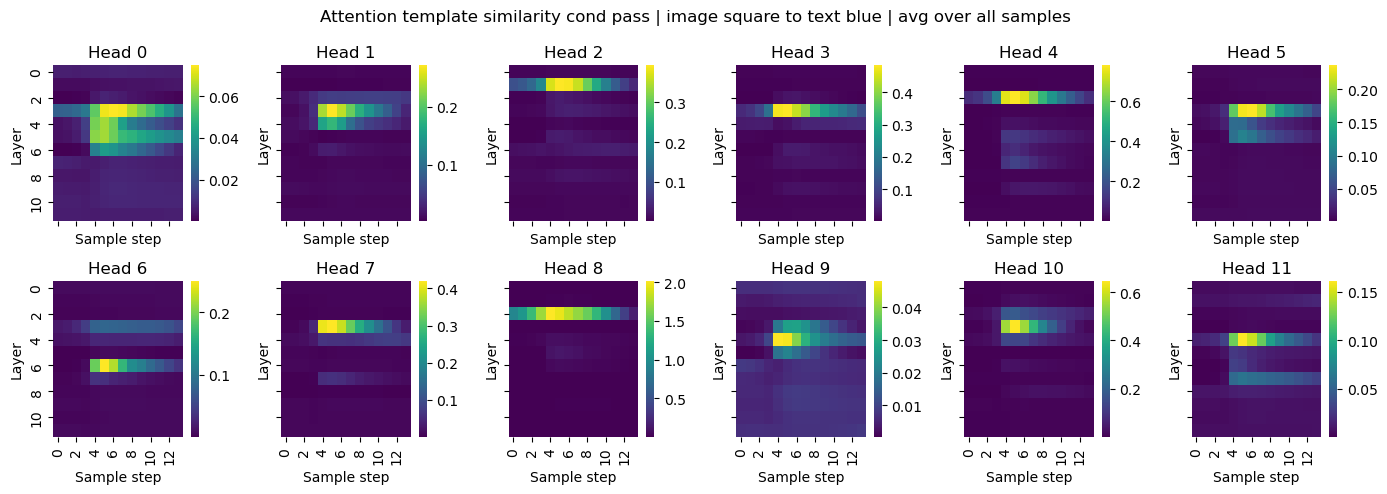

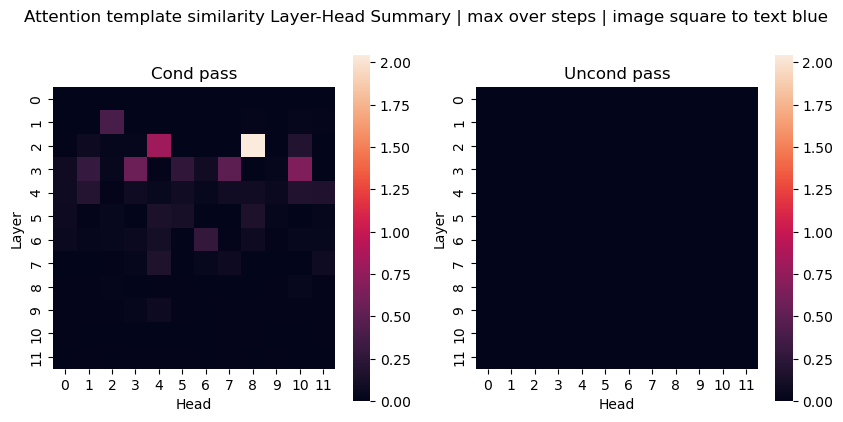


Top Heads image square to text blue:
--------------------------------------------------
Top1: L2H8, Score: 2.05
Top2: L2H4, Score: 0.81
Top3: L3H10, Score: 0.66
Top4: L3H3, Score: 0.56
Top5: L3H7, Score: 0.50
Top6: L1H2, Score: 0.40
Top7: L3H1, Score: 0.29
Top8: L6H6, Score: 0.28
Saved image square to text blue to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


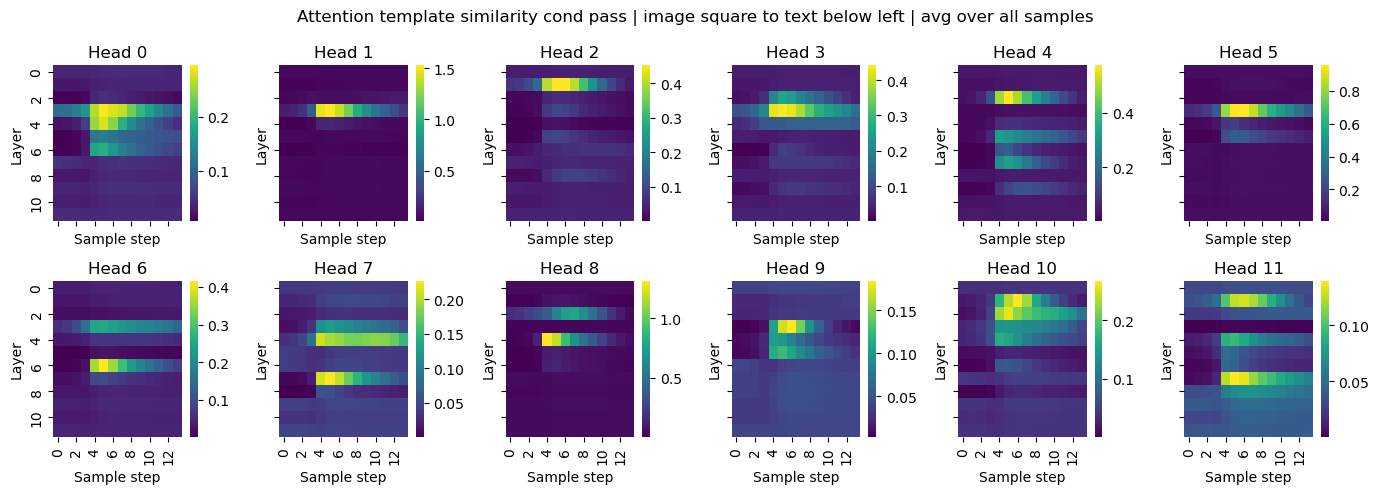

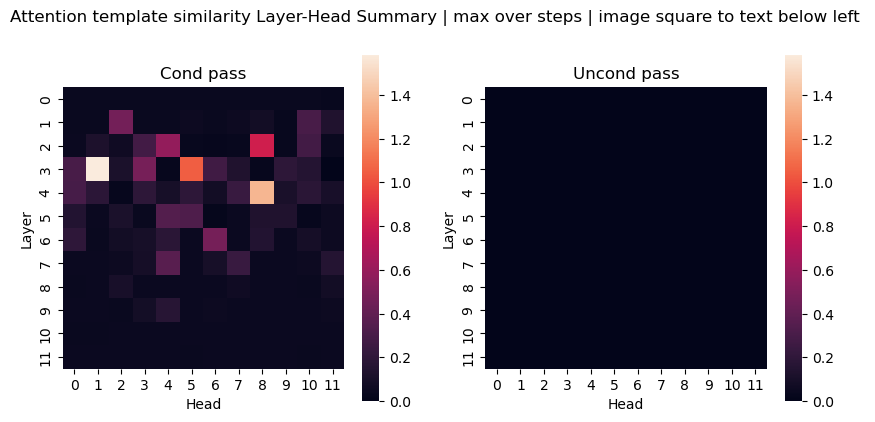


Top Heads image square to text below left:
--------------------------------------------------
Top1: L3H1, Score: 1.59
Top2: L4H8, Score: 1.36
Top3: L3H5, Score: 1.05
Top4: L2H8, Score: 0.81
Top5: L2H4, Score: 0.58
Top6: L3H3, Score: 0.48
Top7: L6H6, Score: 0.47
Top8: L1H2, Score: 0.47
Saved image square to text below left to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


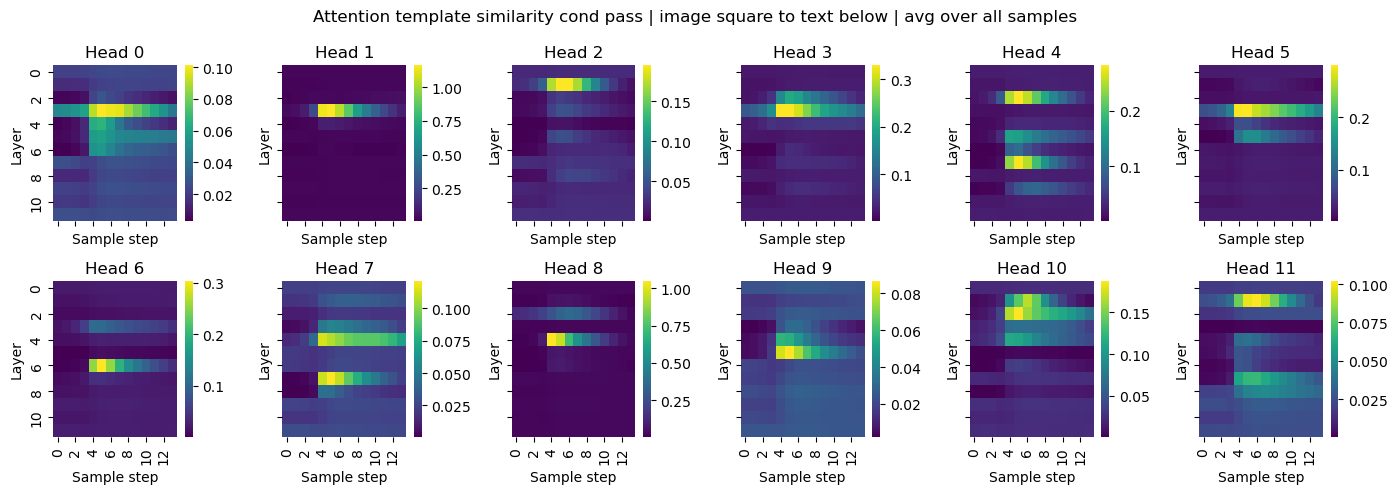

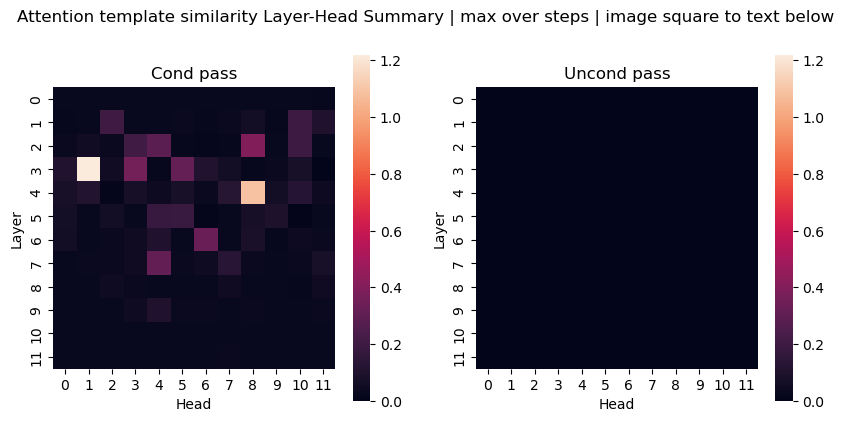


Top Heads image square to text below:
--------------------------------------------------
Top1: L3H1, Score: 1.22
Top2: L4H8, Score: 1.09
Top3: L2H8, Score: 0.40
Top4: L3H3, Score: 0.36
Top5: L6H6, Score: 0.33
Top6: L3H5, Score: 0.31
Top7: L7H4, Score: 0.31
Top8: L2H4, Score: 0.29
Saved image square to text below to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


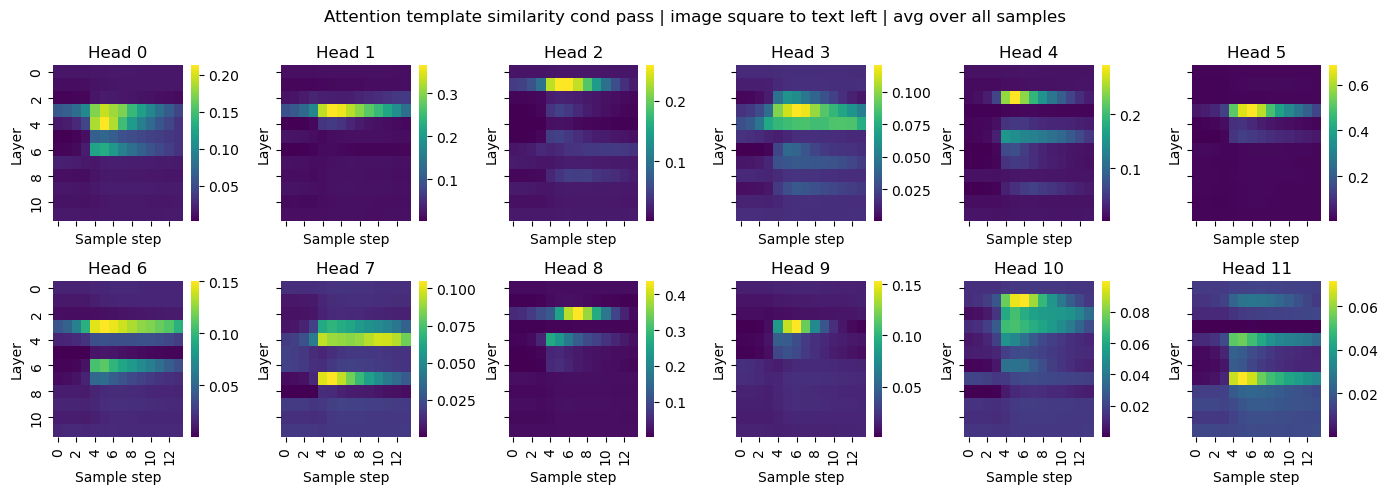

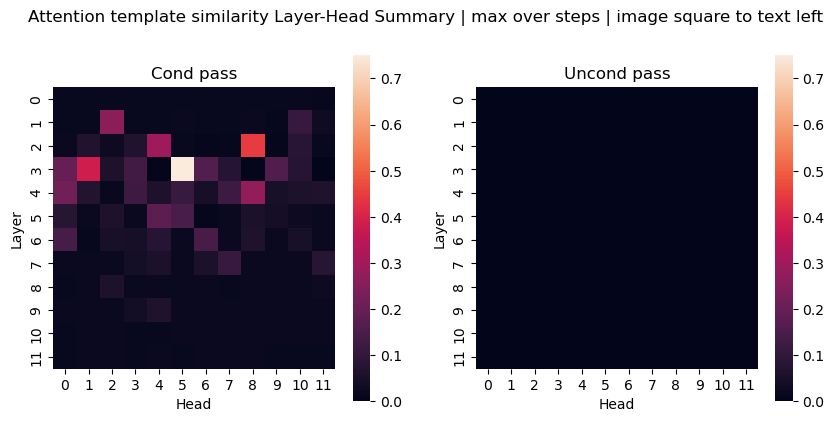


Top Heads image square to text left:
--------------------------------------------------
Top1: L3H5, Score: 0.75
Top2: L2H8, Score: 0.44
Top3: L3H1, Score: 0.39
Top4: L2H4, Score: 0.30
Top5: L4H8, Score: 0.28
Top6: L1H2, Score: 0.27
Top7: L4H0, Score: 0.22
Top8: L3H0, Score: 0.20
Saved image square to text left to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


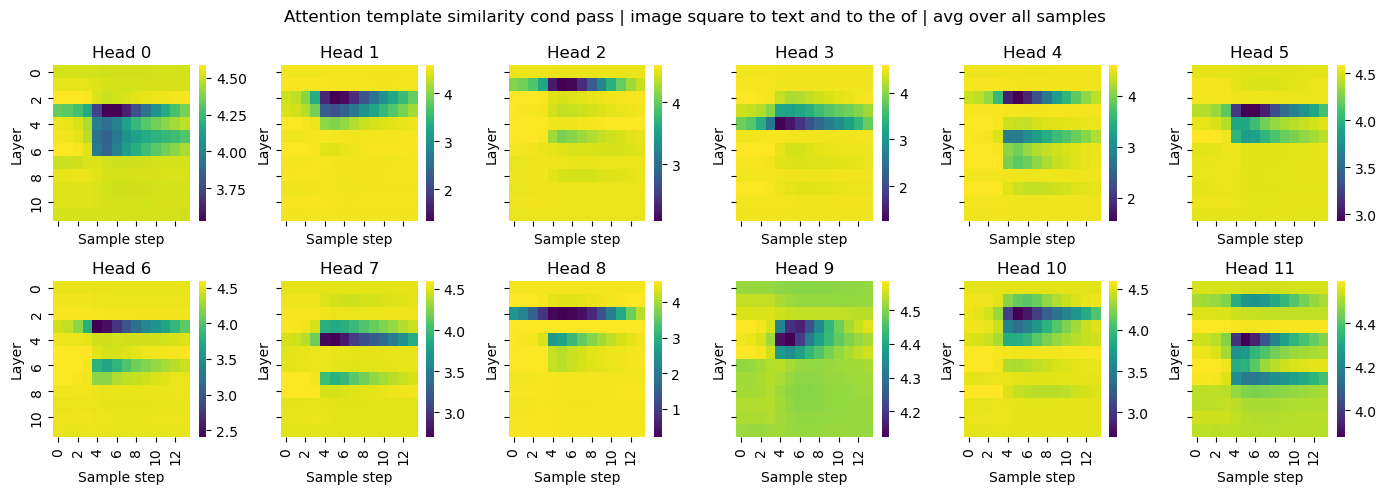

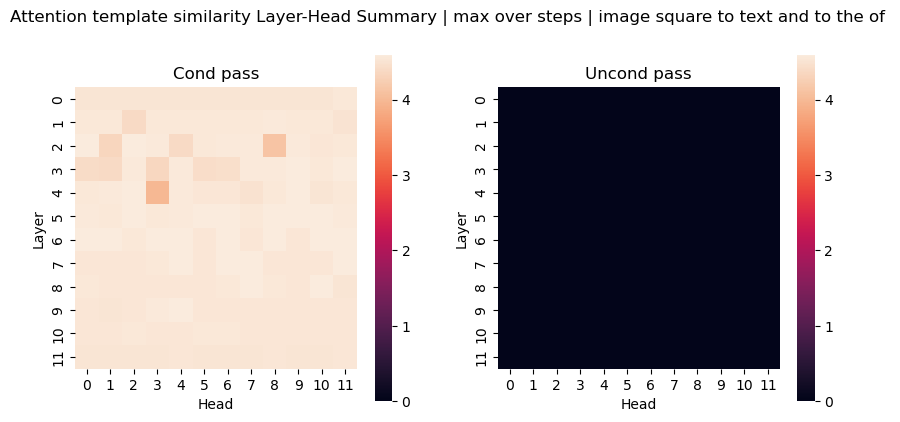


Top Heads image square to text and to the of:
--------------------------------------------------
Top1: L8H7, Score: 4.60
Top2: L4H2, Score: 4.60
Top3: L8H10, Score: 4.59
Top4: L3H11, Score: 4.59
Top5: L5H6, Score: 4.59
Top6: L6H3, Score: 4.59
Top7: L6H11, Score: 4.59
Top8: L7H4, Score: 4.59
Saved image square to text and to the of to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


In [176]:
imgtoken_type = "square"
square_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_square_pos_others_neg_mask)
for text_targets in [["square"], 
                     ["triangle"], 
                     ["red"], 
                     ["blue"],
                     ["below", "left",],
                     ["below", ],
                     ["left", ],
                     ["and", "to", "the", "of"],
                     ]:
    template_type = f"image {imgtoken_type} to text {' '.join(text_targets)}"
    text_mask = create_multi_hot_token_mask(token_splits, text_targets, seq_len=20)
    cross_attn_template = square_cmb_img_msks_vec[:, :, :, None] @ text_mask.float().flatten()[None, :] 
    template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                            title_str=f"Attention template similarity cond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    saveallforms(prompt_dir, f"cross_attn_layer_head_step_cond_heatmap_{template_type.replace(' ', '_')}", figh=fig)
    figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
    saveallforms(prompt_dir, f"cross_attn_layer_head_maxstep_summary_{template_type.replace(' ', '_')}", figh=figh)
    print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");
    with open(join(prompt_dir, f"top_cross_attn_heads_{template_type.replace(' ', '_')}.txt"), "w") as f:
        with redirect_stdout(f):
            print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");
    print(f"Saved {template_type} to {prompt_dir}")
    plt.close("all")

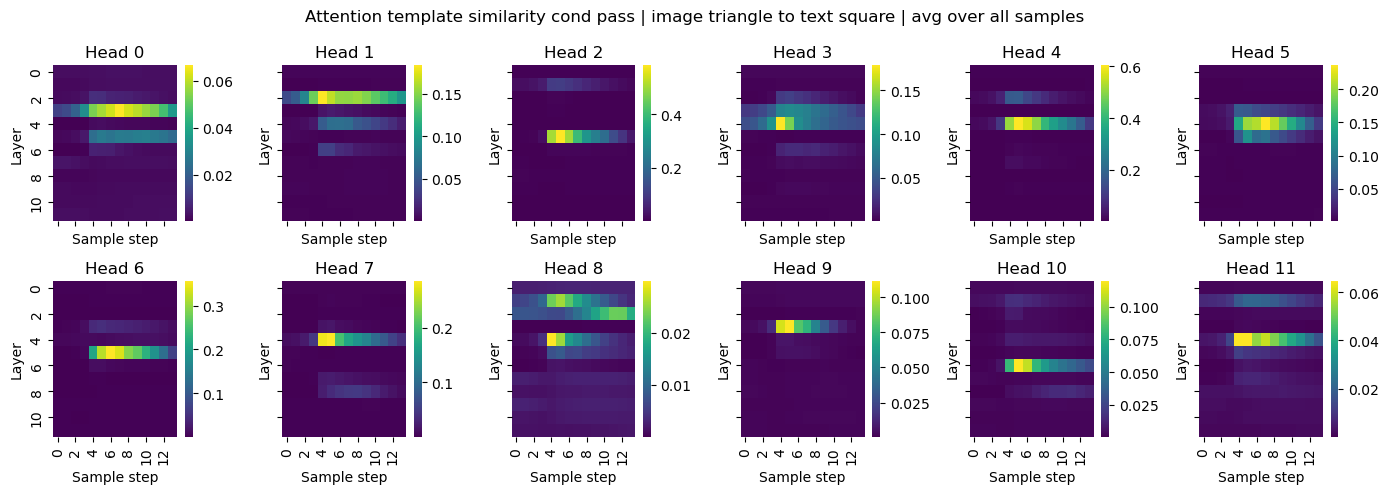

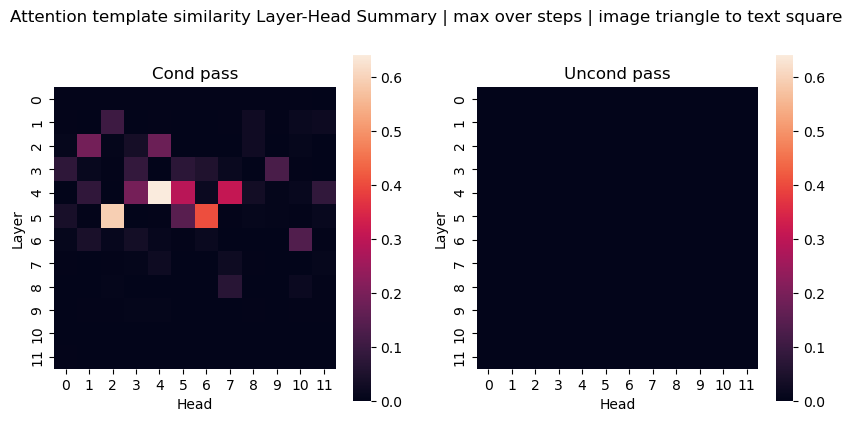


Top Heads image triangle to text square:
--------------------------------------------------
Top1: L4H4, Score: 0.64
Top2: L5H2, Score: 0.59
Top3: L5H6, Score: 0.41
Top4: L4H7, Score: 0.31
Top5: L4H5, Score: 0.29
Top6: L4H3, Score: 0.19
Top7: L2H1, Score: 0.19
Top8: L2H4, Score: 0.18
Saved image triangle to text square to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


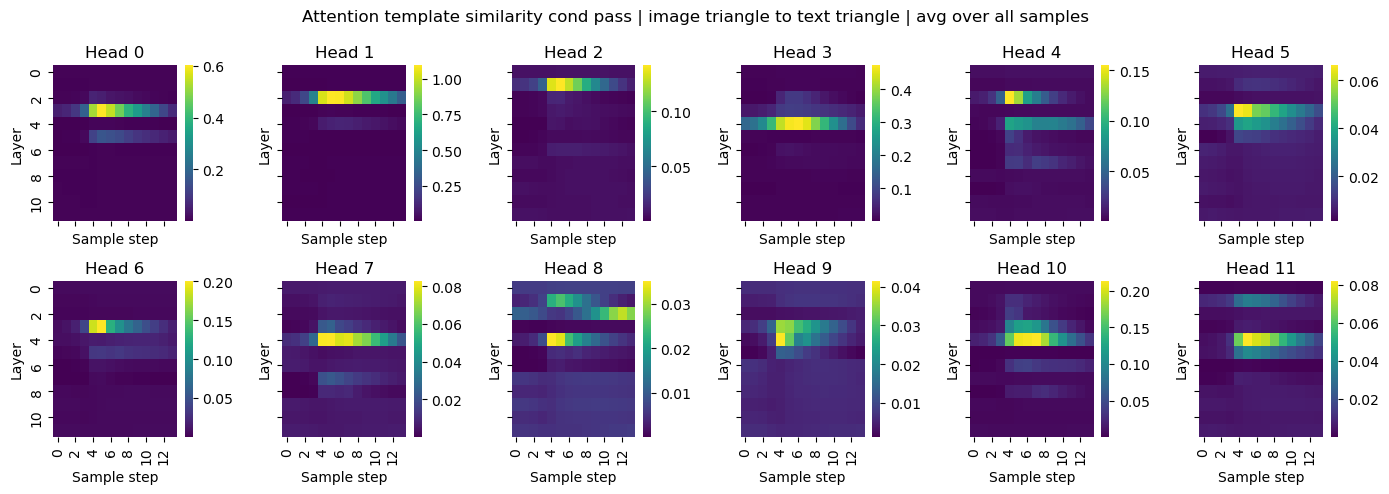

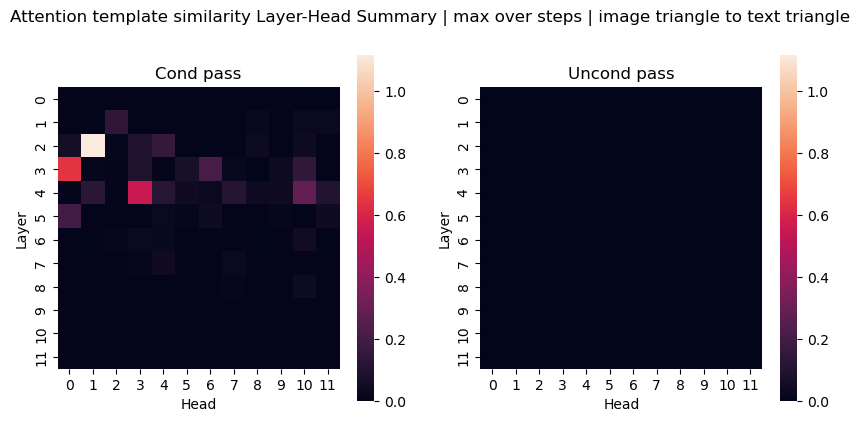


Top Heads image triangle to text triangle:
--------------------------------------------------
Top1: L2H1, Score: 1.12
Top2: L3H0, Score: 0.64
Top3: L4H3, Score: 0.55
Top4: L4H10, Score: 0.28
Top5: L3H6, Score: 0.21
Top6: L5H0, Score: 0.20
Top7: L2H4, Score: 0.16
Top8: L3H10, Score: 0.14
Saved image triangle to text triangle to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


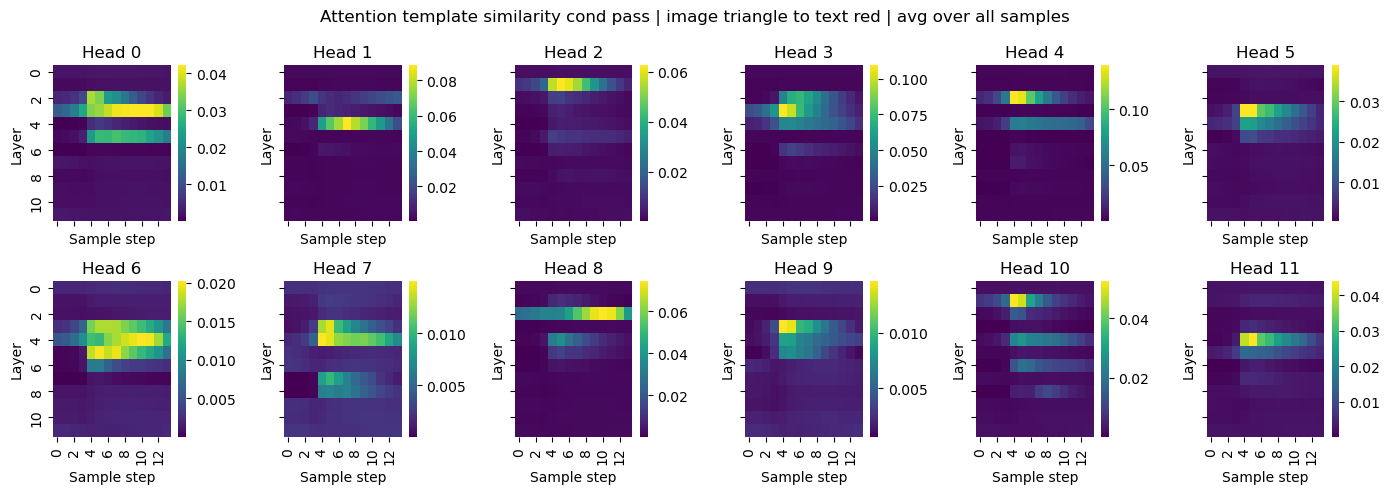

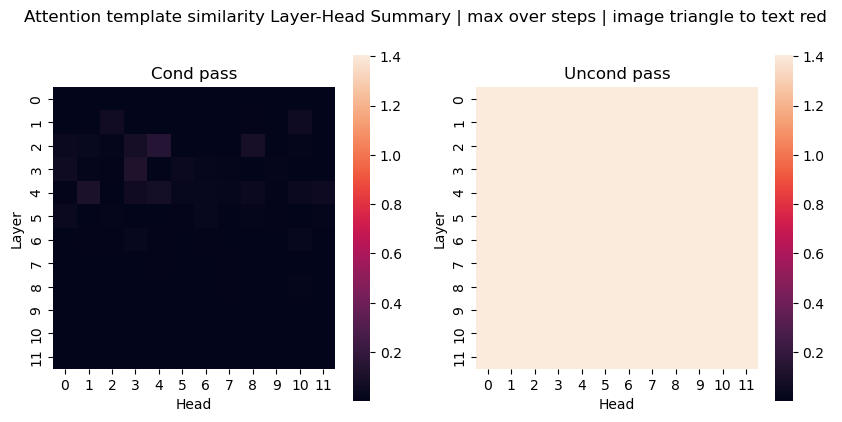


Top Heads image triangle to text red:
--------------------------------------------------
Top1: L2H4, Score: 0.14
Top2: L3H3, Score: 0.11
Top3: L4H1, Score: 0.10
Top4: L2H8, Score: 0.09
Top5: L2H3, Score: 0.08
Top6: L4H4, Score: 0.07
Top7: L1H2, Score: 0.06
Top8: L4H3, Score: 0.06
Saved image triangle to text red to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


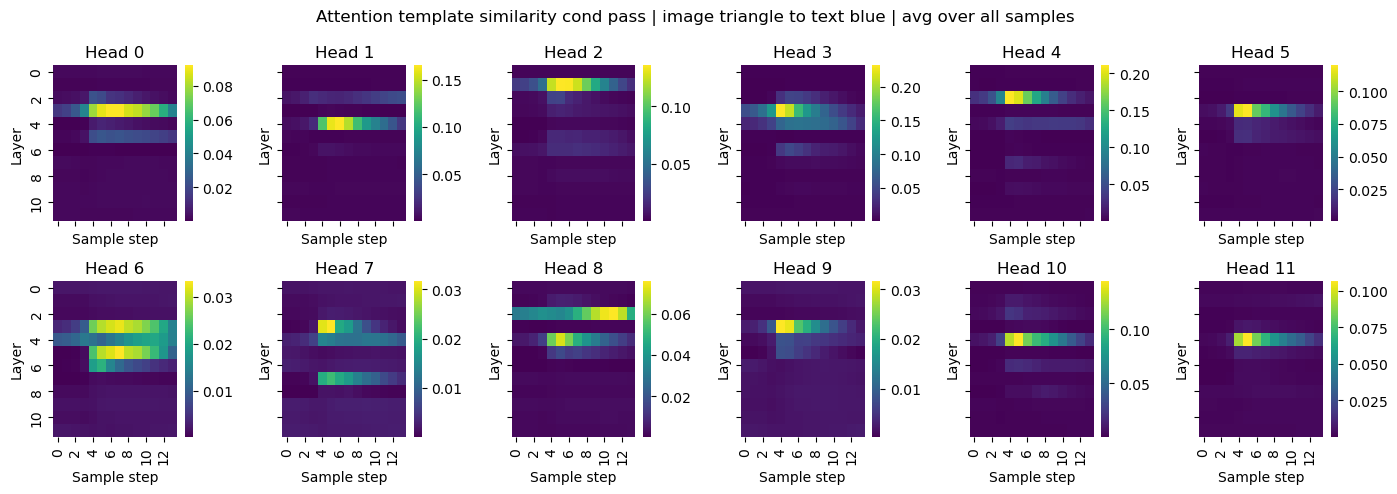

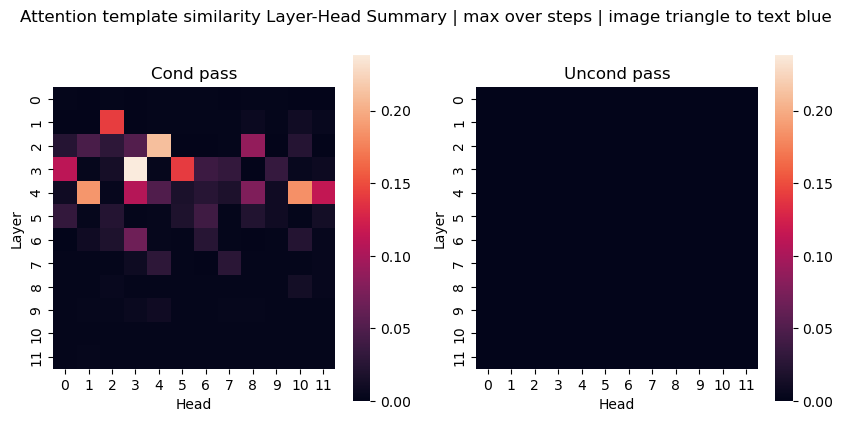


Top Heads image triangle to text blue:
--------------------------------------------------
Top1: L3H3, Score: 0.24
Top2: L2H4, Score: 0.21
Top3: L4H1, Score: 0.19
Top4: L4H10, Score: 0.18
Top5: L1H2, Score: 0.14
Top6: L3H5, Score: 0.14
Top7: L4H11, Score: 0.11
Top8: L3H0, Score: 0.11
Saved image triangle to text blue to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


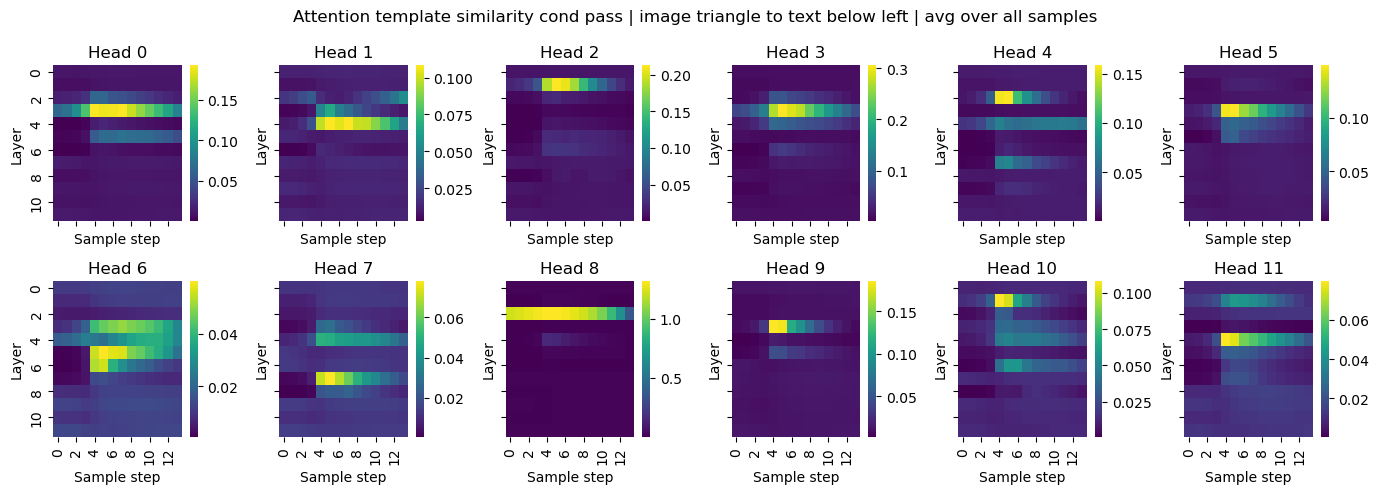

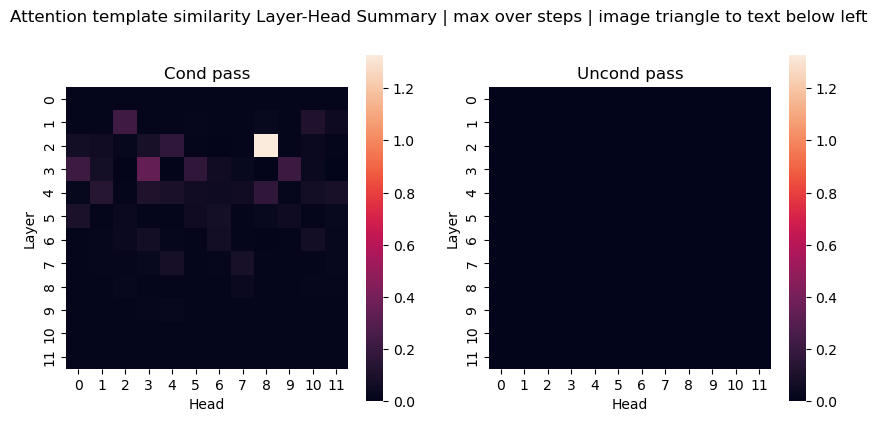


Top Heads image triangle to text below left:
--------------------------------------------------
Top1: L2H8, Score: 1.33
Top2: L3H3, Score: 0.34
Top3: L1H2, Score: 0.22
Top4: L3H0, Score: 0.21
Top5: L3H9, Score: 0.20
Top6: L4H8, Score: 0.17
Top7: L3H5, Score: 0.17
Top8: L2H4, Score: 0.16
Saved image triangle to text below left to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


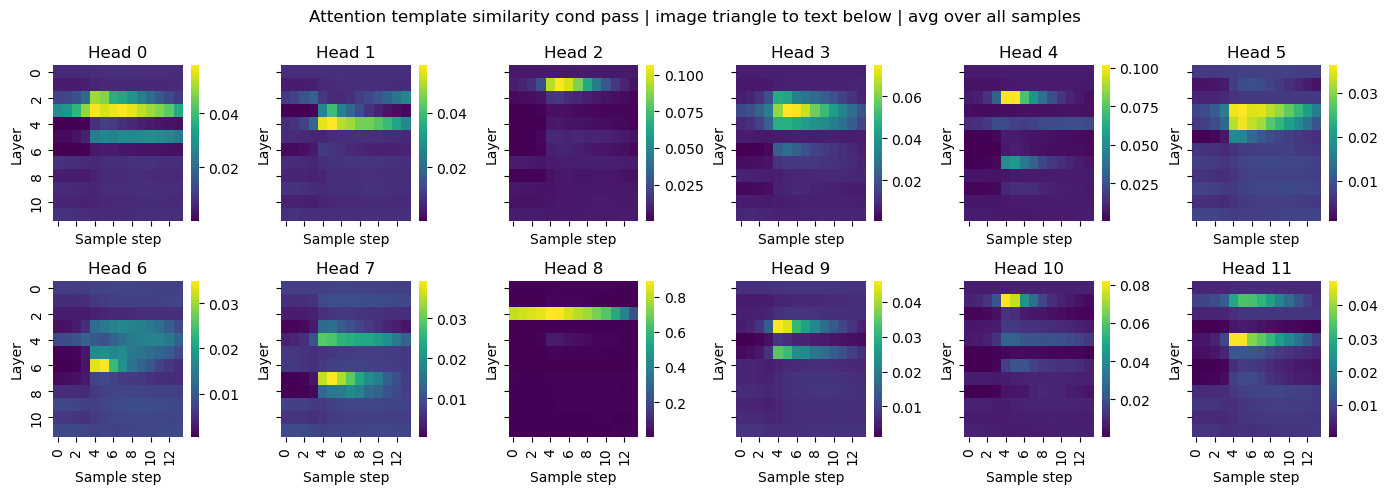

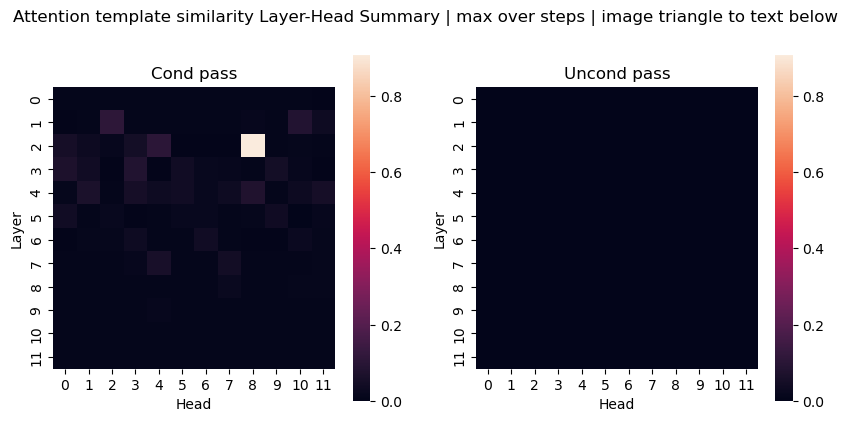


Top Heads image triangle to text below:
--------------------------------------------------
Top1: L2H8, Score: 0.91
Top2: L1H2, Score: 0.11
Top3: L2H4, Score: 0.10
Top4: L1H10, Score: 0.08
Top5: L3H3, Score: 0.08
Top6: L4H8, Score: 0.07
Top7: L3H0, Score: 0.07
Top8: L4H1, Score: 0.07
Saved image triangle to text below to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


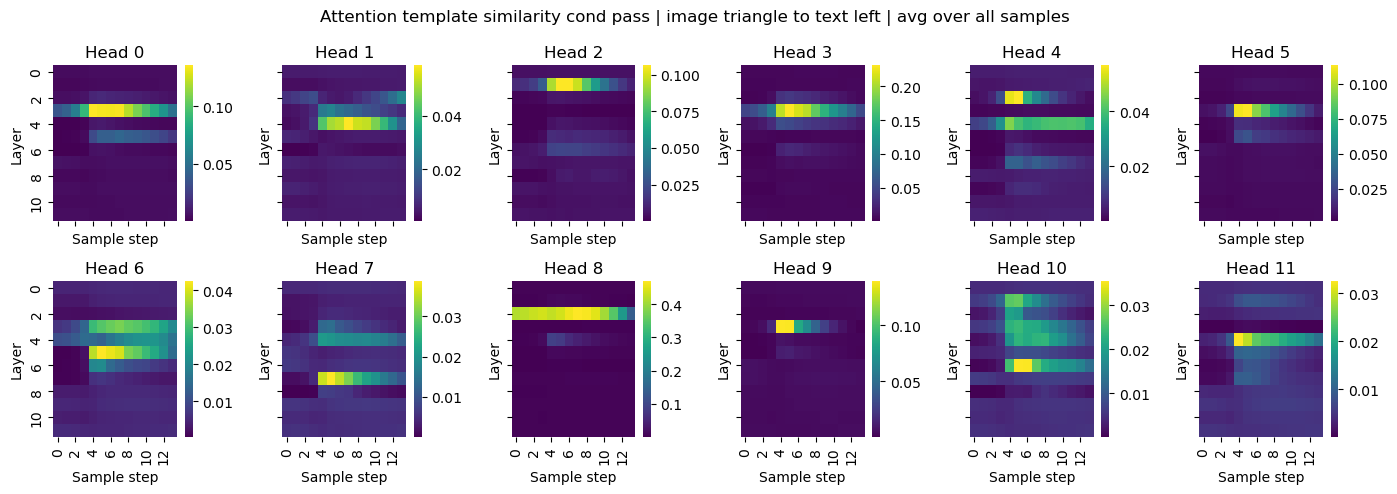

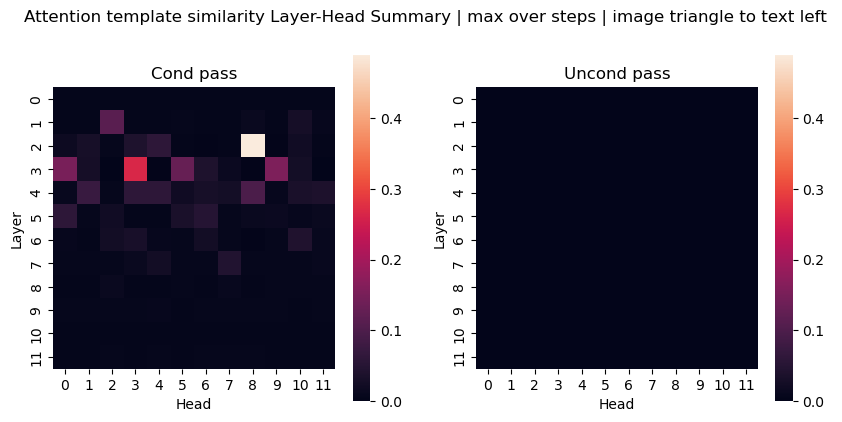


Top Heads image triangle to text left:
--------------------------------------------------
Top1: L2H8, Score: 0.49
Top2: L3H3, Score: 0.27
Top3: L3H9, Score: 0.16
Top4: L3H0, Score: 0.15
Top5: L3H5, Score: 0.13
Top6: L1H2, Score: 0.11
Top7: L4H8, Score: 0.10
Top8: L4H1, Score: 0.07
Saved image triangle to text left to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


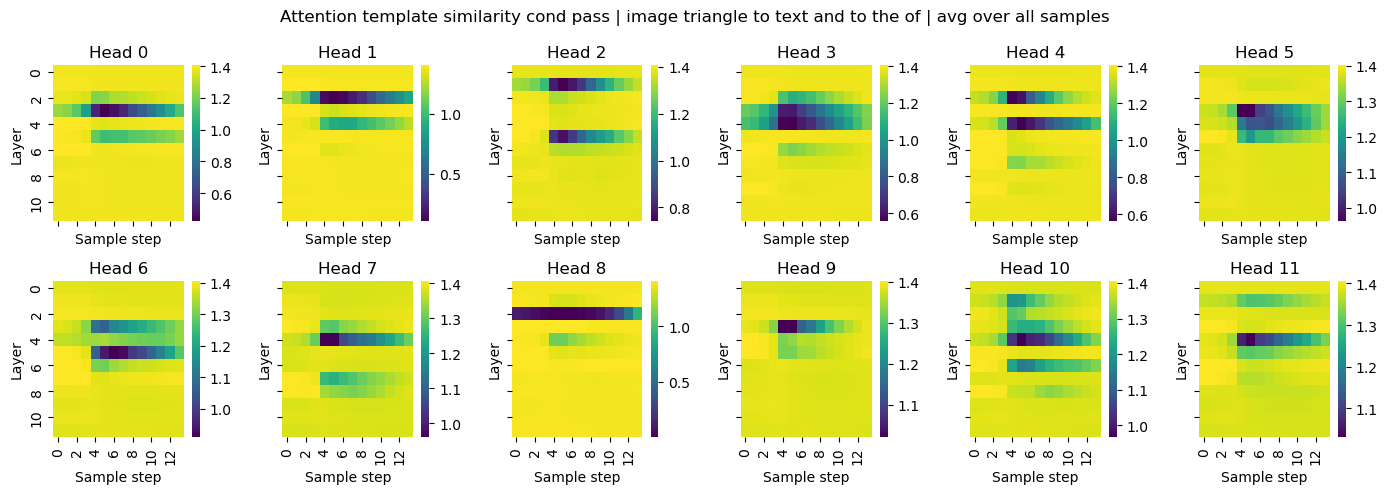

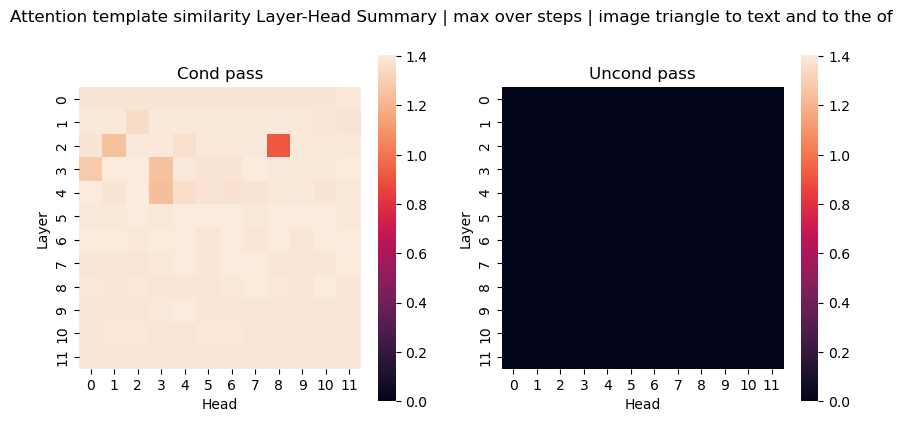


Top Heads image triangle to text and to the of:
--------------------------------------------------
Top1: L8H7, Score: 1.41
Top2: L4H2, Score: 1.41
Top3: L6H4, Score: 1.41
Top4: L6H0, Score: 1.41
Top5: L6H11, Score: 1.41
Top6: L4H0, Score: 1.41
Top7: L6H8, Score: 1.41
Top8: L5H4, Score: 1.41
Saved image triangle to text and to the of to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_vis_figs/red_triangle_below_and_to_the_left_of_blue_square


In [177]:
imgtoken_type = "triangle"
triangle_cmb_img_msks_vec, _ = create_object_based_masks(output[0].images, get_triangle_pos_others_neg_mask)
for text_targets in [["square"], 
                     ["triangle"], 
                     ["red"], 
                     ["blue"],
                     ["below", "left",],
                     ["below", ],
                     ["left", ],
                     ["and", "to", "the", "of"],
                     ]:
    template_type = f"image {imgtoken_type} to text {' '.join(text_targets)}"
    text_mask = create_multi_hot_token_mask(token_splits, text_targets, seq_len=20)
    cross_attn_template = triangle_cmb_img_msks_vec[:, :, :, None] @ text_mask.float().flatten()[None, :] 
    template_similarity_scores = (cross_attn_map_stacked * cross_attn_template).sum(dim=-1).sum(dim=-1)
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                            title_str=f"Attention template similarity cond pass | {template_type}", 
                                            figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
    saveallforms(prompt_dir, f"cross_attn_layer_head_step_cond_heatmap_{template_type.replace(' ', '_')}", figh=fig)
    figh, cond_stats, uncond_stats = plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", share_clim=True);
    saveallforms(prompt_dir, f"cross_attn_layer_head_maxstep_summary_{template_type.replace(' ', '_')}", figh=figh)
    print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");
    with open(join(prompt_dir, f"top_cross_attn_heads_{template_type.replace(' ', '_')}.txt"), "w") as f:
        with redirect_stdout(f):
            print_top_k_scores(cond_stats, k=8, title=f"Top Heads {template_type}");
    print(f"Saved {template_type} to {prompt_dir}")
    plt.close("all")

In [ ]:
from itertools import product
# you can extend these lists as needed
colors = ['red', 'blue']
target_shapes = ['square', 'triangle', 'circle']
verticals = ['above', 'below']
horizontals = ['to the left of', 'to the right of']
prompts = []
for c1, c2 in product(colors, colors):
    if c1 == c2:      # skip same‐color pairs
        continue
    for shape1, shape2 in product(target_shapes, target_shapes):
        if shape1 == shape2:
            continue
        for v in verticals:
            prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
        for h in horizontals:
            prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
        for v, h in product(verticals, horizontals):
            prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")

# print them all out
for p in prompts:
    print(p)

red square is above and to the left of the blue triangle
red square is above and to the right of the blue triangle
red square is below and to the left of the blue triangle
red square is below and to the right of the blue triangle
red square is above and to the left of the blue circle
red square is above and to the right of the blue circle
red square is below and to the left of the blue circle
red square is below and to the right of the blue circle
red triangle is above and to the left of the blue square
red triangle is above and to the right of the blue square
red triangle is below and to the left of the blue square
red triangle is below and to the right of the blue square
red triangle is above and to the left of the blue circle
red triangle is above and to the right of the blue circle
red triangle is below and to the left of the blue circle
red triangle is below and to the right of the blue circle
red circle is above and to the left of the blue square
red circle is above and to the ri

In [200]:
prompts

['red square is above and to the left of the blue triangle',
 'red square is above and to the right of the blue triangle',
 'red square is below and to the left of the blue triangle',
 'red square is below and to the right of the blue triangle',
 'red square is above and to the left of the blue circle',
 'red square is above and to the right of the blue circle',
 'red square is below and to the left of the blue circle',
 'red square is below and to the right of the blue circle',
 'red triangle is above and to the left of the blue square',
 'red triangle is above and to the right of the blue square',
 'red triangle is below and to the left of the blue square',
 'red triangle is below and to the right of the blue square',
 'red triangle is above and to the left of the blue circle',
 'red triangle is above and to the right of the blue circle',
 'red triangle is below and to the left of the blue circle',
 'red triangle is below and to the right of the blue circle',
 'red circle is above an

In [201]:
len(prompts)

48